# Import Libraries

In [37]:
import transformers
print(transformers.__version__)

4.40.1


In [39]:
import datasets
import transformers
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path

from transformers import VisionEncoderDecoderModel

from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments

import json
import random
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

# Preparing the Dataset

In [41]:
with open("Dataset/BanglaLekha/data.json", 'r') as openfile:
    json_object = json.load(openfile)

images_caption_dict = dict(json_object)

images_path = "Dataset/BanglaLekha/images"
images = list(images_caption_dict.keys())

for image_path in images:
    if image_path.endswith('png'):
        new = images_path+ '/' + image_path.split('/')[-1]
        images_caption_dict[new] = images_caption_dict.pop(image_path)
    else:
        images_caption_dict.pop(image_path)

### Train Test Split

In [42]:

def train_test_split(dictionary, seed=0):
    random.seed(seed)
    
    images = list(dictionary.keys())
    images_test = random.sample(images, int(0.1 * len(images)))
    images_train = [img for img in images if img not in images_test]

    train_dict = {img: dictionary[img] for img in images_train}
    test_dict = {img: dictionary[img] for img in images_test}

    return train_dict, test_dict

train, test = train_test_split(images_caption_dict, seed=0)


### Creating Dataframe for Training

In [43]:
def get_df(dictionary):
    data = {'images': [], 'captions': []}

    for image, captions in dictionary.items():
        # processed_captions = [' '.join(capt.replace('<s> ', '').replace(' <e>', '').strip().split(' ')) for capt in captions]
        processed_captions = [' '.join(capt.strip().split(' ')) for capt in captions]
        data['images'].extend([image] * len(processed_captions))
        data['captions'].extend(processed_captions)

    df = pd.DataFrame(data)
    return df

# Generate dataframes for training and test sets
train_df = get_df(train)
test_df = get_df(test)


In [44]:
train_df

,images,captions
0,Dataset/BanglaLekha/images/4724.png,<s> কাদামাটি দেখা যাচ্ছে। <e>
1,Dataset/BanglaLekha/images/4724.png,<s> রাস্তা পানির জন্য অনেক কাদা হয়ে আছে। <e>
2,Dataset/BanglaLekha/images/169.png,<s> আগুন জ্বলছে ও অনেকগুলো মানুষ দাড়িয়ে আছে। <e>
3,Dataset/BanglaLekha/images/169.png,<s> কতগুলো মানুষ রাস্তায় আগুন জ্বেলে আন্দলন কর...
4,Dataset/BanglaLekha/images/8722.png,<s> তিনজন মহিলা মিলে ধানের আটি বাঁধছে। <e>
...,...,...
14825,Dataset/BanglaLekha/images/5391.png,<s> বাশের সাকু দিয়ে লোক জন যাচ্ছে। <e>
14826,Dataset/BanglaLekha/images/861.png,<s> নারী ও শিশু আছে। <e>
14827,Dataset/BanglaLekha/images/861.png,<s> কয়েকজন মানুষ। <e>
14828,Dataset/BanglaLekha/images/7271.png,<s> একজন পুরুষ পতাকার সামনে দাড়িয়ে আছে। <e>


In [45]:
test_df

,images,captions
0,Dataset/BanglaLekha/images/4600.png,<s> একজন পুরুষ বসে আছে। <e>
1,Dataset/BanglaLekha/images/4600.png,<s> একটি ছেলে বসে আছে। <e>
2,Dataset/BanglaLekha/images/4436.png,<s> একটি বাল্ব আছে। দূরে একজন মানুষকে আবছা দেখ...
3,Dataset/BanglaLekha/images/4436.png,<s> রাস্তায় বাল্ব দেখা যাচ্ছে। <e>
4,Dataset/BanglaLekha/images/6222.png,<s> একজন পুরুষ ও দুইটি গাড়ি আছে। <e>
...,...,...
1641,Dataset/BanglaLekha/images/2041.png,<s> রাস্তায় পানি জমে আছে ও কয়েকটি রিক্সা চলছে।...
1642,Dataset/BanglaLekha/images/7614.png,<s> একজন বয়স্ক নারী তাকিয়ে আছে। <e>
1643,Dataset/BanglaLekha/images/7614.png,<s> একজন মহিলা মুখ বাড়িয়ে তাকিয়ে আছে । <e>
1644,Dataset/BanglaLekha/images/1491.png,<s> তিনজন বালিকা বসে আছে। <e>


In [46]:
image_encoder_model = "microsoft/swin-base-patch4-window12-384-in22k"
# "microsoft/swin-base-patch4-window7-224-in22k"
text_decode_model = "shahidul034/text_generation_bangla_model"

### Intializing Decoder Tokenizer

In [47]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(text_decode_model)

### Intializing ViT Feature Extractor

In [48]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)

f:\Anaconda\anaconda3\envs\vision_torch\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### Creating Dataset for training (The number of training samples wre limited due to processing restrictions)

In [49]:

class Dataset(Dataset):
    def __init__(self, df, tokenizer, image_processor, decoder_max_length=64):
        self.df = df
        self.tokenizer = tokenizer
        self.image_processor  = image_processor 
        self.decoder_max_length = decoder_max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        img_path = self.df['images'][idx]
        caption = self.df['captions'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.image_processor (image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length", 
                                          max_length=self.decoder_max_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding
    
train_dataset = Dataset(df=train_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          image_processor = feature_extractor )
eval_dataset = Dataset(df=test_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,image_processor = feature_extractor )


In [50]:
len(train_dataset)

14830

In [51]:
len(eval_dataset)

1646

In [52]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model, text_decode_model)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at shahidul034/text_generation_bangla_model and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.

#### Setting parameters

In [53]:
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token

model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 2

### Training


In [54]:
captioning_model = 'SwinB-gpt2-bs8'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    #evaluate_during_training=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    num_train_epochs = 20,
    overwrite_output_dir=True,
    # save_total_limit=1,
    seed=42,
)

from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor ,
    model=model,
    args=training_args,
    # compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [ ]:
trainer.train()

  0%|          | 0/37080 [00:00<?, ?it/s]

{'loss': 1.1843, 'grad_norm': 2.4730608463287354, 'learning_rate': 5e-05, 'epoch': 0.55}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 0.8227542638778687, 'eval_runtime': 96.6905, 'eval_samples_per_second': 17.023, 'eval_steps_per_second': 2.131, 'epoch': 1.0}
{'loss': 0.8308, 'grad_norm': 2.373241662979126, 'learning_rate': 4.857998668737519e-05, 'epoch': 1.1}
{'loss': 0.6858, 'grad_norm': 2.8316426277160645, 'learning_rate': 4.715997337475039e-05, 'epoch': 1.66}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 0.7650344967842102, 'eval_runtime': 89.5501, 'eval_samples_per_second': 18.381, 'eval_steps_per_second': 2.3, 'epoch': 2.0}
{'loss': 0.6033, 'grad_norm': 2.6805922985076904, 'learning_rate': 4.573996006212559e-05, 'epoch': 2.21}
{'loss': 0.4897, 'grad_norm': 2.7581732273101807, 'learning_rate': 4.431994674950078e-05, 'epoch': 2.76}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 0.7946342825889587, 'eval_runtime': 107.7438, 'eval_samples_per_second': 15.277, 'eval_steps_per_second': 1.912, 'epoch': 3.0}
{'loss': 0.3928, 'grad_norm': 2.257378578186035, 'learning_rate': 4.2899933436875975e-05, 'epoch': 3.31}
{'loss': 0.33, 'grad_norm': 1.9282053709030151, 'learning_rate': 4.1479920124251165e-05, 'epoch': 3.87}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 0.8549177050590515, 'eval_runtime': 102.5152, 'eval_samples_per_second': 16.056, 'eval_steps_per_second': 2.009, 'epoch': 4.0}
{'loss': 0.2363, 'grad_norm': 2.3655600547790527, 'learning_rate': 4.005990681162636e-05, 'epoch': 4.42}
{'loss': 0.2213, 'grad_norm': 1.907026767730713, 'learning_rate': 3.863989349900155e-05, 'epoch': 4.97}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 0.9362987875938416, 'eval_runtime': 111.3305, 'eval_samples_per_second': 14.785, 'eval_steps_per_second': 1.85, 'epoch': 5.0}
{'loss': 0.1486, 'grad_norm': 2.3393867015838623, 'learning_rate': 3.721988018637675e-05, 'epoch': 5.52}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 1.0088779926300049, 'eval_runtime': 111.1592, 'eval_samples_per_second': 14.808, 'eval_steps_per_second': 1.853, 'epoch': 6.0}
{'loss': 0.1503, 'grad_norm': 1.352876901626587, 'learning_rate': 3.579986687375194e-05, 'epoch': 6.08}
{'loss': 0.1142, 'grad_norm': 1.5518810749053955, 'learning_rate': 3.437985356112714e-05, 'epoch': 6.63}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 1.0576045513153076, 'eval_runtime': 108.2422, 'eval_samples_per_second': 15.207, 'eval_steps_per_second': 1.903, 'epoch': 7.0}
{'loss': 0.1094, 'grad_norm': 1.250994086265564, 'learning_rate': 3.2959840248502335e-05, 'epoch': 7.18}
{'loss': 0.0953, 'grad_norm': 1.5288729667663574, 'learning_rate': 3.1539826935877525e-05, 'epoch': 7.73}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 1.1148351430892944, 'eval_runtime': 108.327, 'eval_samples_per_second': 15.195, 'eval_steps_per_second': 1.902, 'epoch': 8.0}
{'loss': 0.0861, 'grad_norm': 1.2265799045562744, 'learning_rate': 3.011981362325272e-05, 'epoch': 8.28}
{'loss': 0.0818, 'grad_norm': 1.477109670639038, 'learning_rate': 2.8699800310627913e-05, 'epoch': 8.84}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 1.1452140808105469, 'eval_runtime': 108.0172, 'eval_samples_per_second': 15.238, 'eval_steps_per_second': 1.907, 'epoch': 9.0}
{'loss': 0.0699, 'grad_norm': 1.2838099002838135, 'learning_rate': 2.727978699800311e-05, 'epoch': 9.39}
{'loss': 0.0717, 'grad_norm': 1.1174399852752686, 'learning_rate': 2.5859773685378304e-05, 'epoch': 9.94}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 1.1852766275405884, 'eval_runtime': 108.4139, 'eval_samples_per_second': 15.183, 'eval_steps_per_second': 1.9, 'epoch': 10.0}
{'loss': 0.0583, 'grad_norm': 0.8271209597587585, 'learning_rate': 2.4439760372753494e-05, 'epoch': 10.49}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 1.2204020023345947, 'eval_runtime': 109.2946, 'eval_samples_per_second': 15.06, 'eval_steps_per_second': 1.885, 'epoch': 11.0}
{'loss': 0.0635, 'grad_norm': 0.6552444696426392, 'learning_rate': 2.301974706012869e-05, 'epoch': 11.05}
{'loss': 0.0513, 'grad_norm': 0.7520139813423157, 'learning_rate': 2.1599733747503882e-05, 'epoch': 11.6}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 1.229769229888916, 'eval_runtime': 108.1652, 'eval_samples_per_second': 15.217, 'eval_steps_per_second': 1.904, 'epoch': 12.0}
{'loss': 0.0545, 'grad_norm': 1.1753884553909302, 'learning_rate': 2.017972043487908e-05, 'epoch': 12.15}
{'loss': 0.0482, 'grad_norm': 0.6922520995140076, 'learning_rate': 1.8759707122254273e-05, 'epoch': 12.7}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.257856845855713, 'eval_runtime': 121.0407, 'eval_samples_per_second': 13.599, 'eval_steps_per_second': 1.702, 'epoch': 13.0}


Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


{'loss': 0.047, 'grad_norm': 0.7756720781326294, 'learning_rate': 1.7339693809629463e-05, 'epoch': 13.26}
{'loss': 0.0455, 'grad_norm': 0.5991942286491394, 'learning_rate': 1.591968049700466e-05, 'epoch': 13.81}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.2808680534362793, 'eval_runtime': 127.2007, 'eval_samples_per_second': 12.94, 'eval_steps_per_second': 1.619, 'epoch': 14.0}


Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


{'loss': 0.041, 'grad_norm': 0.5007205009460449, 'learning_rate': 1.4499667184379853e-05, 'epoch': 14.36}
{'loss': 0.0435, 'grad_norm': 0.6940307021141052, 'learning_rate': 1.3079653871755048e-05, 'epoch': 14.91}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.3225923776626587, 'eval_runtime': 117.2047, 'eval_samples_per_second': 14.044, 'eval_steps_per_second': 1.758, 'epoch': 15.0}


Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


{'loss': 0.0361, 'grad_norm': 0.6244548559188843, 'learning_rate': 1.1659640559130244e-05, 'epoch': 15.46}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.332309365272522, 'eval_runtime': 116.8385, 'eval_samples_per_second': 14.088, 'eval_steps_per_second': 1.763, 'epoch': 16.0}


Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


{'loss': 0.0399, 'grad_norm': 0.43485724925994873, 'learning_rate': 1.0239627246505437e-05, 'epoch': 16.02}
{'loss': 0.0323, 'grad_norm': 0.6813250780105591, 'learning_rate': 8.81961393388063e-06, 'epoch': 16.57}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.355362057685852, 'eval_runtime': 108.5699, 'eval_samples_per_second': 15.161, 'eval_steps_per_second': 1.897, 'epoch': 17.0}


Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


{'loss': 0.0352, 'grad_norm': 0.6649723052978516, 'learning_rate': 7.399600621255824e-06, 'epoch': 17.12}
{'loss': 0.0307, 'grad_norm': 0.5384253263473511, 'learning_rate': 5.979587308631019e-06, 'epoch': 17.67}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 1.3731251955032349, 'eval_runtime': 111.0132, 'eval_samples_per_second': 14.827, 'eval_steps_per_second': 1.856, 'epoch': 18.0}
{'loss': 0.031, 'grad_norm': 0.5029323101043701, 'learning_rate': 4.559573996006213e-06, 'epoch': 18.23}
{'loss': 0.0286, 'grad_norm': 0.5423732399940491, 'learning_rate': 3.139560683381407e-06, 'epoch': 18.78}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 1.3909226655960083, 'eval_runtime': 111.5827, 'eval_samples_per_second': 14.751, 'eval_steps_per_second': 1.846, 'epoch': 19.0}
{'loss': 0.0268, 'grad_norm': 0.53739994764328, 'learning_rate': 1.7195473707566009e-06, 'epoch': 19.33}
{'loss': 0.0253, 'grad_norm': 1.032273292541504, 'learning_rate': 2.9953405813179503e-07, 'epoch': 19.88}


  0%|          | 0/206 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

{'eval_loss': 1.4135371446609497, 'eval_runtime': 108.9523, 'eval_samples_per_second': 15.108, 'eval_steps_per_second': 1.891, 'epoch': 20.0}
{'train_runtime': 129447.8667, 'train_samples_per_second': 2.291, 'train_steps_per_second': 0.286, 'train_loss': 0.18353103535589405, 'epoch': 20.0}


TrainOutput(global_step=37080, training_loss=0.18353103535589405, metrics={'train_runtime': 129447.8667, 'train_samples_per_second': 2.291, 'train_steps_per_second': 0.286, 'total_flos': 1.5830463113944105e+20, 'train_loss': 0.18353103535589405, 'epoch': 20.0})

## Loading and Evaluating performance

In [55]:
model_path = 'SwinB-gpt2-bs8/checkpoint-9270'

In [56]:
t = VisionEncoderDecoderModel.from_pretrained(model_path)

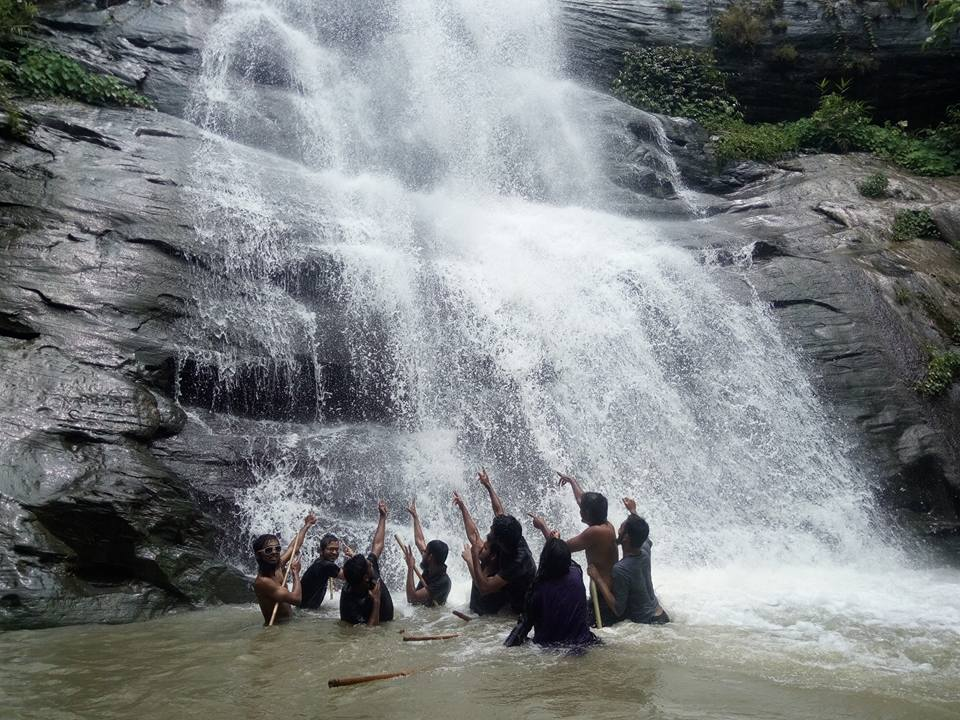

In [57]:
temp = test_df.sample(1).images.iloc[0]
Image.open(temp).convert("RGB")

In [58]:
tokenizer.decode(t.generate(feature_extractor (Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])

f:\Anaconda\anaconda3\envs\vision_torch\lib\site-packages\transformers\generation\utils.py:1256: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


'<|endoftext|><s> কয়েকজন ছেলেরা পাহারের পানিতে গোসল করছে। <e> পিছনে অনেকগুলো মেয়ে দাড়িয়ে আছে পুরুষ। <e'

In [59]:
current_directory = os.getcwd()
directory = current_directory + "/" + model_path
eval_results_path = os.path.join(directory, "eval_results.txt")
print(eval_results_path)

f:\Anaconda\Jupyter Notebooks\Vision Encode-Decoder Image Captioning/SwinB-gpt2-bs8/checkpoint-9270\eval_results.txt


In [60]:
t.config.eos_token_id = tokenizer.sep_token_id
t.config.max_length = 64
t.config.early_stopping = True
t.config.no_repeat_ngram_size = 3
t.config.length_penalty = 2.0
t.config.num_beams = 2

In [61]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = t.to(device)

with open(eval_results_path, 'w', encoding='utf8') as newfile:
    f=open(r"F:\Anaconda\Jupyter Notebooks\CLIP_prefix_caption_Bangla_Dataset\data\blekha\annotations\test_captions_ids.txt", 'r', encoding='utf8')

    for i in tqdm(f, desc="Generating Captions"):
        i=i.replace('\n','')
        image_path = "Dataset/BanglaLekha/images/" + i
        print(image_path)
        image = Image.open(image_path).convert("RGB")
        pixel_values = feature_extractor (image, return_tensors="pt").pixel_values.to(device)
        # Generate captions for the image
        caption_ids = t.generate(pixel_values, max_length=64, early_stopping=True)

        # Decode the generated captions
        caption = tokenizer.decode(caption_ids[0], skip_special_tokens=True)

        # Display the generated captions
        image_path = image_path.split('/')[-1]
        # caption = caption.replace(" ।", "।")
        print(image_path," ",caption)
        caption = caption.split()
        newfile.write((image_path+str(caption))+'\n')

Generating Captions: 0it [00:00, ?it/s]

Dataset/BanglaLekha/images/8875.png


Generating Captions: 1it [00:01,  1.27s/it]

8875.png   <s> কয়েকজন মানুষ আছে। <e> একটি সেতুর উপরে একটি ছাতার কাজ করছেন এবং পিছনে পাহাড় দেখা যায়। <ee> কয
Dataset/BanglaLekha/images/2215.png


Generating Captions: 2it [00:02,  1.06s/it]

2215.png   <s> একজন মাথায় বালুর ঝুড়ি নিয়ে আছে। <e> একজন নারী তাকিযে আছে।<e> শার্ট পরে একজন পুরুষ তামিল চ
Dataset/BanglaLekha/images/4113.png


Generating Captions: 3it [00:03,  1.04it/s]

4113.png   <s> একজন নারী, একজন পুরুষ ও চারজন পুঙ্গ ছাত্রী বসে আছে। <e> পাশের হাতে কিছু মানুষ দেখা যাচ্ছ
Dataset/BanglaLekha/images/5703.png


Generating Captions: 4it [00:03,  1.07it/s]

5703.png   <s> দুইটি ছেলে শিশু দাড়িয়ে আছে। <e> দূরে একজন মানুষ দেখা যাচ্ছে। <s> একজন ছেয়ে গেঞ্জি পরা ছ
Dataset/BanglaLekha/images/2756.png


Generating Captions: 5it [00:04,  1.10it/s]

2756.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একটি রিক্সার সামনে একজন প্লাটফর্মে আছে। পিছনে রাস্তার পাশে একজন মান
Dataset/BanglaLekha/images/1447.png


Generating Captions: 6it [00:05,  1.12it/s]

1447.png   <s> একজন নারী দাড়িয়ে আছে। <e> একজন শারি পরা মহিলা কল চেপে কলসে পানি নিচ্ছে।<e> শারটিতে রান্না ঘর
Dataset/BanglaLekha/images/3542.png


Generating Captions: 7it [00:06,  1.15it/s]

3542.png   <s> একটি মেয়ে শিশু তাকিয়ে আছে। <e> একজন বাচ্চা তার মাথার জানালা দিচ্ছে। <s> ১ টি বাসার স
Dataset/BanglaLekha/images/790.png


Generating Captions: 8it [00:07,  1.16it/s]

790.png   <s> দুইটি শিশু নৌকা নিয়ে যাচ্ছে। পাশে পানিতে দুইজন মানুষ আছে। <e> দূরে একজন পুরুষ দাঁড়িয
Dataset/BanglaLekha/images/3258.png


Generating Captions: 9it [00:08,  1.15it/s]

3258.png   <s> একজন পুরুষ মাথার উপর ঝাঁকা নিয়ে আছে। <e> একজন মানুষ পানির ভিতর পাশাপাশি দাঁড়িয়ে থেকে মাছ
Dataset/BanglaLekha/images/1296.png


Generating Captions: 10it [00:09,  1.14it/s]

1296.png   <s> একজন পুরুষ রিক্সা চালাচ্ছে। একজন নারী রিকশায় বসে আছে। <e> রিকন সেলে বসে দাড়িয়ে আছে। পাশে একজন
Dataset/BanglaLekha/images/8439.png


Generating Captions: 11it [00:09,  1.13it/s]

8439.png   <s> পানিতে অনেকগুলো মানুষ আছে। <e> একটি ছেলে শিশু হাতে বই নিয়ে দাড়িয়ে হাসছে। <s> কিছু ছে
Dataset/BanglaLekha/images/5229.png


Generating Captions: 12it [00:10,  1.12it/s]

5229.png   <s> একজন ছোট মেয়ে লাল শারি পরে পড়ালেখা করছে একটি ছেলে। <e> একটি মাদ্রাসায় বসে কাগজে আর্ট করছে ২ জন ছ
Dataset/BanglaLekha/images/3919.png


Generating Captions: 13it [00:11,  1.13it/s]

3919.png   <s> একজন নারী জানালাতে তাকিয়ে আছে। <e> দরজার গাড়িতে একজন পুরুষ বসে আছে ও <eনিয়ার সাথে একজন ছোট ম
Dataset/BanglaLekha/images/4774.png


Generating Captions: 14it [00:12,  1.11it/s]

4774.png   <s> সবুজ ধান ক্ষেত পাশে নদী। <e> এটি একটি লাল বাগানের প্রতিচ্ছবি দেখা যাচ্ছে। <e <es> এটা
Dataset/BanglaLekha/images/5533.png


Generating Captions: 15it [00:13,  1.11it/s]

5533.png   <s> একজন পুরুষ বসে আছে। <e> একটি ঘরের দরজার সামনে একজন বাচ্চা মেয়ে বসে চেয়ে। <es> একটা বাঘের ভাস্কর্য
Dataset/BanglaLekha/images/3773.png


Generating Captions: 16it [00:14,  1.10it/s]

3773.png   <s> সূর্যের আলো বরাবর দুইজন ছেলে নদীর পাড়ে দাড়িয়ে কথা বলছেন। <e> দূরে একজন মানুষ দেখা যাচ্ছ
Dataset/BanglaLekha/images/2479.png


Generating Captions: 17it [00:15,  1.11it/s]

2479.png   <s> দুইটি নৌকায় কয়েকজন মানুষ আছে। <e> দূরে অনেকগুলো গাছ যার মাঝে একটি পুরুষ দেখা যাচ্ছে।
Dataset/BanglaLekha/images/6335.png


Generating Captions: 18it [00:16,  1.08it/s]

6335.png   <s> একজন পুরুষ একটি নৌকা চালাচ্ছে। <e> পানিতে দুইজন মানুষ আছে। দূরে গাড়ি ও মাথায় গামছা বেঁ
Dataset/BanglaLekha/images/2752.png


Generating Captions: 19it [00:17,  1.09it/s]

2752.png   <s> কয়েকজন ছেলে মিলে বালুর মধ্যে খেলা করছে। <e> পাশে কয়েজন মানুষ দাড়িয়ে আছে। <s> পাঁচজন পুরুষ
Dataset/BanglaLekha/images/5588.png


Generating Captions: 20it [00:18,  1.05it/s]

5588.png   <s> পাঁচজন পুরুষ উপরে লাফ দিয়েছে। <e> পাশে দুইজন পুঞ্জাবি পরা মানুষ দাড়িয়ে আছে। পিছনে অনেকগু
Dataset/BanglaLekha/images/9130.png


Generating Captions: 21it [00:19,  1.03it/s]

9130.png   <s> একজন পুরুষ একটি নৌকা চালাচ্ছে। <e> পানিতে অনেকগুলো গাছ আছে। একজন নারী ও একটি শিশু দাড়িয়ে আছে।
Dataset/BanglaLekha/images/7432.png


Generating Captions: 22it [00:21,  1.23s/it]

7432.png   <s> পানিতে একজন মানুষ আছে। <e> একজন নারী দাড়িয়ে আছে। দূরে একজন পুরুষ হাতে গোলাপ নিয়ে গোসল করছে। <s
Dataset/BanglaLekha/images/8380.png


Generating Captions: 23it [00:23,  1.46s/it]

8380.png   <s> দুইটি শিশু পাশাপাশি হেঁটে যাচ্ছে। <e> দূরে একজন পুরুষ দাড়িয়ে আছে। <s> পাহাড় দেখা
Dataset/BanglaLekha/images/7585.png


Generating Captions: 24it [00:24,  1.54s/it]

7585.png   <s> একজন পুরুষ একটি ভ্যান নিয়ে যাচ্ছে। <e> একজন মানুষ বসে আছে। <়ি> একটি সাদা গরুর গাড়িতে দেখা যা
Dataset/BanglaLekha/images/6473.png


Generating Captions: 25it [00:26,  1.60s/it]

6473.png   <s> দুইজন পুরুষ ও একজন নারী দাড়িয়ে আছে। <e> দূরে একটি রিক্সায় একজন মানুষ যারা বসে আছে ও তাদের প
Dataset/BanglaLekha/images/3718.png


Generating Captions: 26it [00:28,  1.66s/it]

3718.png   <s> চারজন পুরুষ ও দুইজন নারী দাড়িয়ে আছে। <e> তিনজন লোক ও একজন মাথায় বোঝা নিয়ে হেঁটে যাচ্ছে। <
Dataset/BanglaLekha/images/4360.png


Generating Captions: 27it [00:30,  1.69s/it]

4360.png   <s> তিনজন নারী পাশাপাশি দাড়িয়ে আছে। <e> দুইজন পুরুষ একজন পুরস্কার বাতিল করেছে দেখা যায়। <
Dataset/BanglaLekha/images/8996.png


Generating Captions: 28it [00:31,  1.71s/it]

8996.png   <s> দুইটি নৌকায় কয়েকজন মানুষ আছে। <e> পাহাড়ের পাশে পানিতে অনেকগুলো মাছ ধরছেন এবং পিছনে কি
Dataset/BanglaLekha/images/1323.png


Generating Captions: 29it [00:33,  1.72s/it]

1323.png   <s> কয়েকজন মানুষ আছে। <e> দুইটি মেয়ে শিশু দাড়িয়ে আছে। জলাশয় এর পাশে কয়েকটি নৌকা আছে।<e> কয়জন মা
Dataset/BanglaLekha/images/5808.png


Generating Captions: 30it [00:35,  1.74s/it]

5808.png   <s> একজন পুরুষ বসে আছে। <e> একটি সাদা পাঞ্জাবী টুপি পরা ছেলে হাতে বই নিয়ে পাহাড়ের উপরে বসে হাঁস
Dataset/BanglaLekha/images/2026.png


Generating Captions: 31it [00:37,  1.73s/it]

2026.png   <s> পাশাপাশি চারজন পুরুষ বসে আছে। <e> তিনজন পুরসুষ দাড়িয়ে আছে। পিছনে আরেকজন পুরনো মানুষ আছে।<e>
Dataset/BanglaLekha/images/3571.png


Generating Captions: 32it [00:38,  1.74s/it]

3571.png   <s> বাজারে অনেকগুলো মানুষ আছে। <e> ব্যানার হাতে ২ টি সিঙ্গেল দেখা যাচ্ছে।<e> কয়েকজন ম
Dataset/BanglaLekha/images/7568.png


Generating Captions: 33it [00:40,  1.73s/it]

7568.png   <s> একজন পুরুষ বসে আছে। <e> একজন মানুষ কাজ করছে। পাশে কয়েকজন পুতুল আছে। দূরে একজন পাহাড়ি রাস্তা দিয়ে প
Dataset/BanglaLekha/images/1072.png


Generating Captions: 34it [00:42,  1.73s/it]

1072.png   <s> ৪ জন ছেলে হাতের আঙুল তুলে দাড়িয়ে আছে যাদের সামনে একটি সাদা শার্ট পরে আছে। <e> ৩ জন ছোট ছে
Dataset/BanglaLekha/images/4841.png


Generating Captions: 35it [00:44,  1.74s/it]

4841.png   <s> মাটির রাস্তার পাশে একটি ছাগল দেখা যাচ্ছে। <e> একটি রিক্সা ও তিনজন পুরুষ আছে। <ন> এটি একটি
Dataset/BanglaLekha/images/2992.png


Generating Captions: 36it [00:45,  1.74s/it]

2992.png   <s> অনেকগুলো পুরুষ আছে। <e> একটি রুমে কিছু ছেলে মানুষ দাড়িয়ে আছে এবং হাতে রিক্সা নিয়ে য
Dataset/BanglaLekha/images/648.png


Generating Captions: 37it [00:47,  1.73s/it]

648.png   <s> সামনে তিনজন ছাত্রী বসে লিখছে। পিছনে কয়েকজন শিশু তাকিয়ে আছে। <e> একজন ছোট মেয়েরা বই ধরে তাদের স
Dataset/BanglaLekha/images/2881.png


Generating Captions: 38it [00:49,  1.72s/it]

2881.png   <s> একজন নারী ও একজন পুরুষ আছে। <e> একজন শারি পরা মহিলা সেজে সোফায় বসে আছে আরেকজন মহিলকে সেই স্কুল ড্র
Dataset/BanglaLekha/images/5245.png


Generating Captions: 39it [00:51,  1.73s/it]

5245.png   <s> চারজন পুরুষ মাথায় গামছা বেধে আছে। <e> রাস্তা দিয়ে অনেকগুলো মানুষ হেঁটে যাচ্ছে। দু
Dataset/BanglaLekha/images/4003.png


Generating Captions: 40it [00:52,  1.72s/it]

4003.png   <s> একজন বুড়ো পুরুষ সাদা পাঞ্জাবী পরে চেয়ে আছেন। <e> একজন বয়স্ক লোক দাঁড়িয়ে তাকিয়ে রয়েছে।
Dataset/BanglaLekha/images/5631.png


Generating Captions: 41it [00:54,  1.72s/it]

5631.png   <s> একজন পুরুষ অনেকগুলো ফুলের সামনে বসে আছে। <e> একজন নারী দাড়িয়ে আছে। পাশে অনেক গাছ আছে।<e> শার্
Dataset/BanglaLekha/images/8389.png


Generating Captions: 42it [00:56,  1.73s/it]

8389.png   <s> অনেকগুলো মরিচের উপর তিনজন মানুষ বসে আছে। <e> একজন বালিকা সাইকেলের পাশে দাঁড়িয়ে আছে। দূরে একজন মা
Dataset/BanglaLekha/images/6775.png


Generating Captions: 43it [00:57,  1.73s/it]

6775.png   <s> একটি নৌকায় একজন পুরুষ ও একটি শিশু আছে। <e> পানিতে দুইজন মানুষ আছে। দূরে একটি জাহাজ আছে।<e> একজন প
Dataset/BanglaLekha/images/475.png


Generating Captions: 44it [00:59,  1.72s/it]

475.png   <s> একজন বালিকা বসে চুল ছেড়ে তাকিয়ে আছে। <e> একজন নারী বসে আছে। পিছনে একজন মানুষ দেখা যাচ্ছে। <়ি> একজন
Dataset/BanglaLekha/images/7268.png


Generating Captions: 45it [01:01,  1.72s/it]

7268.png   <s> একজন মানুষ সাইকেল চালিয়ে যাচ্ছে। <e> গাছের মাঝখানের রাস্তা দিয়ে, একজন মেয়ে একজন ছেলের স
Dataset/BanglaLekha/images/2474.png


Generating Captions: 46it [01:03,  1.71s/it]

2474.png   <s> একজন বাচ্চা মেয়ে দাড়িয়ে তাকিয়ে আছেন। <e> একটি টিনের ঘরের জানালার ভিতরে তার হাতের উপর
Dataset/BanglaLekha/images/8316.png


Generating Captions: 47it [01:04,  1.72s/it]

8316.png   <s> পুরষ্কার বিতরনী অনুষ্ঠানে টেবিলের একপাশে পাঁচজন পুরুষ ও চারজন মহিলা বসে আছে। <e> একটি রুমের
Dataset/BanglaLekha/images/4985.png


Generating Captions: 48it [01:06,  1.72s/it]

4985.png   <s> বাজারে অনেকগুলো মানুষ আছে। <e> একজন পুরুষ দাড়িয়ে আছে ও দুইপাশে কালো সান গ্লাস। <e <e
Dataset/BanglaLekha/images/3255.png


Generating Captions: 49it [01:08,  1.71s/it]

3255.png   <s> একজন পুরুষ বসে আছে। <e> দুইজন মানুষ হেঁটে যাচ্ছে। <s> পানিতে অনেকগুলো গাছ আছে। দূরে পাহাড
Dataset/BanglaLekha/images/9153.png


Generating Captions: 50it [01:09,  1.71s/it]

9153.png   <s> পানিতে দুইজন মানুষ ও মাছ আছে। <e> একটি নৌকায় একজন মাটির ক্ষেতের মাঝে দাড়িয়ে আছেন। <e
Dataset/BanglaLekha/images/7204.png


Generating Captions: 51it [01:11,  1.70s/it]

7204.png   <s> একজন ছোট ছেলে হাতে গ্রাস নিয়ে দাড়িয়ে আছে একটি গাছের নিচে। <e> একটি ছের গুড়িতে দারিয়ে,
Dataset/BanglaLekha/images/624.png


Generating Captions: 52it [01:13,  1.69s/it]

624.png   <s> একজন পুরুষ বক্তৃতা দিচ্ছে। পাশে কয়েকজন মানুষ বসে আছে। <e> একজন নারী দাড়িয়ে আছে। পিছনে অনেকগুলো
Dataset/BanglaLekha/images/319.png


Generating Captions: 53it [01:14,  1.70s/it]

319.png   <s> পানিতে তিনটি শিশু আছে। <e> পুকুরে দুইটি ছেলে শুকনায় ভেলার উপরে দাঁড়িয়ে আছে।<e> দুইজন
Dataset/BanglaLekha/images/4507.png


Generating Captions: 54it [01:16,  1.69s/it]

4507.png   <s> দুইজন মানুষ দেখা যাচ্ছে। <e> দেয়ালে ছবি আঁকা একটি দেবীর পাশে দাড়িয়ে আছে। <s> একটি রিক
Dataset/BanglaLekha/images/7785.png


Generating Captions: 55it [01:18,  1.70s/it]

7785.png   <s> একজন পুরুষ একটি গরু নিয়ে হেঁটে যাচ্ছে। <e> একজন মানুষ দুইপাশে দাড়িয়ে আছে। দূরে দুইজন মাঝে আছে।
Dataset/BanglaLekha/images/2408.png


Generating Captions: 56it [01:20,  1.69s/it]

2408.png   <s> অনেকগুলো মানুষ মিছিল করছে। <e> একটি মাঠের পাশে দাড়িয়ে আছে অনেক গাছ এবং পোস্টার দেখা য
Dataset/BanglaLekha/images/1833.png


Generating Captions: 57it [01:21,  1.70s/it]

1833.png   <s> দুইটি শিশু ফুল নিয়ে আছে। দূরে শহীদ মিনারের সামনে ফুলগুলো রাস্তা দিযে দুইজন মানুষ হ
Dataset/BanglaLekha/images/6499.png


Generating Captions: 58it [01:23,  1.71s/it]

6499.png   <s> কয়েকজন মানুষ আছে। <e> একজন নারী ও পুরুষ উপরে ছাতা নিয়ে আছে। চারজন পুরনো দেখা যাচ্ছে। <়নার পা
Dataset/BanglaLekha/images/1315.png


Generating Captions: 59it [01:25,  1.71s/it]

1315.png   <s> দুইজন পুরুষ ও একজন নারী আছে। <e> একজন পুরস্কারের প্রস্তাব দিচ্ছেন পাশে কয়েকজন বিদেশি মহিলা
Dataset/BanglaLekha/images/7924.png


Generating Captions: 60it [01:26,  1.70s/it]

7924.png   <s> একটি নৌকায় একজন মানুষ বসে আছে। <e> পানিতে দুইজন মানজনিত ডুবন্ত পাহাড়ের পাশে প্রতিযোগিত
Dataset/BanglaLekha/images/48.png


Generating Captions: 61it [01:28,  1.70s/it]

48.png   <s> একজন নারী ও দুইটি শিশু বসে আছে। <e> একজন পুরুষ দাড়িয়ে আছে। পাশে একজন পাঞ্জাবি পরা মহিলা শুধু মা
Dataset/BanglaLekha/images/4203.png


Generating Captions: 62it [01:30,  1.70s/it]

4203.png   <s> একজন পুরুষ বসে ফুল বিক্রি করছে এবং পিছনে কয়েকজন পাশে দাড়িয়ে আছে। <e> একজন মানুষ কিছু কাটছে। <নি
Dataset/BanglaLekha/images/6706.png


Generating Captions: 63it [01:31,  1.70s/it]

6706.png   <s> একজন পুরুষ তাকিয়ে আছে। <e> একজন নারী তার চারদিকে দাড়িয়ে চেহারা দেখছে।<e> শার্ট পরে একজন পা
Dataset/BanglaLekha/images/7095.png


Generating Captions: 64it [01:33,  1.70s/it]

7095.png   <s> একটি শিশু ও কয়েকটি পাখি দেখা যাচ্ছে। <e> একজন নারী বসে আছে ও একজন পুরুষ দাড়িয়ে তাকিয়ে আছে। <়
Dataset/BanglaLekha/images/4672.png


Generating Captions: 65it [01:35,  1.70s/it]

4672.png   <s> বাটিতে দুধ। <e> একটি চিকন ড্রেস পরা যাতে কিছু মানুষ দেখা যেতে বসে আছে। <e <eএকজন <e<e>
Dataset/BanglaLekha/images/6174.png


Generating Captions: 66it [01:37,  1.70s/it]

6174.png   <s> পাঁচজন পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> পানিতে দুইজন মানুষ দেখা যাচ্ছে। <s> একটি নৌকা
Dataset/BanglaLekha/images/268.png


Generating Captions: 67it [01:38,  1.71s/it]

268.png   <s> ক্ষেতের মাঝে একজন মানুষ দেখা যাচ্ছে। <e> কাশফুলের পাশে দুইটি পানি আছে। <s> দূরে একটি
Dataset/BanglaLekha/images/6163.png


Generating Captions: 68it [01:40,  1.71s/it]

6163.png   <s> একটি শিশু বসে আছে। <e> একজন ছেলে একটি পার্কের মধ্যে হাতে খাতা কলম নিয়ে শুয়ে আছে তার পাশে একজন ছো
Dataset/BanglaLekha/images/8201.png


Generating Captions: 69it [01:42,  1.71s/it]

8201.png   <s> একজন পুরুষ সাইকেল চালাচ্ছে। <e> একজন বয়স্ক লোক রাস্তার পাশে দাড়িয়ে আছে। <> একজন মানুষ রা
Dataset/BanglaLekha/images/1569.png


Generating Captions: 70it [01:43,  1.70s/it]

1569.png   <s> একজন নারী বসে কাজ করছে। <e> একজন শাড়ি পরা মহিলা শারি পরে একটি কাচা ঘরের চুল কেটে দিচ্চেন। <e <e
Dataset/BanglaLekha/images/6873.png


Generating Captions: 71it [01:45,  1.69s/it]

6873.png   <s> দুইটি শিশু ছাতা নিয়ে হেঁটে যাচ্ছে। <e> একজন ছোট ছেলে ছাতপাখানার মাঝে একটি পার্কের র
Dataset/BanglaLekha/images/3203.png


Generating Captions: 72it [01:47,  1.69s/it]

3203.png   <s> একসাথে অনেকগুলো মানুষ আছে। <e> মঞ্চের উপর তিনজন নারী ও পুরুষ দাড়িয়ে আছে।<e> অনেক পুঙ্গু ম
Dataset/BanglaLekha/images/2698.png


Generating Captions: 73it [01:48,  1.70s/it]

2698.png   <s> মঞ্চে দাড়িয়ে আছে কিছু পুরুষ এবং একজন মহিলা যারা সামনে একটি প্যান্ডেল। <e> একটি রিক্সায
Dataset/BanglaLekha/images/6567.png


Generating Captions: 74it [01:50,  1.69s/it]

6567.png   <s> দুইজন মানুষ আছে। <e> একজন পুরুষ দাড়িয়ে আছে। পাশে দুইটি সাইকেল আছে ও একটি হাস দেখা যাচ্ছে।<e
Dataset/BanglaLekha/images/3127.png


Generating Captions: 75it [01:52,  1.70s/it]

3127.png   <s> পাশাপাশি চারজন পুরুষ ও দুইজন নারী আছে। <e> দুইটি ছেলে শিশু দাড়িয়ে আছে। পিছনে তিনজন মানু
Dataset/BanglaLekha/images/7186.png


Generating Captions: 76it [01:54,  1.70s/it]

7186.png   <s> পানিতে দুইজন মানুষ ও মাছ আছে। <e> একটি নৌকায় দুজন পুরুষ বসে আছেন।<e> দূরে একজন নারী হেঁট
Dataset/BanglaLekha/images/7170.png


Generating Captions: 77it [01:55,  1.70s/it]

7170.png   <s> পাঁচজন পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> সামনে একজন নারী ও পিছনে অনেকগুলো মানুষ দেখা যাচ্
Dataset/BanglaLekha/images/3151.png


Generating Captions: 78it [01:57,  1.70s/it]

3151.png   <s> একজন ছোট ছেলে রাস্তা দিয়ে হেটে যাচ্ছে এবং একজন মেয়ে দৌর দিচ্চেন । <e> একজন বালক হেঁটে আসছে। <
Dataset/BanglaLekha/images/1079.png


Generating Captions: 79it [01:59,  1.70s/it]

1079.png   <s> একজন পুরুষ ও অনেকগুলো শিশু হেঁটে যাচ্ছে। <e> একটি গাছের নিচে দুইজন পুরনো বাড়িঘর রাস্তা দ
Dataset/BanglaLekha/images/7958.png


Generating Captions: 80it [02:00,  1.71s/it]

7958.png   <s> একজন মেয়ে সেজে গুজে বসে আছে। <e> সামনে একজন মাানুষ শাড়ি পরে আছে পিছনে। পাশে দুইজন নারী বসে রয়েছে।
Dataset/BanglaLekha/images/1340.png


Generating Captions: 81it [02:02,  1.71s/it]

1340.png   <s> একটি মেয়ে শিশু দাড়িয়ে আছে। <e> রাস্তার পাশে অনেকগুলো মানুষ দেখা যাচ্ছে।<e> একজন ছোট
Dataset/BanglaLekha/images/3519.png


Generating Captions: 82it [02:04,  1.71s/it]

3519.png   <s> একজন পুরুষ চাকা ঘুরিয়ে মাটির হাঁড়িপাতিল বানাচ্ছেন যার পাশে একজন প্যান্ট গেঞ্জি
Dataset/BanglaLekha/images/3131.png


Generating Captions: 83it [02:06,  1.71s/it]

3131.png   <s> নদীতে দুইটা নৌকায় কয়েকজন লোক দাঁড়িয়ে বসে আছে। <e> পানিতে উল্টা হয়ে একজন কাজ করছে আরেকটা সাঁতার
Dataset/BanglaLekha/images/2450.png


Generating Captions: 84it [02:07,  1.71s/it]

2450.png   <s> পানিতে তিনজন মানুষ আছে। <e> দুইজন পুরুষ দাড়িয়ে আছে। একজন একটি শিশুকে গোসল করিয়ে দিচ্ছন্ন ভা
Dataset/BanglaLekha/images/3287.png


Generating Captions: 85it [02:09,  1.73s/it]

3287.png   <s> একজন পুরুষ মাথায় গোল টুপি পরে আছে। <e> একজন বালক হাসি মুখে তাকিয়ে আছেন। <e <s> একটি বয়স্ক
Dataset/BanglaLekha/images/5940.png


Generating Captions: 86it [02:11,  1.72s/it]

5940.png   <s> চারজন পুরুষ বসে আছে। <e> তাদের সামনে একজন নারী ও দুইটি পুতুল আছে।<e> পাশে চারটি ছেলে শুয়ে
Dataset/BanglaLekha/images/94.png


Generating Captions: 87it [02:12,  1.71s/it]

94.png   <s> দুইজন মানুষ হেঁটে যাচ্ছে। <e> ফসলের মাঠের মধ্যে দুইটি গরু আছে। <s> একটি রাস্তা দিয়ে একজন পুর
Dataset/BanglaLekha/images/6568.png


Generating Captions: 88it [02:14,  1.71s/it]

6568.png   <s> একটি নৌকায় দুইজন মানুষ আছে। <e> পাহাড়ের পাশে পানিতে একটি নদীতে আছে ও দূরে ২ জন মাছ ধরছে।<e
Dataset/BanglaLekha/images/6752.png


Generating Captions: 89it [02:16,  1.71s/it]

6752.png   <s> জানালা দিয়ে একজন নারী তাকিয়ে, তার পাশে একজন নৃত্য করছে। <e> একজন মানুষ দেখা যাচ্ছে। <়ি> একজন ন
Dataset/BanglaLekha/images/8110.png


Generating Captions: 90it [02:18,  1.71s/it]

8110.png   <s> একজন পুরুষ দাড়িয়ে রান্নার কাজ করছে। <e> একজন ছেলে পানিতে দারিয়ে আছে আর উপরে একটি জায়গা ঝুল
Dataset/BanglaLekha/images/7194.png


Generating Captions: 91it [02:19,  1.71s/it]

7194.png   <s> একজন নারী একটি শিশুকে কোলে নিয়ে আছে। <e> একজন পুরুষ একটি নবজাতক বাচ্চা কুলে একটি মেয়েকে ধরে বসে আছ
Dataset/BanglaLekha/images/1184.png


Generating Captions: 92it [02:21,  1.71s/it]

1184.png   <s> একজন পুরুষ একটি সাপ ধরে আছে। <e> জমিতে পানি উঠে আছে এবং দূরে একজন মানুষ দেখা যায়। <es> পাশে দু
Dataset/BanglaLekha/images/7795.png


Generating Captions: 93it [02:23,  1.71s/it]

7795.png   <s> দুইটি শিশু আছে। <e> একটি ছোট ছেলে একটি বাচ্চাকে নিয়ে রাস্তায় দাড়িয়ে আছে। আশেপাশে অনে
Dataset/BanglaLekha/images/8759.png


Generating Captions: 94it [02:24,  1.70s/it]

8759.png   <s> জলাশয়ের পাশে দুইজন মানুষ দাড়িয়ে আছে। <e> পানিতে কয়েকটি শিশু আছে। দেখা যাচ্ছল লাল-হলুদ
Dataset/BanglaLekha/images/1196.png


Generating Captions: 95it [02:26,  1.70s/it]

1196.png   <s> চারজন পুরুষ মাথায় ধানের বোঝা নিয়ে হেঁটে যাচ্ছে। <e> কয়েকজন মানুষ পানির ভিতর দিযে
Dataset/BanglaLekha/images/4487.png


Generating Captions: 96it [02:28,  1.70s/it]

4487.png   <s> একজন নারী একটি শিশু কোলে নিয়ে আছে। <e> একজন পুরুষ একটি নবজাতক মাথায়া দেয়াল গেসে দাড়িয়ে তাক
Dataset/BanglaLekha/images/3291.png


Generating Captions: 97it [02:29,  1.70s/it]

3291.png   <s> একজন পুরুষ বক্তৃতা দিচ্ছে। পাশে কয়েকজন মানুষ বসে আছে। <e> মঞ্চে দাড়িয়ে আছে। পিছনে একজন মেয়ে ও একজন
Dataset/BanglaLekha/images/6248.png


Generating Captions: 98it [02:31,  1.70s/it]

6248.png   <s> একজন পুরুষ মাথায় গোল টুপি পরে আছে। <e> গালে গেঞ্জি পরা একজন বালক দাড়িয়ে চেয়ে আছেন। <e <e
Dataset/BanglaLekha/images/7690.png


Generating Captions: 99it [02:33,  1.71s/it]

7690.png   <s> একজন মানুষ দেখা যাচ্ছে। <e> একটি বিল্ডিং ও মাথায় বারান্দার লোকটা লাফ দিচ্চেন। <e
Dataset/BanglaLekha/images/2457.png


Generating Captions: 100it [02:35,  1.70s/it]

2457.png   <s> অনেকগুলো মানুষ দাড়িয়ে আছে। <e> একজন নারী ও পুরুষ পাশাপাশি দারিয়ে ও কয়েকজন মাঠে সামনের
Dataset/BanglaLekha/images/3690.png


Generating Captions: 101it [02:36,  1.71s/it]

3690.png   <s> একজন পুরুষ বসে কাজ করছে। <e> একজন মানুষ দেখা যাচ্ছে। <়ি> একটি রিক্সার সামনে একজন পাঞ্জাবি পরা প
Dataset/BanglaLekha/images/1514.png


Generating Captions: 102it [02:38,  1.70s/it]

1514.png   <s> চারজন পুরুষ বসে আছে। পিছনে একজন মানুষ দাড়িয়ে আছে। <e> একজন পুঙ্গ প্রতিবেদনে সামনে তাকিয়ে দুইজন
Dataset/BanglaLekha/images/1993.png


Generating Captions: 103it [02:40,  1.69s/it]

1993.png   <s> অনেকগুলো নারী ও পুরুষ একসাথে আছে। <e> একটি মঞ্চে একজন নাড় দেখা যাচ্ছে।<e> কয়েকজন নারকেলের প
Dataset/BanglaLekha/images/4276.png


Generating Captions: 104it [02:41,  1.69s/it]

4276.png   <s> একজন পুরুষ দাড়িয়ে আছে। পিছনে কয়েকজন মানুষ আছে। <e> একটি গাছের নিচে রাস্তা দিয়ে হেটে যাচ্
Dataset/BanglaLekha/images/8777.png


Generating Captions: 105it [02:43,  1.70s/it]

8777.png   <s> দুইজন বালক দাড়িয়ে আছে। <e> দূরে একজন মানুষ দেখা যাচ্ছে। <়ি> একটি শিশুর হাত ধরে হেঁটে যাওয়া
Dataset/BanglaLekha/images/625.png


Generating Captions: 106it [02:45,  1.70s/it]

625.png   <s> অনেকগুলো বালক ফুটবল খেলছে। <e> কয়েকজন মানুষ হেঁটে যাচ্ছে। দূরে কয়েকটি শিশু দেখা যাছে। <়ি>
Dataset/BanglaLekha/images/2612.png


Generating Captions: 107it [02:46,  1.70s/it]

2612.png   <s> পানিতে তিনজন মানুষ গোছল করছে। <e> পুকুরে দুইটি শিশু আছে। পিছনে গাছের পাশে পাহাড় আছে। <
Dataset/BanglaLekha/images/6046.png


Generating Captions: 108it [02:48,  1.71s/it]

6046.png   <s> দুইটি ছেলে শিশু নৌকা চালাচ্ছে। <e> একজন পুরুষ দাড়িয়ে আছেন পানিতে দুইজন মাছ ধরছেন। <e
Dataset/BanglaLekha/images/4376.png


Generating Captions: 109it [02:50,  1.70s/it]

4376.png   <s> তিনজন লোক গরুর দড়ি ধরে দাঁড়িয়ে আছে। <e> একটি গরু দেখা যাচ্ছে ও উপরে লোহার পাইপ দিয়ে দুইজন পাঞ্
Dataset/BanglaLekha/images/4310.png


Generating Captions: 110it [02:52,  1.70s/it]

4310.png   <s> জলাশয়ে একটি নৌকায় দুইজন মানুষ বসে আছে। <e> পানিতে অনেকগুলো গাছ আছে। দূরে পাহাড় দেখা যা
Dataset/BanglaLekha/images/8385.png


Generating Captions: 111it [02:53,  1.71s/it]

8385.png   <s> পাহাড়ের পাশে পানিতে একটি নৌকায় কিছু মানুষ যাচ্ছেন। <e> একটি ছাতা দেখা যায়। <
Dataset/BanglaLekha/images/5193.png


Generating Captions: 112it [02:55,  1.72s/it]

5193.png   <s> গ্রামের রাস্তা সবুজ গাছপালার মাঝখান দিয়ে একজন লোক কাঁধে পা রাখা হেঁটে যাচ্ছে। <e> র
Dataset/BanglaLekha/images/8401.png


Generating Captions: 113it [02:57,  1.72s/it]

8401.png   <s> একটি পাখি আছে। <e> একজন একটি টিকনিশি দেয়ালে ডানদিকে তাকিয়ে আছে।<e> একটা টিশার্ট পরা একটা বৃদ্
Dataset/BanglaLekha/images/1979.png


Generating Captions: 114it [02:58,  1.73s/it]

1979.png   <s> একটি নৌকায় তিনজন মানুষ আছে। <e> পানিতে কয়েকটি শিশু দাড়িয়ে আছে। তাদের সামনে একটি ছাতা ও একট
Dataset/BanglaLekha/images/8503.png


Generating Captions: 115it [03:00,  1.72s/it]

8503.png   <s> একজন পুরুষ বসে ফোনে কথা বলছেন রাস্তার পাশে এবং সামনে একজন পাঞ্জাবী পরা পুঙ্গী। <e> একজন রিক্স
Dataset/BanglaLekha/images/7002.png


Generating Captions: 116it [03:02,  1.72s/it]

7002.png   <s> একজন পুরুষ বসে কাজ করছে। <e> একটি বট গাছের নিচে একজন বাচ্চা কোলে নিয়ে আছেন। <e <es> ফসলের ক্ষে
Dataset/BanglaLekha/images/7105.png


Generating Captions: 117it [03:04,  1.72s/it]

7105.png   <s> অনেকগুলো মানুষ পাশাপাশি দাড়িয়ে আছে। <e> একসাথে পাহাড়ের উপর দুইজন নারী ও পুরুষ বসে হাত
Dataset/BanglaLekha/images/4020.png


Generating Captions: 118it [03:05,  1.71s/it]

4020.png   <s> অনেকগুলো মানুষের মাঝে একজন শারি পরা মহিলাকে কোলে নিয়ে আছে তার পাশে আরও ২ জন দাড়িয়ে থাকা
Dataset/BanglaLekha/images/1650.png


Generating Captions: 119it [03:07,  1.72s/it]

1650.png   <s> সামনে তিনজন ছাত্রী বসে লিখছে। পিছনে কয়েকজন শিশু ও একজন নারী দাড়িয়ে আছে। <e> একজন পুরুষ বসে পর দেখা
Dataset/BanglaLekha/images/6211.png


Generating Captions: 120it [03:09,  1.72s/it]

6211.png   <s> অনেকগুলো মানুষ পাশাপাশি দাড়িয়ে আছে। <e> একসাথে দুইজন নারী ও পুরুষ দারিয়ে ও পিছনে কয়ে
Dataset/BanglaLekha/images/1329.png


Generating Captions: 121it [03:11,  1.72s/it]

1329.png   <s> একজন বালিকা দাড়িয়ে আছে। <e> একটি মেয়ে দেয়ালে ডেলান দিয়েছে। <s> একটা বাচ্চা ছেলে হাঁসি
Dataset/BanglaLekha/images/2901.png


Generating Captions: 122it [03:12,  1.74s/it]

2901.png   <s> পাশাপাশি দুইজন পুরুষ দাড়িয়ে আছে। <e> একটি গাছের নিচে একজন নারীর ছবি তুলছে ও পিছনে অনেকগুল
Dataset/BanglaLekha/images/766.png


Generating Captions: 123it [03:14,  1.73s/it]

766.png   <s> একজন নারী ও একটি শিশু আছে। <e> একজন পুরুষের চুল লম্বা কালো পাঞ্জাবী পরে আছে এবং উপরে দাড়িয়ে আছে
Dataset/BanglaLekha/images/7935.png


Generating Captions: 124it [03:16,  1.75s/it]

7935.png   <s> একজন পুরুষ বসে আছে। <e> একটি নৌকার উপর একজন মানুষ শুকনায় বসে হাতে জাল নিয়ে বসে চেয়ে আছেন পাশে একজন
Dataset/BanglaLekha/images/8367.png


Generating Captions: 125it [03:17,  1.73s/it]

8367.png   <s> একজন বয়স্ক পুরুষ ও একটি শিশু আছে। <e> একজন বাচ্চা কোলে নিয়ে দাড়িয়ে আছেন। <সামনে একটি বড় চাদর
Dataset/BanglaLekha/images/7781.png


Generating Captions: 126it [03:19,  1.72s/it]

7781.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একজন মানুষের পা দেখা যাচ্ছে। <়ি> একটি টিনের ঘরের চালের উপর দুইজন ম
Dataset/BanglaLekha/images/1484.png


Generating Captions: 127it [03:21,  1.70s/it]

1484.png   <s> একজন ছোট মেয়ে বসে ফুল বিক্রি করছে এবং তার পিছনে আরেকজন ছোটদের বসে কথা বলছে। <e> একটি ম্যাকআপের সামনে
Dataset/BanglaLekha/images/4483.png


Generating Captions: 128it [03:23,  1.70s/it]

4483.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একজন ছেলে হাতে গীটার নিয়ে দারিয়ে, হাফ প্যান্ট পরে আছে আরেকজন ছে
Dataset/BanglaLekha/images/8751.png


Generating Captions: 129it [03:24,  1.70s/it]

8751.png   <s> একজন ছোট মেয়ে গাছের গুড়ির পাশে দাড়িয়ে আছে। <e> একটি গালে হাত দিয়ে দেখা যায় একজন ছেলে। <
Dataset/BanglaLekha/images/1576.png


Generating Captions: 130it [03:26,  1.69s/it]

1576.png   <s> একজন নারী, একজন পুরুষ ও একটি শিশু আছে। <e> রাস্তার পাশে ২ জন মানুষর দাড়িয়ে আছে একজন রিক্সা চালক
Dataset/BanglaLekha/images/2953.png


Generating Captions: 131it [03:28,  1.69s/it]

2953.png   <s> একজন মানুষ দাড়িয়ে আছে। <e> একজন পুরুষ হেঁটে যাচ্ছে। দূরে একজন নারী দারিয়ে রয়েছে।<e> শীতের
Dataset/BanglaLekha/images/6621.png


Generating Captions: 132it [03:29,  1.73s/it]

6621.png   <s> কয়েকজন পুরুষ একটি নৌকা চালাচ্ছে। পিছনে অনেকগুলো মানুষ আছে। <e> অনেক মানজনিক মিলে বাশের ব
Dataset/BanglaLekha/images/6055.png


Generating Captions: 133it [03:31,  1.73s/it]

6055.png   <s> একজন নারী ও একটি শিশু হেঁটে যাচ্ছে। <e> পাহাড়ের পাশে পানিতে দাড়িয়ে আছে। < পাড় থেকে প
Dataset/BanglaLekha/images/1852.png


Generating Captions: 134it [03:33,  1.70s/it]

1852.png   <s> একজন নারী অন্য দিকে তাকিয়ে আছে। <e> শাড়ি পরিহিত একজন পুরুষ তার চারপাশে ভিড় করছে। <s> একটি গা
Dataset/BanglaLekha/images/1011.png


Generating Captions: 135it [03:34,  1.69s/it]

1011.png   <s> অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> কিছু নারী পুরুষ একসাথে মসজিদের ভিতরে দাড়িয়ে আছে । <
Dataset/BanglaLekha/images/5380.png


Generating Captions: 136it [03:36,  1.69s/it]

5380.png   <s> তিনজন মানুষ বসে আছে। <e> একটি শিশু দাড়িয়ে আছে। তাদের সামনে বিশাল জলাশয় আছে।<e> দূরে একটি ঘর আছ
Dataset/BanglaLekha/images/7932.png


Generating Captions: 137it [03:38,  1.69s/it]

7932.png   <s> অনেকগুলো মানুষ দাড়িয়ে আছে। <e> রাস্তার উপর দিয়ে হেটে যাচ্ছে লাইন হয়ে আর অনেক লোকজন হেটটা
Dataset/BanglaLekha/images/1091.png


Generating Captions: 138it [03:40,  1.69s/it]

1091.png   <s> অনেকগুলো পুরুষ ও দুইজন নারী দাড়িয়ে আছে। <e> একজন পুঙ্গ ও শার্ট পরা পুরনো একটি বেলুন নিয়ে দ
Dataset/BanglaLekha/images/829.png


Generating Captions: 139it [03:41,  1.68s/it]

829.png   <s> একজন নারী ফুল নিয়ে আছে। <e> একজন পুরুষ হাতে অনেকগুলো ডাক্তার দেখা যাচ্ছে। <়ি> একটি ছেলে শ
Dataset/BanglaLekha/images/7263.png


Generating Captions: 140it [03:43,  1.68s/it]

7263.png   <s> একজন পুরুষ দাড়িয়ে আছে। পিছনে কয়েকজন মানুষ আছে। <e> কয়েকটি মূর্তি দেখা যাচ্ছে।<e> একটি সাদা
Dataset/BanglaLekha/images/2884.png


Generating Captions: 141it [03:45,  1.68s/it]

2884.png   <s> পাশাপাশি চারজন পুরুষ দাড়িয়ে আছে। <e> পিছনে একজন মানুষ আছে। দূরে একজন নারী ও চার শিশু দেখা
Dataset/BanglaLekha/images/7955.png


Generating Captions: 142it [03:46,  1.68s/it]

7955.png   <s> দুইজন বালক মাথায় বালুর ঝুড়ি নিয়ে হেঁটে যাচ্ছে। <e> একটি শিশু দাড়িয়ে আছে। পিছনে একজন মান
Dataset/BanglaLekha/images/5966.png


Generating Captions: 143it [03:48,  1.68s/it]

5966.png   <s> দুইজন নারী আছে। <e> একজন মাথায় হাত দিয়ে দাড়িয়ে আছে। পিছনে একজন নাড় দেখা যাচ্ছে। <নীলার প
Dataset/BanglaLekha/images/249.png


Generating Captions: 144it [03:50,  1.68s/it]

249.png   <s> একজন পুরুষ ছাতা নিয়ে হেঁটে যাচ্ছে। <e> অনেকগুলো হাঁসের বিচ্রুদ্ধে মানুষ দাঁড়িয়ে আছ
Dataset/BanglaLekha/images/3056.png


Generating Captions: 145it [03:51,  1.69s/it]

3056.png   <s> পাহাড়ি রাস্তার একটি ঝুলন্ত সেলফি তুলছে যাতে ২ জন মানুষ। <e> দুইজন পুরুষ দাড়ি, চারজন মা
Dataset/BanglaLekha/images/96.png


Generating Captions: 146it [03:53,  1.69s/it]

96.png   <s> দুইজন লোক মাথায় বাদামের ঝুড়ি নিয়ে হেঁটে যাচ্ছে। <e> একজন মানুষ রাস্তার পাশে দাঁড
Dataset/BanglaLekha/images/2674.png


Generating Captions: 147it [03:55,  1.69s/it]

2674.png   <s> কয়েকজন মানুষ মাথায় বোঝা নিয়ে আছে। <e> পানিতে দুইজন পুরুষ আছে। দূরে একজন মাঝি বেলুন ধরে আছ
Dataset/BanglaLekha/images/6373.png


Generating Captions: 148it [03:56,  1.69s/it]

6373.png   <s> একজন পুরুষ চা বাগানে চা পাতার বস্তা নিয়ে আছে। <e> চারপাশে অনেকগুলো মানুষ দেখা যাচ্ছ
Dataset/BanglaLekha/images/1019.png


Generating Captions: 149it [03:58,  1.68s/it]

1019.png   <s> দুইজন শিশু দেয়ালে ছবি দেখছে। <e> একটি মেয়ে দাড়িয়ে আছে আর্ট করাচ্ছে আর তাদের পেছনে অনেকগুল
Dataset/BanglaLekha/images/8324.png


Generating Captions: 150it [04:00,  1.69s/it]

8324.png   <s> একজন নারী পানির ভিতর দাড়িয়ে আছে। <e> একটি গাছের পাশে একজন শিশুান্ত। <e <es> পাইপে কিছু গ
Dataset/BanglaLekha/images/2108.png


Generating Captions: 151it [04:01,  1.68s/it]

2108.png   <s> অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> একজন পুরুষ দাড়িয়ে আছে। পিছনে অনেক গুলা বাড়ীতে পানি আছ
Dataset/BanglaLekha/images/5486.png


Generating Captions: 152it [04:03,  1.69s/it]

5486.png   <s> একজন পুরুষ আছে। <e> একটি ছেলে পাহাড়ের উপরে বসে আছেন গাছের পাশে । <e <es> পানিতে অনেক গাছপা
Dataset/BanglaLekha/images/8724.png


Generating Captions: 153it [04:05,  1.69s/it]

8724.png   <s> রাস্তা দিয়ে একজন নারী হেঁটে যাচ্ছে। পিছনে কয়েকজন মানুষ রাতের বেলা রেল স্টেশনে দেখা য
Dataset/BanglaLekha/images/1128.png


Generating Captions: 154it [04:06,  1.69s/it]

1128.png   <s> অনেকগুলো নারী পাশাপাশি দাড়িয়ে আছে। <e> সামনে অনেক মানুষ পানি নিয়ে যাচ্ছে।<e> পা
Dataset/BanglaLekha/images/7214.png


Generating Captions: 155it [04:08,  1.69s/it]

7214.png   <s> একজন মানুষ একটি ঘরের চারপাশের উপর দিয়ে হেটে যাচ্ছে আর তার প্রতিচ্ছবি পানিতে দেখা যায়। <
Dataset/BanglaLekha/images/1350.png


Generating Captions: 156it [04:10,  1.70s/it]

1350.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একটি ছেলে নৌকায় বসে হাত দেখা যাচ্ছে যার পরনে শার্ট প্যান্
Dataset/BanglaLekha/images/6329.png


Generating Captions: 157it [04:12,  1.69s/it]

6329.png   <s> কয়েকজন বালক ফুটবল খেলছে। <e> অনেকগুলো শিশু দাড়িয়ে আছে ও হাতে ব্যানার নিয়ে দুইজন মাঠে আছে। <
Dataset/BanglaLekha/images/5278.png


Generating Captions: 158it [04:13,  1.69s/it]

5278.png   <s> কিছু ছেলেমেয়ে একটি রুমে দাড়িয়ে এবং বসে হাত তুলে ছবি তুলছে। <e> একসাথে অনেকগুলো মানুষ দ
Dataset/BanglaLekha/images/120.png


Generating Captions: 159it [04:15,  1.69s/it]

120.png   <s> দুইজন মানুষ হেঁটে যাচ্ছে। <e> দূরে তিনজন পুরুষ দাড়িয়ে আছে। <s> একটি সেতুর উপর দিয়ে পাঞ্
Dataset/BanglaLekha/images/5817.png


Generating Captions: 160it [04:17,  1.69s/it]

5817.png   <s> সিঁড়িতে একজন নারী বসে আছে। পিছনে একজন পুরুষ দাড়িয়ে আছে। <e> পাশে দুইজন নাড় দেখা যাচ্ছে।<e>
Dataset/BanglaLekha/images/1878.png


Generating Captions: 161it [04:18,  1.70s/it]

1878.png   <s> একজন নারী ও একটি শিশু আছে। <e> একজন বাচ্চা কোলে নিয়ে দাড়িয়ে আছে একটি রুমে। <s> একটি ঘরের সামনে একজন শ
Dataset/BanglaLekha/images/1157.png


Generating Captions: 162it [04:20,  1.69s/it]

1157.png   <s> দুইজন নারী ও একটি শিশু আছে। <e> একজন বাচ্চা মেয়ে দাড়িয়ে আছে আরেকজন মহিলার হাতে কিছু লেখা আছে।
Dataset/BanglaLekha/images/5066.png


Generating Captions: 163it [04:22,  1.69s/it]

5066.png   <s> দুইজন পুরুষ পাশাপাশি দাড়িয়ে আছে। পিছনে একজন নারী বসে আছে। <e> একজন পুঙ্গি পরাা প্রতিযোগিতা
Dataset/BanglaLekha/images/4768.png


Generating Captions: 164it [04:23,  1.69s/it]

4768.png   <s> একটি পাখি আছে। <e> পানিতে দুইজন মানুষ আছে। দূরে একটি নৌকা আছে।<e> একজন নারী বসে আছে ও একটি গাছ ধরে আছ
Dataset/BanglaLekha/images/2877.png


Generating Captions: 165it [04:25,  1.69s/it]

2877.png   <s> জলাশয়ের পাশে একটি নৌকা আছে। তিনজন মানুষ আছে। <e> দূরে পাহাড় দেখা যায় । <ee> পানিতে দ
Dataset/BanglaLekha/images/4036.png


Generating Captions: 166it [04:27,  1.69s/it]

4036.png   <s> দুইজন নারী বসে আছে। <e> অনেকগুলো কাপড় পরিস্কার করে দেখা যাচ্ছে। <s> একজন নরীচের সামনে একজন না
Dataset/BanglaLekha/images/7474.png


Generating Captions: 167it [04:29,  1.70s/it]

7474.png   <s> একজন মানুষ গরু নিয়ে যাচ্ছে। <e> একজন পুরুষ হেঁটে যাওয়া গরুর দড়ি ধরে দাড়িয়ে আছেন এবং উপরে আকাশ দে
Dataset/BanglaLekha/images/2345.png


Generating Captions: 168it [04:30,  1.68s/it]

2345.png   <s> দুইজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে। <e> একটি সেতুর উপর দিয়ে হেটে আসছে। <s> একজন মানুষ দেখা যা
Dataset/BanglaLekha/images/519.png


Generating Captions: 169it [04:32,  1.68s/it]

519.png   <s> একজন পুরুষ চশমা পরে তাকিয়ে আছে। <e> একজন নারী তার কাছে থাকা একটি ছেলেকে দেখা যাচ্ছে। <়ি> একজন চশম
Dataset/BanglaLekha/images/857.png


Generating Captions: 170it [04:34,  1.69s/it]

857.png   <s> একটি নৌকায় অনেকগুলো মানুষ আছে। <e> পানিতে কয়েকটি নারী বসে আছে। পিছনে একজন পুরুষ দাড়িয়ে আছে।
Dataset/BanglaLekha/images/287.png


Generating Captions: 171it [04:35,  1.69s/it]

287.png   <s> পানিতে জাল ফেলে নৌকা থেকে টানছেন কিছু মানুষ এবং পাশে ১ জন পুরুষ দাড়িয়ে আছেন দেখ
Dataset/BanglaLekha/images/4732.png


Generating Captions: 172it [04:37,  1.68s/it]

4732.png   <s> মাঠে কয়েকজন মানুষ আছে। দূরে অনেকগুলো গাছ আছে। <e> গ্রামের রাস্তায় একটি মাটির রিক্সা
Dataset/BanglaLekha/images/2128.png


Generating Captions: 173it [04:39,  1.67s/it]

2128.png   <s> একজন মানুষ হেঁটে যাচ্ছে। <e> দূরে একজন পুরুষ দাড়িয়ে আছে। <়ি> একটি রিক্সার উপর দিয়ে একজন নারী হ
Dataset/BanglaLekha/images/7505.png


Generating Captions: 174it [04:40,  1.68s/it]

7505.png   <s> পানিতে দুইজন পুরুষ ও একজন নারী আছে। <e> দুইটি শিশু পাশাপাশি দাড়িয়ে আছে। একপাশে অনেকগুলো প
Dataset/BanglaLekha/images/458.png


Generating Captions: 175it [04:42,  1.67s/it]

458.png   <s> অনেকগুলো নারী ও শিশু দাড়িয়ে আছে। <e> কিছু মানুষ একসাথে বসে এবং দারিয়ে থেকে মাঝে ২ টি
Dataset/BanglaLekha/images/81.png


Generating Captions: 176it [04:44,  1.69s/it]

81.png   <s> একজন নারী বসে রুটি বানাচ্ছে। <e> একজন পুরুষ একজন মহিলা রান্না ঘরে বসে চুল ছেরে দারিয়ে আছে। <s
Dataset/BanglaLekha/images/4126.png


Generating Captions: 177it [04:45,  1.69s/it]

4126.png   <s> একজন মানুষের প্রতিচ্ছবি দেখা যাচ্ছে। <e> গাছের উপর একজন নারী দাড়িয়ে আছে ও উপরে আকাশে মেঘ দে
Dataset/BanglaLekha/images/8727.png


Generating Captions: 178it [04:47,  1.69s/it]

8727.png   <s> একটি ছোট ছেলে দাড়িয়ে আছে। <e> একজন ছেড়ে দারিয়ে যাচ্ছে আরেকটি তার পিছনে দেখা যায় । <s>
Dataset/BanglaLekha/images/3888.png


Generating Captions: 179it [04:49,  1.69s/it]

3888.png   <s> একটি শিশু বসে আছে। পিছনে একজন মানুষ হেঁটে যাচ্ছে। <e> রাস্তার পাশে দুইজন পুরুষ বসে ফুল তুলছ
Dataset/BanglaLekha/images/2795.png


Generating Captions: 180it [04:50,  1.70s/it]

2795.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একটি নৌকায় একজন মানুষ বসে আছে ও একজন পানিতে দুইজন মাছ নিয়ে দুই হাত ব
Dataset/BanglaLekha/images/1003.png


Generating Captions: 181it [04:52,  1.68s/it]

1003.png   <s> একজন নারী দাড়িয়ে কাজ করছে। <e> একটি ঘরে কারখানায় শুধু মানুষ দারিয়ে আছে। <s> ঘরে ঘরের ভিতর একজন
Dataset/BanglaLekha/images/3007.png


Generating Captions: 182it [04:54,  1.72s/it]

3007.png   <s> দুইজন পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> দূরে একটি নৌকায় তিনজন মানুষ দেখা যাচ্ছে। <s>
Dataset/BanglaLekha/images/880.png


Generating Captions: 183it [04:56,  1.71s/it]

880.png   <s> অনেকগুলো মানুষ বসে আছে। <e> একটি টিশার্ট পরা পুরুষ দাড়িয়ে আছে একটি রুমের দোকানের সামনে
Dataset/BanglaLekha/images/3315.png


Generating Captions: 184it [04:57,  1.71s/it]

3315.png   <s> একজন পুরুষ পানি নিচ্ছে। <e> একজন ছেলে পুকুরের পাড় দিয়ে হেটে যাচ্চেন । <es> পাইপের
Dataset/BanglaLekha/images/5097.png


Generating Captions: 185it [04:59,  1.70s/it]

5097.png   <s> অনেকগুলো মানুষ দেখা যাচ্ছে। <e> কয়েকজন পুরুষ মাটিতে দাড়িয়ে আছে। <s> পাহাড়ের পাশে
Dataset/BanglaLekha/images/3785.png


Generating Captions: 186it [05:01,  1.70s/it]

3785.png   <s> কিছু মানুষ ঘুরছে একটি পর্যটন এলাকায়। <e> লোকটি ঘুরে বেড়াচ্ছে ও একজন ছেলে দাড়িয়ে আছে।<e>
Dataset/BanglaLekha/images/4416.png


Generating Captions: 187it [05:02,  1.69s/it]

4416.png   <s> রাতে রেল স্টেশনে অনেকগুলো ছাতা দেখা যাচ্ছে ও একটা ছেলে রাস্তার ধারে দাঁড়িয়ে আছে। <
Dataset/BanglaLekha/images/1370.png


Generating Captions: 188it [05:04,  1.69s/it]

1370.png   <s> কয়েকজন পুরুষ ও দুইজন নারী দাড়িয়ে আছে। <e> পিছনে অনেকগুলো মানুষ দেখা যাচ্ছে। <s> পাশে দ
Dataset/BanglaLekha/images/2009.png


Generating Captions: 189it [05:06,  1.71s/it]

2009.png   <s> দুইজন পুরুষ একটি নৌকা চালাচ্ছে। <e> একজন পুরসু একটি ছাগল নিয়ে দাড়িয়ে আছে আরেকজন পাশে দুইটি গরু
Dataset/BanglaLekha/images/1200.png


Generating Captions: 190it [05:07,  1.70s/it]

1200.png   <s> সাদা পাঞ্জাবি পরিহিত একজন বয়স্ক পুরুষ হাতে ব্যাগ নিয়ে রাস্তা দিয়ে, হেটে যাচ্ছ
Dataset/BanglaLekha/images/3575.png


Generating Captions: 191it [05:09,  1.68s/it]

3575.png   <s> অনেকগুলো পুরুষ ছেলে মিছিল করছে। <e> সামনে একজন নারী ও কয়েকজন পুঞ্জাবি পরে আছে। <়মাঠে কয়েকজনকে
Dataset/BanglaLekha/images/4685.png


Generating Captions: 192it [05:11,  1.69s/it]

4685.png   <s> একটি বাড়ির ছাদের কাজ করছে বসে ১ জন গেঞ্জি পরা পুরুষ। <e> পাশে একটি ঘরের বারান্দায় দাড
Dataset/BanglaLekha/images/8961.png


Generating Captions: 193it [05:12,  1.69s/it]

8961.png   <s> অনেক নৌকায় অনেকগুলো মানুষ আছে। <e> অন্য দিকে অনেকটা নিচে নামছানো আছে আর তাদের মাঝে একটা
Dataset/BanglaLekha/images/555.png


Generating Captions: 194it [05:14,  1.69s/it]

555.png   <s> রাস্তা দিয়ে অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> অনেকে হেটে আসছে। <s> একটি রিক্সার সামনে
Dataset/BanglaLekha/images/6757.png


Generating Captions: 195it [05:16,  1.69s/it]

6757.png   <s> একজন পুরুষ আছে। <e> একজন বালক তাকিয়ে আছে।<e> শার্ট পরা একজন বুড়ো মহিলার চোখে বড় একটি মেয়েকে দেখ
Dataset/BanglaLekha/images/4369.png


Generating Captions: 196it [05:18,  1.68s/it]

4369.png   <s> সূর্যের হলুদ আলো নদীর পানিতে পড়ছে এবং একটি নৌকা দেখা যাচ্ছে। <e> সন্ধ্যার সময় একজন মানু
Dataset/BanglaLekha/images/4904.png


Generating Captions: 197it [05:19,  1.72s/it]

4904.png   <s> একজন পুরুষ মাথায় গোল টুপি পরে আছে। <e> একটি ছেলে দাড়িয়ে হাসতেছে হাতে গামছা নিয়ে যার চ
Dataset/BanglaLekha/images/7788.png


Generating Captions: 198it [05:21,  1.71s/it]

7788.png   <s> একজন মেয়ে মানুষ দেখা যাচ্ছে। <e> একজন নারী দাড়িয়ে আছে ও <e <s> দেয়ালে একটি ছবি দেখছে। <s <e
Dataset/BanglaLekha/images/4437.png


Generating Captions: 199it [05:23,  1.71s/it]

4437.png   <s> অনেকগুলো সিঙ্গারা ও পুরী আছে। <e> একটা টেবিলের উপর দুইজন লোক বসে আছে আর মাটিতে অনেক রকমের চুল
Dataset/BanglaLekha/images/7227.png


Generating Captions: 200it [05:24,  1.70s/it]

7227.png   <s> একজন মানুষ হেঁটে যাচ্ছে। <e> কুয়াশার মাঝে একটি গাছের নিচে একজন পুরুষ একজন মহিলা দাড়িয়ে আছে।
Dataset/BanglaLekha/images/6002.png


Generating Captions: 201it [05:26,  1.68s/it]

6002.png   <s> একজন পুরুষের হাতে একটি মোমবাতি আছে। <e> একজন নারী দাড়িয়ে আছে। তার পাশে একজন প্রতিবন্ধী মানুষ দ
Dataset/BanglaLekha/images/6212.png


Generating Captions: 202it [05:28,  1.69s/it]

6212.png   <s> সমুদ্রের পারে একজন নারী দাড়িয়ে আছে। <e> সাগর পাড় দিয়ে একজন পুরুষ মানুষ চাদর পরে হেঁটে যা
Dataset/BanglaLekha/images/4254.png


Generating Captions: 203it [05:29,  1.69s/it]

4254.png   <s> কয়েকজন মানুষ দাড়িয়ে আছে। <e> একজন পুরুষ ও একজন নারী দারিয়ে ফটো গ্যালারি, হাতে কিছু পেপার
Dataset/BanglaLekha/images/5747.png


Generating Captions: 204it [05:31,  1.68s/it]

5747.png   <s> একটি নৌকায় দুইজন মানুষ বসে আছে। <e> পানিতে দুইটি শিশু দাড়িয়ে আছে। পাশে পাহাড় দেখা য
Dataset/BanglaLekha/images/6075.png


Generating Captions: 205it [05:33,  1.68s/it]

6075.png   <s> দুইজন মানুষ দেখা যাচ্ছে। <e> একটি ভবনে আলোকসজ্জা করা আছে এবং একজন মেয়ে সামনে বসে আছেন পাশে কয়েকজন মা
Dataset/BanglaLekha/images/1316.png


Generating Captions: 206it [05:34,  1.69s/it]

1316.png   <s> ৪ জন ছেলে একটি রাস্তার পাশে দাড়িয়ে আছে যার মাঝে ২ জন ছোট বাচ্চা ২ জন খালি গায়ে হাফ প্
Dataset/BanglaLekha/images/8275.png


Generating Captions: 207it [05:36,  1.68s/it]

8275.png   <s> দুইটি শিশু বসে হাসছে। <e> ২ জন ছোট ছেলে একজন মেয়ে যাদের পিছনে অনেকগুলো বাচ্চা দাড়িয়ে আছে।
Dataset/BanglaLekha/images/2247.png


Generating Captions: 208it [05:38,  1.68s/it]

2247.png   <s> একজন মানুষের প্রতিচ্ছবি দেখা যাচ্ছে। <e> আয়নাতে একটি সাদা সারা শরীরে রং মেখে দাড়িয
Dataset/BanglaLekha/images/5621.png


Generating Captions: 209it [05:39,  1.67s/it]

5621.png   <s> একটি নৌকায় কয়েকজন মানুষ আছে। <e> পাহাড়ের পাশে পানিতে একটি নদীতে আছে। দূরে ২ জন মাছ ধরছে। দেখ
Dataset/BanglaLekha/images/8274.png


Generating Captions: 210it [05:41,  1.68s/it]

8274.png   <s> একটি নৌকায় কয়েকজন মানুষ বসে আছে। <e> একটা ছেলে পানিতে দুইজন মাথায়, সাদা গেঞ্জি পরা ও হাত
Dataset/BanglaLekha/images/6391.png


Generating Captions: 211it [05:43,  1.69s/it]

6391.png   <s> একজন নারী ফুল ধরে আছে। <e> একজন মেয়ে গালে হাত দিয়ে দাড়িয়ে আছেন একটি মেঝেতে। <s> সাদা শার্ট
Dataset/BanglaLekha/images/4470.png


Generating Captions: 212it [05:45,  1.69s/it]

4470.png   <s> কয়েকজন মানুষ আছে। <e> সমুদ্রের পানিতে একটি নৌকায় কিশোরী গাছ। <ee> পিছনে দুইজন পুরুষ
Dataset/BanglaLekha/images/3154.png


Generating Captions: 213it [05:46,  1.70s/it]

3154.png   <s> অনেকগুলো মানুষ আছে। <e> মঞ্চের উপর তিনজন নারী ও কয়েকজন পুরুষ দাড়িয়ে মিলে মোনাজাত পরিবেশন
Dataset/BanglaLekha/images/4828.png


Generating Captions: 214it [05:48,  1.72s/it]

4828.png   <s> রাতের আধারে অনেক গুলো বাড়ী ঘর পাশে নদী দেখা যাচ্ছে। <e> দূরে একজন মানুষ আছে। <s> অনেকগুল
Dataset/BanglaLekha/images/170.png


Generating Captions: 215it [05:50,  1.72s/it]

170.png   <s> একটি স্পীড বোর্ড দিয়ে আসছেন কিছু মানুষ। <e> উপরে মেঘ তার নিচে কয়েকজন বাচ্চা দাড়িয়ে আছ
Dataset/BanglaLekha/images/6548.png


Generating Captions: 216it [05:51,  1.71s/it]

6548.png   <s> সমুদ্রের পাড়ে অনেক মানুষ দাঁড়িয়ে আছে আর একজন টায়ার হাতে নিয়ে হেঁটে যাচ্ছে। <e> অনেকগুল
Dataset/BanglaLekha/images/7866.png


Generating Captions: 217it [05:53,  1.70s/it]

7866.png   <s> রাস্তা দিয়ে একটি শিশু হেঁটে যাচ্ছে। <e> একজন ছেলে একটি রেল লাইন এর উপরে দাঁড়িয়ে আছে। একজন পুরুষ হ
Dataset/BanglaLekha/images/3430.png


Generating Captions: 218it [05:55,  1.69s/it]

3430.png   <s> দুইজন পুরুষ ও একজন নারী বসে আছে। <e> একটি নৌকায় একজন মানুষ আছে। পানিতে আরও একজন মৃতের সাথে বাধা আছে।
Dataset/BanglaLekha/images/5474.png


Generating Captions: 219it [05:57,  1.73s/it]

5474.png   <s> একজন মানুষ রাস্তা দিয়ে হেঁটে যাচ্ছে। <e> রাতের বেলা একজন লোক রিক্সা চালিয়ে, গাড়িতে
Dataset/BanglaLekha/images/8798.png


Generating Captions: 220it [05:58,  1.71s/it]

8798.png   <s> একটি নৌকায় দুইজন মানুষ বসে আছে। <e> পানিতে পাড়ে দুইটি শিশু দাড়িয়ে আছে। পাশে পুকুর আছে।
Dataset/BanglaLekha/images/3523.png


Generating Captions: 221it [06:00,  1.70s/it]

3523.png   <s> একজন পুরুষ হাতে ক্যামেরা নিয়ে আছে। <e> একটি ছেলে চায়ের ক্ষেতের পাশে দাড়িয়ে ছবি তুলছ
Dataset/BanglaLekha/images/8404.png


Generating Captions: 222it [06:02,  1.72s/it]

8404.png   <s> জলাশয়ের পারে কয়েকটি নৌকা ও কয়েজন মানুষ আছে। <e> জলা-খালের প্রতিচ্ছবি দেখা যাচ্চেতে পা
Dataset/BanglaLekha/images/1035.png


Generating Captions: 223it [06:03,  1.70s/it]

1035.png   <s> একজন লোক মাথায় করে পাটের বোঝাই নিয়ে দাঁড়িয়ে আছে। <e> গ্রামের রাস্তা দিয়ে, একজন লাল শা
Dataset/BanglaLekha/images/7933.png


Generating Captions: 224it [06:05,  1.70s/it]

7933.png   <s> একজন নারী বসে কাজ করছে। <e> শাড়ি পরা একজন মেয়ে কতগুলো সাদা জামা পরা ছেলে একসাথে দাঁড়িয়ে আছে যার ম
Dataset/BanglaLekha/images/4177.png


Generating Captions: 225it [06:07,  1.70s/it]

4177.png   <s> একটি নৌকায় দুইজন মানুষ আছে। <e> পাহাড়ের পাশে পানিতে একটি নদীতে আছে। দূরে অনেকগুলো পাথর আছ
Dataset/BanglaLekha/images/5194.png


Generating Captions: 226it [06:09,  1.70s/it]

5194.png   <s> তিনজন ছেলে একটি ভবনের সামনে দাড়িয়ে আছে। <e> তাদের গেঞ্জি পরা একজন পুরুষ ছাতা ধরে আছেন। <ee>
Dataset/BanglaLekha/images/6379.png


Generating Captions: 227it [06:10,  1.70s/it]

6379.png   <s> কিছু ছেলেমেয়ে একটি রুমে দাড়িয়ে এবং বসে আছে। <e> রুমটির পাশে অনেকগুলো মানুষ বসে এবং দেখছ
Dataset/BanglaLekha/images/5521.png


Generating Captions: 228it [06:12,  1.69s/it]

5521.png   <s> একজন পুরুষ হাসি মুখে তাকিয়ে আছে। <e> একজন নারী হাসতে আছে । <ee> একটি ছেলে দাড়িয়ে হাসছে যার
Dataset/BanglaLekha/images/1124.png


Generating Captions: 229it [06:14,  1.68s/it]

1124.png   <s> একজন নারী দাড়িয়ে ফটো দেখছে। <e> একজন পুরুষ মানুষের ফটো হাতে নিয়ে আছে। <়ি> একজন শিশুর হাততালি
Dataset/BanglaLekha/images/316.png


Generating Captions: 230it [06:15,  1.69s/it]

316.png   <s> কয়েকজন মানুষ হেঁটে যাচ্ছে। <e> পাহাড়ের রাস্তা দিয়ে একটি মেয়ে হেটে চলছে। <s> পিছনে অনেকগ
Dataset/BanglaLekha/images/89.png


Generating Captions: 231it [06:17,  1.70s/it]

89.png   <s> দুইপাশের গাছপালার সারি আর মাঝখানের রাস্তা দিয়ে একটা লোক হেঁটে যাচ্ছে আর একজন লোককে নিয
Dataset/BanglaLekha/images/3275.png


Generating Captions: 232it [06:19,  1.72s/it]

3275.png   <s> চারজন পুরুষ বসে আছে। <e> তিনজন ছেলে মিলে সেলফি তুলছেন এবং একজন সেজে একসাথে হয়ে দাড়িয়ে আছেন। <e
Dataset/BanglaLekha/images/4048.png


Generating Captions: 233it [06:20,  1.71s/it]

4048.png   <s> তিনজন পুরুষ ও একজন নারী বসে আছে। পিছনে কয়েকজন মানুষ দাড়িয়ে আছে। <e> একটি বাদ্যযন্ত্র বাজাচ্ছে।
Dataset/BanglaLekha/images/8665.png


Generating Captions: 234it [06:22,  1.71s/it]

8665.png   <s> একজন পুরুষ একটি গরু নিয়ে যাচ্ছে। <e> একজন ছেলে দাড়িয়ে আছে যার চারপাশে দুইজন লোক দাঁড়ি কেনাব
Dataset/BanglaLekha/images/77.png


Generating Captions: 235it [06:24,  1.70s/it]

77.png   <s> কয়েকটি নৌকা ও কয়েকজন মানুষ দেখা যাচ্ছে। <e> একটি সেতুর উপর দিয়ে অনেকগুলো নারী পাশাপাশি
Dataset/BanglaLekha/images/6047.png


Generating Captions: 236it [06:25,  1.70s/it]

6047.png   <s> একটি নৌকায় একজন মানুষ বসে আছে। <e> পানিতে দুইজন মানজনিয় দেখা যাচ্ছে। <s> একজন নারী দাড়িয়ে
Dataset/BanglaLekha/images/2861.png


Generating Captions: 237it [06:27,  1.69s/it]

2861.png   <s> দুইটি হরিণ দেখা যাচ্ছে। <e> একটি রিক্সার পাশে একজন পুরুষ দাড়িয়ে আছে এবং দূরে একটি পাহাড
Dataset/BanglaLekha/images/587.png


Generating Captions: 238it [06:29,  1.69s/it]

587.png   <s> একজন নারী, একজন পুরুষ ও চারজন বালক বসে আছে। <e> পাশে দুইজন নাড়া দিয়ে আছে। পিছনে একজন মানুষ দেখা যাচ্
Dataset/BanglaLekha/images/8427.png


Generating Captions: 239it [06:31,  1.69s/it]

8427.png   <s> চারজন মানুষ আছে। <e> দুইজন মানজনিত রোদে শুয়ে ঘুমাচ্চেন এবং একজন মহিলা বসে আছেন পাশে একজন লোক দাঁ
Dataset/BanglaLekha/images/6628.png


Generating Captions: 240it [06:32,  1.72s/it]

6628.png   <s> একটি নৌকায় দুইজন মানুষ বসে আছে। <e> একজন মাঝি একটি শিশুকে কোলে নিয়ে আছে। পানিতে অনেকগুলো মা
Dataset/BanglaLekha/images/6118.png


Generating Captions: 241it [06:34,  1.71s/it]

6118.png   <s> দুইজন পুরুষ বসে ঝালায়ের কাজ করছে। <e> তাদের সামনে একটি ছেলে শুকনা নদীর পাড়ে দাড়িয়ে আছে। <
Dataset/BanglaLekha/images/3704.png


Generating Captions: 242it [06:36,  1.70s/it]

3704.png   <s> গ্রামের রাস্তায় একটি বট গাছের নিচে দাড়িয়ে আছেন ২ জন মেয়ে যার মাঝে ২ জন ছেলে ২ টি গা
Dataset/BanglaLekha/images/8549.png


Generating Captions: 243it [06:37,  1.70s/it]

8549.png   <s> অনেকগুলো মানুষ বসে মোমবাতি জ্বালিয়ে মিছিল করছে। <e> রাস্তায় অনেক মানজন লোক ও মহিলা ম
Dataset/BanglaLekha/images/7101.png


Generating Captions: 244it [06:39,  1.70s/it]

7101.png   <s> দুইজন পুরুষ ও একজন নারী দাড়িয়ে আছে। <e> একজন পুরসুষ হাসি মুখে দেখা যাচ্ছে।<e> পাশাপাশি
Dataset/BanglaLekha/images/7641.png


Generating Captions: 245it [06:41,  1.70s/it]

7641.png   <s> একজন পুরুষ হেঁটে যাচ্ছে। দূরে তিনজন মানুষ আছে। <e> একজন বালক পাশাপাশি দাঁড়িয়ে আছে।<e> কুয়া
Dataset/BanglaLekha/images/6215.png


Generating Captions: 246it [06:43,  1.70s/it]

6215.png   <s> পাশাপাশি চারজন পুরুষ দাড়িয়ে আছে। <e> পিছনে একজন নারী বসে আছে ও একজন বালকের সাথে দেখা যাচ্ছ
Dataset/BanglaLekha/images/5876.png


Generating Captions: 247it [06:44,  1.70s/it]

5876.png   <s> দুইটি শিশু উপরে লাফ দিয়েছে। <e> একজন মানুষ উপরে ছাতা ধরে আছেন পাড়েলের উপরে দাড়িয়ে আছে পাশে
Dataset/BanglaLekha/images/4191.png


Generating Captions: 248it [06:46,  1.70s/it]

4191.png   <s> একজন মানুষ ছাতা নিয়ে যাচ্ছে। <e> গাছের নিচে একজন নারী দাড়িয়ে আছে ও দুইজন মাটিতে বসে আছে। <
Dataset/BanglaLekha/images/3669.png


Generating Captions: 249it [06:48,  1.69s/it]

3669.png   <s> দুইজন পুরুষ দাড়িয়ে আছে। <e> আলোচনায় দেখা যাচ্ছে, বিশ্বের বিভিন্ন দেশের নারী ও শ
Dataset/BanglaLekha/images/6609.png


Generating Captions: 250it [06:49,  1.71s/it]

6609.png   <s> পাহাড়ের পাশে একটি নদীতে ২ টি নৌকা দেখা যায় যাতে কিছু মানুষ। <e> দূরে পানিতে প
Dataset/BanglaLekha/images/4856.png


Generating Captions: 251it [06:51,  1.70s/it]

4856.png   <s> সূর্য অস্ত যাচ্ছে দূরে অনেক গুলো বাড়ী দেখা যায়। <e> পাহাড়ের উপর দিয়ে পানি পড়ছে
Dataset/BanglaLekha/images/8021.png


Generating Captions: 252it [06:53,  1.69s/it]

8021.png   <s> সমুদ্রের পাড় দিয়ে একজন পুরুষ মানুষ হেটে যাচ্ছেন এবং পিছনে আকাশ দেখা যায়। <e> দুইজন
Dataset/BanglaLekha/images/6707.png


Generating Captions: 253it [06:54,  1.69s/it]

6707.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একটি ঘরের ভিতরের বাইরে বসে আছে একজন ছেলে যার চারপাশে ২ টি জায়গায়।
Dataset/BanglaLekha/images/7697.png


Generating Captions: 254it [06:56,  1.69s/it]

7697.png   <s> একটি নৌকায় অনেকগুলো মানুষ আছে। <e> একটা নৌকগাতে অনেক মানজনুষ বসে আছে।<e> নদীতে কয়েকজন লোক দাঁড
Dataset/BanglaLekha/images/3003.png


Generating Captions: 255it [06:58,  1.68s/it]

3003.png   <s> একজন পুরুষ মাথার উপর ও হাতে অনেকগুলো পাতার বোঝা নিয়ে হেঁটে যাচ্ছে। <e> একজন মানুষ দেখা য
Dataset/BanglaLekha/images/2289.png


Generating Captions: 256it [06:59,  1.67s/it]

2289.png   <s> জলাশয় এর পাশে কয়েকজন নারী ও পুরুষ দাড়িয়ে আছে। <e> অনেকগুলো হাঁস দেখা যাচ্ছে ও একটি শিশু দ
Dataset/BanglaLekha/images/4528.png


Generating Captions: 257it [07:01,  1.67s/it]

4528.png   <s> পাঁচজন পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> ছয়জন লোক দেয়ালে ছবি দেখছে। <s> দূরে একজন নারী ও কয়ে
Dataset/BanglaLekha/images/583.png


Generating Captions: 258it [07:03,  1.67s/it]

583.png   <s> কয়েকজন নারী ও পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> অনেকগুলো মানুষ বসে আছে ও কয়েকজনকে দেখা যাচ্
Dataset/BanglaLekha/images/1671.png


Generating Captions: 259it [07:04,  1.68s/it]

1671.png   <s> শাড়ি পরিহিত একজন নারী বসে আছে। পাশে সাদা শারি আছে। <e> একজন মহিলা ও একটি বাচ্চা দাড়ি, গার্ড দে
Dataset/BanglaLekha/images/6704.png


Generating Captions: 260it [07:06,  1.68s/it]

6704.png   <s> একজন পুরুষ বসে আছে। পাশে দুইজন মানুষ দেখা যাচ্ছে। <e> সূর্যের আলোতে নদীতে একজন নারী বসে ও নদী
Dataset/BanglaLekha/images/5886.png


Generating Captions: 261it [07:08,  1.68s/it]

5886.png   <s> একজন নারী ও একটি পুরুষ দাড়িয়ে আছে। <e> শাড়ি, পাঞ্জাবি ও টুপি পরিহিত একজন বালক মুখ ঢেকে রেখ
Dataset/BanglaLekha/images/3366.png


Generating Captions: 262it [07:09,  1.69s/it]

3366.png   <s> একজন পুরুষ নৌকা চালাচ্ছে। <e> একটি নৌকনায় একজন মানুষ বসে আছে ও দুইজন মাঝি দাড়িয়ে আছে। <়ি> একজন ম
Dataset/BanglaLekha/images/5602.png


Generating Captions: 263it [07:11,  1.69s/it]

5602.png   <s> একজন পুরুষ আছে। <e> একজন নারী আছে। তারা দুইজনের কাছে মাথা রেখে আছে ও দূরে পরে আছে।<e> একটি জায়গ
Dataset/BanglaLekha/images/7277.png


Generating Captions: 264it [07:13,  1.70s/it]

7277.png   <s> একজন পুরুষ হেঁটে যাচ্ছে। পিছনে কয়েকজন মানুষ আছে। <e> একজন গেঞ্জি প্যান্ট পরা ছেলে রাস্তা দ
Dataset/BanglaLekha/images/6554.png


Generating Captions: 265it [07:15,  1.69s/it]

6554.png   <s> একটি নৌকার উপর তিনজন মানুষ আছে। <e> একটা ছেলে বাধের মধ্যে বসে আছে আর তার পাশে একজন মাথায় বোঝা ন
Dataset/BanglaLekha/images/7192.png


Generating Captions: 266it [07:16,  1.70s/it]

7192.png   <s> একটি নৌকায় চারজন মানুষ আছে। <e> চারটি শিশু দাড়িয়ে আছে। পানিতে আরও তিনজন মাছ আছে।<e> পাহাড
Dataset/BanglaLekha/images/3140.png


Generating Captions: 267it [07:18,  1.69s/it]

3140.png   <s> কয়েকজন নারী ও পুরুষ আছে। <e> মঞ্চে দুইজন নাড়ি দিয়ে আছে। আশেপাশে অনেকগুলো মানুষ দুইটি ফটো নি
Dataset/BanglaLekha/images/5403.png


Generating Captions: 268it [07:20,  1.69s/it]

5403.png   <s> একটি রাস্তা আছে। <e> একটা রিক্সার সামনে একটা ছেলে রং দিয়ে খেড়ে বসে আছে ও একজন রং খেলছে। <়> এটা খ
Dataset/BanglaLekha/images/8555.png


Generating Captions: 269it [07:21,  1.69s/it]

8555.png   <s> মাছ বিক্রী করছে। <e> একটি মাদার তেরেসার পাশে দাড়িয়ে আছেন একজন পুরুষ। <es> একজন মানুষের
Dataset/BanglaLekha/images/4930.png


Generating Captions: 270it [07:23,  1.69s/it]

4930.png   <s> নদীতে কচুরিপনা ও একটি নদী দেখা যাচ্ছে। <e> পানিতে অনেকগুলো সাদা বক গাছ আছে। <়সার ছেলে দ
Dataset/BanglaLekha/images/5991.png


Generating Captions: 271it [07:25,  1.69s/it]

5991.png   <s> দুইটি শিশু বেলুন নিয়ে আছে। পিছনে কয়েকজন মানুষ দেখা যাচ্ছে। <e> একটি রিক্সার সামনে দুইজন
Dataset/BanglaLekha/images/1946.png


Generating Captions: 272it [07:26,  1.69s/it]

1946.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একজন মানুষের পা দেখা যাচ্ছে। <়ি> মাটির উপর দুইটি পাখি বসে আছে। <
Dataset/BanglaLekha/images/2604.png


Generating Captions: 273it [07:28,  1.69s/it]

2604.png   <s> একটি ছেলে নদীতে নৌকা চালাচ্ছে। <e> একজন বালক ছাতা নিয়ে বসে আছে আর নদীর পাড়ে দাঁড়িয়ে অনেকগুল
Dataset/BanglaLekha/images/8212.png


Generating Captions: 274it [07:30,  1.68s/it]

8212.png   <s> অনেকগুলো ভবন আছে। <e> একটি নৌকা পাড়ে ভিড়ানো আছে যাতে কিছু মানুষ বসে আছেন এবং পাশে অনেক বাড
Dataset/BanglaLekha/images/5530.png


Generating Captions: 275it [07:31,  1.68s/it]

5530.png   <s> একটি পাখি আছে। <e> একটা কাক দেখা যাচ্ছে আর পাশে কিছু মানুষ। <es> মাটিতে একটা পাত্র নি
Dataset/BanglaLekha/images/7792.png


Generating Captions: 276it [07:33,  1.68s/it]

7792.png   <s> গ্রামের রাস্তা দিয়ে একটি রিক্সা আসছে যাতে ৩ জন মানুষ যার মাঝে ২ জন সাইকেল নিয়ে। <e> একট
Dataset/BanglaLekha/images/4013.png


Generating Captions: 277it [07:35,  1.69s/it]

4013.png   <s> একজন পুরুষ ও একজন নারী পাশাপাশি দাড়িয়ে আছে। <e> দুইজন নারকেল গালে হাত রেখে আছে।<e> একজন শার্
Dataset/BanglaLekha/images/6219.png


Generating Captions: 278it [07:37,  1.69s/it]

6219.png   <s> সূর্যাস্তের সময় কয়েকজন লোক মিলে খালি গায়ে একসাথে দাঁড়িয়ে আছে। <e> দুইজন শিশু দুইটা ছেল
Dataset/BanglaLekha/images/6326.png


Generating Captions: 279it [07:38,  1.69s/it]

6326.png   <s> জলাশয়ের পাশে একজন মানুষ দাড়িয়ে আছে। <e> পানিতে অনেকগুলো গাছ আছে। দূরে একটি পর্যটন এলাকায় একজন ম
Dataset/BanglaLekha/images/3541.png


Generating Captions: 280it [07:40,  1.68s/it]

3541.png   <s> একজন পুরুষ হাতে গীটার নিয়ে দাড়িয়ে আছে। <e> হলুদ সরিষা ক্ষেতের মাঝে একজন বাচ্চা মেয়ে হ
Dataset/BanglaLekha/images/941.png


Generating Captions: 281it [07:42,  1.68s/it]

941.png   <s> জলাশয়ের পারে কয়েকটি নৌকা ও কয়েজন মানুষ আছে। <e> নদীতে নৌকগালো চালাচ্ছে পাহাড় দেখা য
Dataset/BanglaLekha/images/2359.png


Generating Captions: 282it [07:43,  1.68s/it]

2359.png   <s> একজন পুরুষ গাছে। <e> একটি ছেলে শার্ট পরা একটি বাঘের চামড়া ধরে হেঁটে যাচ্ছে আর তার পাশে একটি ম
Dataset/BanglaLekha/images/4387.png


Generating Captions: 283it [07:45,  1.68s/it]

4387.png   <s> একজন ছোট মেয়ে কাপড় কোমরে ব্যাগ নিয়ে দাড়িয়ে আছেন। <e> একটি গেঞ্জি পরা চার জন ছেলে হাতে
Dataset/BanglaLekha/images/3711.png


Generating Captions: 284it [07:47,  1.68s/it]

3711.png   <s> মঞ্চের উপর অনেকগুলো নারী ও পুরুষ আছে। <e> অনেক মানুষ পাশে দাড়িয়ে আছে ও দুইজন মেয়ে একসাথে বস
Dataset/BanglaLekha/images/6378.png


Generating Captions: 285it [07:48,  1.70s/it]

6378.png   <s> একজন পুরুষ ছাতা নিয়ে হেঁটে যাচ্ছে। <e> রাস্তার পাশে দুইজন মানুষ দেখা গেছে। পিছনে একজন ম
Dataset/BanglaLekha/images/1163.png


Generating Captions: 286it [07:50,  1.69s/it]

1163.png   <s> একজন বাচ্চা মেয়ে ছাতা ধরে দাড়িয়ে আছেন হাতে ক্যামেরা নিয়ে রাস্তার পাশে। <e> একটি ছো
Dataset/BanglaLekha/images/8104.png


Generating Captions: 287it [07:52,  1.68s/it]

8104.png   <s> ২ জন পুরুষ ইটের মিলে কাজ করছেন। <e> ২ টি চুলায় রান্না ঘরে দাড়িয়ে আছেন । <s> একজন পুঙ্গ
Dataset/BanglaLekha/images/266.png


Generating Captions: 288it [07:53,  1.68s/it]

266.png   <s> কয়েকজন ছেলে ব্যাট দিয়ে একটি বলকে মারছে ও হাতে কিছু ধরে দাড়িয়ে আছে। <e> একজন বালক ফুটবল খেলা করছে। <
Dataset/BanglaLekha/images/7184.png


Generating Captions: 289it [07:55,  1.68s/it]

7184.png   <s> একজন ছেলে মোবাইল দিয়ে বিল্ডিং এর উপরে চাঁদের ছবি তুলছেন দাড়িয়ে। <e> একজন পুরুষ মানুষ কিছু বলছ
Dataset/BanglaLekha/images/4624.png


Generating Captions: 290it [07:57,  1.69s/it]

4624.png   <s> অনেকগুলো মানুষ বসে আছে। <e> একসাথে কয়েকজন পুরুষ দাড়িয়ে আছে ও একজন নারী শিশু ক্যামেরা দিয়ে
Dataset/BanglaLekha/images/5575.png


Generating Captions: 291it [07:58,  1.68s/it]

5575.png   <s> অনেকগুলো মানুষ মিছিল করছে। <e> বামপাশের লোকটি চামড়ার উপর দিয়ে হেটে যাচ্ছে আর পানিতে দ
Dataset/BanglaLekha/images/4825.png


Generating Captions: 292it [08:00,  1.72s/it]

4825.png   <s> পুকুরের ঘাটে দুইজন মানুষ দেখা যাচ্ছে। <e> সূর্য অস্ত যাওয়ার সময় নদীতে একটি নৌকা দাড
Dataset/BanglaLekha/images/4297.png


Generating Captions: 293it [08:02,  1.71s/it]

4297.png   <s> একটি শিশু আছে। <e> একজন ছোট ছেলে তাকিয়ে আছে যার মাথার উপর আঙুল দিয়ে। <es> সামনে একটি ছোটটির ছবি।
Dataset/BanglaLekha/images/6591.png


Generating Captions: 294it [08:04,  1.70s/it]

6591.png   <s> পাহাড়ের ঝর্ণার পানিতে কয়েকজন মানুষ গোছল করছেন। <e> পিছনে কয়কজন মিলে গোল হয়ে বসে আছেন । <e
Dataset/BanglaLekha/images/1733.png


Generating Captions: 295it [08:05,  1.69s/it]

1733.png   <s> একটি মেয়ে শিশু হাতে ফুল নিয়ে বসে আছে। <e> একজন ছোট বাচ্চাকে কোলে একটি ডাক্তারির দেয়াল
Dataset/BanglaLekha/images/2440.png


Generating Captions: 296it [08:07,  1.69s/it]

2440.png   <s> কয়েকজন পুরুষ ও একজন নারী বসে আছে। <e> একজন পুঙ্গ ও চারজন পুরস্কার দিচ্ছে। <়ি> দুইজন পুরনো মানুষ বস
Dataset/BanglaLekha/images/2699.png


Generating Captions: 297it [08:09,  1.69s/it]

2699.png   <s> শাড়ি পরে কিছু মেয়ে মঞ্চে নাচ করছে এবং পিছনে কয়েকজন মানুষ বসে আছে। <e> মঞ্ছে একটি মঞ্চচা দেখা যা
Dataset/BanglaLekha/images/331.png


Generating Captions: 298it [08:10,  1.68s/it]

331.png   <s> অনেকগুলো মানুষ মাথায় বোঝা নিয়ে হেঁটে যাচ্ছে। <e> বাশের সাড়িতে অনেক মানওুষ। <e
Dataset/BanglaLekha/images/5322.png


Generating Captions: 299it [08:12,  1.68s/it]

5322.png   <s> জলাশয়ের পারে কয়েকটি নৌকা ও কয়েজন মানুষ আছে। <e> পাহাড়ের উপর দিয়ে পানি পড়ছে ও তিনটি নারি
Dataset/BanglaLekha/images/9121.png


Generating Captions: 300it [08:14,  1.67s/it]

9121.png   <s> একজন মানুষ হেঁটে যাচ্ছে। আকাশে অনেকগুলো পাখি উড়ছে। <e> একটি চিত্র দেখা যায়। <eসমুদ্রে
Dataset/BanglaLekha/images/1427.png


Generating Captions: 301it [08:15,  1.69s/it]

1427.png   <s> একজন পুরুষ বসে আছে। <e> একটি শিশু দাড়িয়ে আছে। তাদের সামনে বিশাল জলাশয়ের পাশে একজন নারী, একজন বালক ও
Dataset/BanglaLekha/images/3306.png


Generating Captions: 302it [08:17,  1.67s/it]

3306.png   <s> একজন পুরুষ বক্তৃতা দিচ্ছে। পাশে কয়েকজন মানুষ বসে আছে। <e> একজন নারী ও কয়েকটি শিশু দাড়িয়ে আছে।<
Dataset/BanglaLekha/images/8278.png


Generating Captions: 303it [08:19,  1.67s/it]

8278.png   <s> পানিতে দুইজন মানুষ আছে। <e> সূর্যের আলোয় নদীতে একজন বাচ্চাকে ধরে দাড়িয়ে আছে আর তার পাশ
Dataset/BanglaLekha/images/7838.png


Generating Captions: 304it [08:20,  1.68s/it]

7838.png   <s> একটি নৌকায় তিনজন মানুষ আছে। <e> একজন পুরুষ দাড়িয়ে আছে। পানিতে দুইজন মানজনিয়ে আরেকজন মাঝি একেকজন
Dataset/BanglaLekha/images/712.png


Generating Captions: 305it [08:22,  1.67s/it]

712.png   <s> পানিতে অনেকগুলো পাখি আছে। <e> একটি নৌকা পাড়ে দাড়িয়ে আছে এবং উপরে সূর্য ডুবছেন কিছু মান
Dataset/BanglaLekha/images/3530.png


Generating Captions: 306it [08:24,  1.68s/it]

3530.png   <s> একজন নারী অন্য দিকে তাকিয়ে আছে। <e> একজন মাথায় গোল টুপি পরা একজন মেয়ে গাছের নিচে বসে আছেন। <
Dataset/BanglaLekha/images/1489.png


Generating Captions: 307it [08:25,  1.68s/it]

1489.png   <s> একটি শিশু তাকিয়ে আছে। <e> একজন নারী হেঁটে যাচ্ছে। দূরে একজন পুরুষ দাড়িয়ে থেকে দেখা যায়।
Dataset/BanglaLekha/images/1047.png


Generating Captions: 308it [08:27,  1.69s/it]

1047.png   <s> একজন নারী কোমরে কলশী নিয়ে দাড়িয়ে আছে। <e> একজন পুরুষ অনেকগুলো গরুর গালের চুলার উপরে বসে আছে । <
Dataset/BanglaLekha/images/4657.png


Generating Captions: 309it [08:29,  1.69s/it]

4657.png   <s> পুকুরের ঘাটে অনেক মানুষ দেখা যাচ্ছে। <e> জলাশয়ের পারে কয়েকটি নৌকা আছে।<e> পানিতে
Dataset/BanglaLekha/images/1154.png


Generating Captions: 310it [08:30,  1.68s/it]

1154.png   <s> অনেকগুলো মেয়ে শিশু পাশাপাশি দাড়িয়ে আছে। <e> শারি পরে একজন মহিলা শাড়ি, হাতে ঘড়ি নিয়ে একটি
Dataset/BanglaLekha/images/7181.png


Generating Captions: 311it [08:32,  1.68s/it]

7181.png   <s> একজন নারী দাড়িয়ে আছে। <e> দরজায় একজন পুরুষ হেঁটে যাচ্ছে। দূরে একজন মানুষ দেখা যায়। <়ি> একজন মে
Dataset/BanglaLekha/images/5737.png


Generating Captions: 312it [08:34,  1.68s/it]

5737.png   <s> একজন নারী কোমরে কলশী নিয়ে বসে আছে। <e> একজন শাড়ি পরা মহিলা রান্না করছে দারিয়ে, তার পাশে ধানের
Dataset/BanglaLekha/images/1558.png


Generating Captions: 313it [08:35,  1.68s/it]

1558.png   <s> অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> সামনে একজন নারী একটি বালতি নিয়ে আছে। পিছনে অনেকে তাদের পি
Dataset/BanglaLekha/images/7718.png


Generating Captions: 314it [08:37,  1.67s/it]

7718.png   <s> নদীতে একটি নৌকায় কয়েকজন মানুষ আছে। <e> নদিীর পাড় দিয়ে একটি রাস্তা দেখা যাচ্ছে ও একটি পাহ
Dataset/BanglaLekha/images/748.png


Generating Captions: 315it [08:39,  1.67s/it]

748.png   <s> ৪ জন পুরুষ একটি বড় বট গাছের নিচে দাড়িয়ে আছে যার মাঝে ২ জনের হাতে ক্যামেরা। <e> পাঁচজন পু
Dataset/BanglaLekha/images/5082.png


Generating Captions: 316it [08:40,  1.69s/it]

5082.png   <s> সমুদ্রের পারে চারজন মানুষ দাড়িয়ে আছে। <e> সমূর্যাস্তের সময় একজন লোক সাইকেল নিয়ে হেঁটে
Dataset/BanglaLekha/images/8378.png


Generating Captions: 317it [08:42,  1.69s/it]

8378.png   <s> অনেকগুলো মানুষ লাইনে দাড়িয়ে আছে। <e> একজন পুরুষ মাথায় ব্যান্ট পরে হাতে স্টাইল নিয়ে
Dataset/BanglaLekha/images/5034.png


Generating Captions: 318it [08:44,  1.69s/it]

5034.png   <s> রাস্তা দিয়ে অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> একটি রিক্সার সামনে দাড়িয়ে আছে সাদা শ
Dataset/BanglaLekha/images/709.png


Generating Captions: 319it [08:46,  1.68s/it]

709.png   <s> একটি শিশু হাসি মুখে তাকিয়ে আছে। <e> একজন বাচ্চা মেয়ে দাড়িয়ে চেহারা দেখছেন পাশে দুইজন
Dataset/BanglaLekha/images/6390.png


Generating Captions: 320it [08:47,  1.68s/it]

6390.png   <s> একটি শিশু আছে। <e> একজন মানুষ জাল নিয়ে আছে। দূরে একজন পুরুষ হাসি মুখে দেখা যাচ্ছে। <়ি> একজন বা
Dataset/BanglaLekha/images/5141.png


Generating Captions: 321it [08:49,  1.67s/it]

5141.png   <s> রেল স্টেশনে দুইটি রেললাইনের পাশে একটি দোকান দেখা যাচ্ছে। <e> একটি ট্রেনের রাস্তায
Dataset/BanglaLekha/images/361.png


Generating Captions: 322it [08:51,  1.67s/it]

361.png   <s> একজন পুরুষ হেঁটে যাচ্ছে। <e> সমুদ্রের পাড়ে একজন মানুষ দাঁড়িয়ে আছে। দূরে পাহাড় দেখা যা
Dataset/BanglaLekha/images/638.png


Generating Captions: 323it [08:52,  1.67s/it]

638.png   <s> একজন ছেলে দৌর দিয়ে যাচ্ছেন যার প্রতিচ্ছবি পানিতে দেখা যায়। <e> সূর্যের আলোয় একটি
Dataset/BanglaLekha/images/3892.png


Generating Captions: 324it [08:54,  1.68s/it]

3892.png   <s> একজন পুরুষ শুয়ে আছে। <e> একজন নারী শার্ট ও লাল প্যান্ট পড়ছে। পাশে একটি ফটো আছে ও মাথায় টুপ
Dataset/BanglaLekha/images/1919.png


Generating Captions: 325it [08:56,  1.67s/it]

1919.png   <s> একজন নারী ও একজন পুরুষ নৌকা চালাচ্ছে। <e> পানিতে দুইজন মানুষ দেখা যাছে।<e> শাড়ি পরিহি
Dataset/BanglaLekha/images/8319.png


Generating Captions: 326it [08:57,  1.69s/it]

8319.png   <s> একজন ছেলে টুপি পাঞ্জাবী পরে বাহিরে তাকিয়ে আছে। <e> একজন পুরুষ বসে টিপার্জিতে সামনে তি
Dataset/BanglaLekha/images/6122.png


Generating Captions: 327it [08:59,  1.68s/it]

6122.png   <s> একজন পুরুষ বসে আছে। <e> পাহাড়ের পাশে পানিতে দুইজন মানুষ দেখা যাচ্ছে। <s> একটি নৌকায় একজন
Dataset/BanglaLekha/images/3350.png


Generating Captions: 328it [09:01,  1.68s/it]

3350.png   <s> একটি নৌকায় একজন মানুষ দাড়িয়ে আছে। <e> পানিতে দুইজন নারী বসে আছে। পাশে দূরে একজন মৃত মাঝি আছে।
Dataset/BanglaLekha/images/4281.png


Generating Captions: 329it [09:02,  1.67s/it]

4281.png   <s> জমির মাঝে ২ টি গরু নিয়ে হাল চাষ করছেন একজন কৃষক। <e> দূরে একজন মানুষ দেখা যাচ্ছে।<e> জমি। <e
Dataset/BanglaLekha/images/5821.png


Generating Captions: 330it [09:04,  1.68s/it]

5821.png   <s> অনেকগুলো মানুষ পাথরের উপর দাড়িয়ে আছে। <e> পাহার দিয়ে একটি রাস্তা পানিতে দুইজন হাত ধুচ
Dataset/BanglaLekha/images/3458.png


Generating Captions: 331it [09:06,  1.70s/it]

3458.png   <s> একজন পুরুষ সাইকেল চালিয়ে যাচ্ছে। <e> একজন মানুষ একটি রিক্সা চালনার জন্য হেঁটে আসছে। পাশে দু
Dataset/BanglaLekha/images/417.png


Generating Captions: 332it [09:07,  1.68s/it]

417.png   <s> একজন পুরুষ বসে আছে। একজন নারী দাড়িয়ে আছে। <e> একটি জানালার প্রতিচ্ছবি দেখা যাচ্ছে। <পাশে একজন প
Dataset/BanglaLekha/images/5308.png


Generating Captions: 333it [09:09,  1.70s/it]

5308.png   <s> বাটিতে নানান রকম খাবার। <e> অনেকগুলো পাতার নিচে বসে আছেন।<e> একজন পুরুষ দাড়িয়ে আছে। <
Dataset/BanglaLekha/images/4748.png


Generating Captions: 334it [09:11,  1.72s/it]

4748.png   <s> নদীতে নৌকায় কয়েকজন মানুষ আছে। <e> পুকুরের পাড়ে বাশের সাকুতে অনেকগুলো মাটির উপর দাড
Dataset/BanglaLekha/images/7999.png


Generating Captions: 335it [09:13,  1.70s/it]

7999.png   <s> একজন মানুষকে দেখা যাচ্ছে। <e> দূরে একজন পুরুষ দাড়িয়ে আছে ও দুইজন মাথায় ট্রেনের রাস্ত
Dataset/BanglaLekha/images/3308.png


Generating Captions: 336it [09:14,  1.70s/it]

3308.png   <s> একজন পুরুষ হাসি মুখে তাকিয়ে আছে। <e> একজন ছেলে গালে হাত রেখে বসে আছেন। <e <ee> একটি ছেরেট
Dataset/BanglaLekha/images/3001.png


Generating Captions: 337it [09:16,  1.70s/it]

3001.png   <s> একজন পুরুষ দাড়িয়ে দেয়ালে ফটো গ্যালারী পরিদর্শন করছে। <e> ফটোর সামনে একজন মানুষ হেঁটে যাচ্ছ
Dataset/BanglaLekha/images/7138.png


Generating Captions: 338it [09:18,  1.69s/it]

7138.png   <s> একজন নারী হাতে কিছু ধরে আছে। <e> একজন মাথায় কাপড় বাধা দিয়েছে। <s> একটি মেয়ে দাড়িয়ে আছে যা
Dataset/BanglaLekha/images/448.png


Generating Captions: 339it [09:19,  1.71s/it]

448.png   <s> অনেকগুলো মানুষ মিছিল করছে। <e> প্যান্ডেলের ভিতরে দাড়িয়ে আছে আর মাঝিরা তাদের পাশে
Dataset/BanglaLekha/images/6471.png


Generating Captions: 340it [09:21,  1.70s/it]

6471.png   <s> দুইজন নারী দাড়িয়ে আছে। <e> একটি ঘরের চারপাশে অনেকগুলো গাছ যার মাঝে ২ জনের ছবিরোধের বিড়ি
Dataset/BanglaLekha/images/4801.png


Generating Captions: 341it [09:23,  1.70s/it]

4801.png   <s> গ্রামের রাস্তা সবুজ গাছ পালা। <e> অনেকগুলো গাড়ি যাচ্ছে ও একটি স্কুল দেখা যায়। <e
Dataset/BanglaLekha/images/3083.png


Generating Captions: 342it [09:24,  1.69s/it]

3083.png   <s> একজন পুরুষ বসে কাজ করছে। <e> একজন শার্ট পরা পুরনো কাপড় পরা মহিলা একটি লাল পাঞ্জাবী পরা বাচ্চাক
Dataset/BanglaLekha/images/1181.png


Generating Captions: 343it [09:26,  1.69s/it]

1181.png   <s> কয়েকজন ছোট ছেলে মেয়ে মঞ্চে দাঁড়িয়ে একসাথে নৃত্য পরিবেশন করছে। <e> অনেকগুলো মেধাবী ছোটকে ও
Dataset/BanglaLekha/images/7636.png


Generating Captions: 344it [09:28,  1.69s/it]

7636.png   <s> সমুদ্রের পার দিয়ে দুইজন মানুষ হেঁটে যাচ্ছে। <e> সূর্যের আলোতে কয়েকজন ছেলে ও মেয়ে সমু
Dataset/BanglaLekha/images/7826.png


Generating Captions: 345it [09:29,  1.67s/it]

7826.png   <s> তিনজন মানুষ দেখা যাচ্ছে। <e> একটি সেতুর উপরে দাড়িয়ে আছেন ২ জন মহিলা ১ জন পুরুষ। <eনের মা
Dataset/BanglaLekha/images/7984.png


Generating Captions: 346it [09:31,  1.68s/it]

7984.png   <s> একজন পুরুষ রাস্তা দিয়ে ঠেলা চালাচ্ছে। <e> একজন রিক্সায় একজন মানুষ বসে আছে ও রিকশাওয়ালা র
Dataset/BanglaLekha/images/5377.png


Generating Captions: 347it [09:33,  1.69s/it]

5377.png   <s> আকাশে মেঘ আছে। <e> দূরে একজন মানুষ দেখা যাচ্চ্ছে ও একটি পাখি উড়ছে। <s> একটি রিক্সায় একজন ম
Dataset/BanglaLekha/images/6977.png


Generating Captions: 348it [09:34,  1.69s/it]

6977.png   <s> একজন নারী কাজ করছে। <e> একজন পুরুষ দাড়িয়ে আছে। পিছনে একজন নৃত্য দেখা যাচ্ছে। <s> একটি ঘরের ভিতরের
Dataset/BanglaLekha/images/3705.png


Generating Captions: 349it [09:36,  1.68s/it]

3705.png   <s> পানিতে তিনজন মানুষ আছে। <e> প্লাটফর্মে একজন পুরুষ ও একটি শিশু দাড়িয়ে আছে। তাদের সামনে একটি ছ
Dataset/BanglaLekha/images/5191.png


Generating Captions: 350it [09:38,  1.69s/it]

5191.png   <s> একটি ঘর আছে। <e> একটা ঘর আছে, ঘরের পাশে একটি মাটির রাস্তা দেখা যাচ্ছে।<e> পার্থনা করছে <ee> ঘরে
Dataset/BanglaLekha/images/7746.png


Generating Captions: 351it [09:40,  1.68s/it]

7746.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একটি খোলা জায়গার সামনে একজন পাঞ্জাবী পরা ছেলে বাচ্চা নিয়ে দ
Dataset/BanglaLekha/images/1319.png


Generating Captions: 352it [09:41,  1.70s/it]

1319.png   <s> একজন নারী, একজন পুরুষ ও চারটি শিশু বসে আছে। <e> একজন বয়স্ক পুরস্কার বিতরনী অনুষ্ঠানে একজন মহিলা ও ৩ ট
Dataset/BanglaLekha/images/2847.png


Generating Captions: 353it [09:43,  1.70s/it]

2847.png   <s> একজন পুরুষ দাঁড়িয়ে আছে। <e> একটি ছেলে সাদা শার্ট পরে হাতে ক্যামেরা নিয়ে রাস্তায় বসে
Dataset/BanglaLekha/images/9089.png


Generating Captions: 354it [09:45,  1.68s/it]

9089.png   <s> একটি ছেলের হাতের উপরে একটি লাতিম ঘুরছে। <e> একটা মেয়ের চুল লম্বা কালো দেখা যাচ্ছে আর পিছন
Dataset/BanglaLekha/images/6087.png


Generating Captions: 355it [09:46,  1.68s/it]

6087.png   <s> একটি শিশু ও একজন মানুষ বসে আছে। <e> রাস্তার পাশে একটি কুকুর আর রোলার সামনে কিছু বিচ্ছিন্
Dataset/BanglaLekha/images/1510.png


Generating Captions: 356it [09:48,  1.68s/it]

1510.png   <s> অনেকগুলো মানুষ ও শিশু হেঁটে যাচ্ছে। <e> সামনে তিনজন পুরুষ এবং বাইরে থেকে দেখা যায় য
Dataset/BanglaLekha/images/4149.png


Generating Captions: 357it [09:50,  1.71s/it]

4149.png   <s> একজন পুরুষ তাকিয়ে আছে। <e> একজন নারী দাড়িয়ে তার চুল কালো ছবি তুলছে।<e> <es> একটি ঘরের সামনে
Dataset/BanglaLekha/images/1431.png


Generating Captions: 358it [09:51,  1.70s/it]

1431.png   <s> একজন মানুষের পা দেখা যাচ্ছে। <e> একটি ফটো আছে। দূরে দুইজন পুরুষ বসে আছে ও একজন প্যান্ট শুয়ে আছে।
Dataset/BanglaLekha/images/107.png


Generating Captions: 359it [09:53,  1.68s/it]

107.png   <s> জলাশয়ে একটি নৌকায় কয়েকজন মানুষ আছে। <e> পানিতে কয়েকটি হাঁস আছে। দূরে পাহার দেখা যাচ্ছে। <
Dataset/BanglaLekha/images/5465.png


Generating Captions: 360it [09:55,  1.72s/it]

5465.png   <s> একজন মানুষের শরীরের পিছনের অংশ দেখা যাচ্ছে। <e> একজন ছেলের চোখে সাদা গেঞ্জি, লুঙ্গী
Dataset/BanglaLekha/images/7540.png


Generating Captions: 361it [09:57,  1.73s/it]

7540.png   <s> একজন বাচ্চা মেয়ে তাকিয়ে আছেন। <e> একজন ছোট ছেলে হাসি মুখে চেয়ে, আছেেন দাঁত বের করে। <e <e
Dataset/BanglaLekha/images/3539.png


Generating Captions: 362it [09:58,  1.71s/it]

3539.png   <s> একটি নৌকায় দুইজন মানুষ বসে আছে। <e> সূর্যের হলুদ আলোতে নদীতে পরছে আর তার সামনে একটি ছোট ছেলে
Dataset/BanglaLekha/images/1935.png


Generating Captions: 363it [10:00,  1.70s/it]

1935.png   <s> একজন পুরুষ ও একটি শিশু আছে। <e> একজন নারী দাড়িয়ে ও একজন বাচ্চা ছেলেকে টায়ার দিয়ে গোলাপের ব
Dataset/BanglaLekha/images/5606.png


Generating Captions: 364it [10:02,  1.70s/it]

5606.png   <s> একটি নৌকায় কয়েকজন মানুষ আছে। <e> দূরে একটি ঘর দেখা যাচ্ছে ও একটি খালের পাড়ে দাড়িয়ে আছে <e
Dataset/BanglaLekha/images/8484.png


Generating Captions: 365it [10:03,  1.69s/it]

8484.png   <s> নদীর পাড়ে একটি নৌকায় বসে আছে একজন ছেলে এবং পিছনে পানিতে সূর্যের আলো পরেে আছে। <e> একজন মানুষ দ
Dataset/BanglaLekha/images/1731.png


Generating Captions: 366it [10:05,  1.68s/it]

1731.png   <s> কিছু মানুষ গার্মেন্টসে কাজ করছে। <e> কারখানায় কয়েকজন পুরুষ বসে আছে মাটির কাচা রাস্
Dataset/BanglaLekha/images/3814.png


Generating Captions: 367it [10:07,  1.69s/it]

3814.png   <s> একজন পুরুষ বসে আছে। <e> একটি ঘরের দরজার সামনে একজন পাঞ্জাবি পরা ছেলে বসে চেয়ে আছে যার চুল কালো লম্
Dataset/BanglaLekha/images/1955.png


Generating Captions: 368it [10:08,  1.71s/it]

1955.png   <s> একজন মানুষ হেঁটে যাচ্ছে। <e> একটি শিশু দাড়িয়ে আছে। <> একজন পুরুষ ছাতা নিয়ে যাওয়ার চেষ্টা
Dataset/BanglaLekha/images/7926.png


Generating Captions: 369it [10:10,  1.70s/it]

7926.png   <s> একটি নৌকায় একজন মানুষ বসে আছে। <e> দুইজন মানজনি বাজারে যাচ্ছে ও একটি ছাগল দেখা যায়। <ee> পু
Dataset/BanglaLekha/images/1942.png


Generating Captions: 370it [10:12,  1.69s/it]

1942.png   <s> একজন পুরুষ ও একজন নারী বসে আছে। <e> একটি নৌকায় একজন মানুষ বসে ও দাড়িয়ে আছে পাশে দুইজন মাদ্রাসার
Dataset/BanglaLekha/images/3195.png


Generating Captions: 371it [10:13,  1.68s/it]

3195.png   <s> একজন পুরুষ ঝালাইয়ের কাজ করছে। <e> একজন শার্ট প্যান্ট পরে হাতে একটি পাত্র নিয়ে বসে আছেন একজন পাঞ
Dataset/BanglaLekha/images/3722.png


Generating Captions: 372it [10:15,  1.68s/it]

3722.png   <s> চারজন পুরুষ ও দুইজন নারী দাড়িয়ে আছে। <e> তিনজন লোক দেয়ালে ছবি তুলছে আর মাঠের দিকে তাকিয
Dataset/BanglaLekha/images/213.png


Generating Captions: 373it [10:17,  1.68s/it]

213.png   <s> কয়েকজন ছোট ছেলে মেয়েরা রাস্তা দিয়ে হেটে যাচ্ছে। <e> পাশে দুইজন মানুষ দেখা যায়। <
Dataset/BanglaLekha/images/3036.png


Generating Captions: 374it [10:18,  1.68s/it]

3036.png   <s> একজন নারী হিজাব পরে আছে। <e> একটি গাছের নিচে দাড়িয়ে আছে আছে একজন মেয়ে। <e <es> গ্রামের জামা
Dataset/BanglaLekha/images/3609.png


Generating Captions: 375it [10:20,  1.67s/it]

3609.png   <s> সূর্যাস্তের সময় সমুদ্রের পাড়ে দাঁড়িয়ে হাত- পা উঁচিয়ে একজন লোক ইয়োগা করছে। <e> সমুদর্শন
Dataset/BanglaLekha/images/4088.png


Generating Captions: 376it [10:22,  1.67s/it]

4088.png   <s> অনেকগুলো মানুষের কোলাহল দেখা যাচ্ছে। <e> পাশে একজন পুরুষ ও একজন নারী বসে আছে। <s> একজন প্লাটফর
Dataset/BanglaLekha/images/2961.png


Generating Captions: 377it [10:23,  1.67s/it]

2961.png   <s> সমুদ্রের পানিতে একজন মানুষ দাঁড়িয়ে আছে। <e> পিছনে দুইজন মানজন মাঝি দেখা যাচ্ছে।<e> একজন পু
Dataset/BanglaLekha/images/5441.png


Generating Captions: 378it [10:25,  1.67s/it]

5441.png   <s> একটি ছেলে পাহাড়ের পানির গোসল করছে।। <e> একজন ছোট ছেলছে গাছের গুড়িতে দাড়িয়ে আছে। <ee> পাথর
Dataset/BanglaLekha/images/3128.png


Generating Captions: 379it [10:27,  1.67s/it]

3128.png   <s> দুইজন পুরুষ দাড়িয়ে আছে। <e> দূরে একটি রিক্সায় একজন মানুষ হাঁটু পানিতে নেমে আছে আর উপরে দু
Dataset/BanglaLekha/images/2133.png


Generating Captions: 380it [10:29,  1.67s/it]

2133.png   <s> মঞ্চে দাড়িয়ে কথা বলছেন কয়েকজন এবং তাদের পিছনে কয়েকটি মূর্তি আছে। <e> কয়েজন মানুষ দেখা যাচ্
Dataset/BanglaLekha/images/1616.png


Generating Captions: 381it [10:30,  1.67s/it]

1616.png   <s> অনেকগুলো নারী দাড়িয়ে আছে। <e> সেলফি তুলছে ও পিছনে একজন মানুষ দারিয়ে থেকে মুনাজাত করছে। <
Dataset/BanglaLekha/images/1923.png


Generating Captions: 382it [10:32,  1.67s/it]

1923.png   <s> একজন নারী রাস্তা দিয়ে হেঁটে যাচ্ছে। <e> একজন পুরুষ হেঁিয়া গাছের নিচে দুইজন পাশে পাহাড
Dataset/BanglaLekha/images/4717.png


Generating Captions: 383it [10:34,  1.70s/it]

4717.png   <s> তিনজন ছেলে একসাথে হয়ে দাড়িয়ে ছবি তুলছে। <e> পিছনে একজন মানুষ আছে।<e> একটি গাছের নিচে দুইজন মাট
Dataset/BanglaLekha/images/1480.png


Generating Captions: 384it [10:35,  1.70s/it]

1480.png   <s> নদীতে একটি নৌকায় কিছু মানুষ এবং দূরে পাহাড় দেখা যায়। <e> সূর্য অস্ত যাচ্ছে। <e
Dataset/BanglaLekha/images/3886.png


Generating Captions: 385it [10:37,  1.69s/it]

3886.png   <s> একজন নারী ও একটি শিশু হেঁটে যাচ্ছে। <e> তিনজন বালক ফুটবল খেলা দিয়েছে।<e> দূরে একজন মানুষ হেঁচট
Dataset/BanglaLekha/images/1069.png


Generating Captions: 386it [10:39,  1.69s/it]

1069.png   <s> অনেকগুলো নারী ও পুরুষ বসে আছে। <e> একটি রুমে দাড়িয়ে আছে কিছু মানুষ এবং ২ জন সাদা শার্ট পর
Dataset/BanglaLekha/images/108.png


Generating Captions: 387it [10:40,  1.68s/it]

108.png   <s> একজন মানুষ শুয়ে আছে। দূরে কয়েকজন মানজন মাথায় বোঝা নিয়ে হেঁটে যাচ্ছে। <e> একটি সিড়িতে দেখ
Dataset/BanglaLekha/images/2871.png


Generating Captions: 388it [10:42,  1.69s/it]

2871.png   <s> চারজন পুরুষ বসে আছে। <e> তিনজন মানুষ দেখা যাচ্ছে। <়ি> তাদের সামনে অনেকগুলো মাদ্রাসা। <
Dataset/BanglaLekha/images/3069.png


Generating Captions: 389it [10:44,  1.68s/it]

3069.png   <s> মঞ্চের উপর অনেকগুলো নারী ও পুরুষ আছে। <e> একটি ট্রেনের রাস্তার উপরে অনেক মানুষ বসে আছে।<e>
Dataset/BanglaLekha/images/4923.png


Generating Captions: 390it [10:45,  1.69s/it]

4923.png   <s> পুকুরের ঘাটে দুইটি ছেলে দাড়িয়ে আছে। <e> একটি রিক্সায় ২ জন মানুষ বসে আছে বাকি এলোমেল
Dataset/BanglaLekha/images/1560.png


Generating Captions: 391it [10:47,  1.70s/it]

1560.png   <s> অনেকগুলো মানুষ বসে আছে। <e> একটি খাবার দেখা যাচ্ছে। <়ি> একটা লোক রাস্তার পাশে দাঁড়িয়ে
Dataset/BanglaLekha/images/3945.png


Generating Captions: 392it [10:49,  1.69s/it]

3945.png   <s> একজন পুরুষ বক্তৃতা দিচ্ছে। পাশে পাঁচজন পুরনো ও একজন নারী বসে আছে। <e> একটি শিশু দাড়িয়ে আছে।<e> প
Dataset/BanglaLekha/images/5750.png


Generating Captions: 393it [10:50,  1.69s/it]

5750.png   <s> পানিতে কয়েকজন নারী আছে। <e> দুইজন পুরুষ দাড়িয়ে আছে। পিছনে অনেকগুলো মানুষ হেঁটে যাচ্ছে। <
Dataset/BanglaLekha/images/8489.png


Generating Captions: 394it [10:52,  1.68s/it]

8489.png   <s> একটি শিশু আছে। <e> গাছের নিচে একজন বাচ্চাকে কোলে নিয়ে আছে দাড়িয়ে । <s> পাশে দুইজন পুরু
Dataset/BanglaLekha/images/8791.png


Generating Captions: 395it [10:54,  1.68s/it]

8791.png   <s> একজন মানুষ শুয়ে আছে। <e> একটি রাস্তার পাশে শুটার গাছের মাঝে একজন লোক দেখা যাচ্ছে।<e> একজন
Dataset/BanglaLekha/images/731.png


Generating Captions: 396it [10:55,  1.67s/it]

731.png   <s> কিছু মানুষ জমিতে ধানের চারা রোপণ করছেন। <e> কয়েকজন পুরুষ মাথায় ব্যান্ড বেধে আছে। <
Dataset/BanglaLekha/images/5022.png


Generating Captions: 397it [10:57,  1.71s/it]

5022.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একটি ফটোর সামনে বসে আছেন একজন ছেলে এবং একজন পেপার পড়ছেন। <e<sে পাশে একজন
Dataset/BanglaLekha/images/6953.png


Generating Captions: 398it [10:59,  1.70s/it]

6953.png   <s> কয়েকজন মানুষ মাথায় বোঝা নিয়ে হেঁটে যাচ্ছে। <e> একটি নৌকার উপর অনেকগুলো পুরুষ দাড়িয়ে
Dataset/BanglaLekha/images/7879.png


Generating Captions: 399it [11:01,  1.71s/it]

7879.png   <s> অনেকগুলো মানুষ একটি নৌকা চালাচ্ছে। <e> একটি ছাতা ও পাশে দুইটি ছেলে বসে আছে আর তাদের পিছন
Dataset/BanglaLekha/images/764.png


Generating Captions: 400it [11:02,  1.70s/it]

764.png   <s> জলাশয়ের পাশে একজন মানুষ দাড়িয়ে আছে। <e> পানিতে দুইটি গরু গ্রাস খাচ্ছে ও একটি ছোট নৌকা আছ
Dataset/BanglaLekha/images/5607.png


Generating Captions: 401it [11:04,  1.69s/it]

5607.png   <s> দুইটি শিশু পানিতে গোসল করছে। <e> একটি ছাগলের সামনে একটি কুকুরকে দেখা যাচ্ছে একজন মানুষ। <e
Dataset/BanglaLekha/images/2730.png


Generating Captions: 402it [11:06,  1.69s/it]

2730.png   <s> মঞ্চে দাড়িয়ে কথা বলছেন ৫ জন মহিলা যার মাঝে ১ জন নীল শার্ট পরে আছেন। <e> দূরে একটি রিক্সায
Dataset/BanglaLekha/images/8985.png


Generating Captions: 403it [11:07,  1.69s/it]

8985.png   <s> সূর্য অস্ত যাচ্ছে ক্ষেতে পানি জমে আছে। <e> আকাশে কালো মেঘ জমে রয়েছে। <s> পাহাড় দেখ
Dataset/BanglaLekha/images/3124.png


Generating Captions: 404it [11:09,  1.68s/it]

3124.png   <s> একজন পুরুষ একটি নৌকা চালাচ্ছে। <e> একটি চলন্ত নিয়ে আছে। দূরে একজন মানুষ বসে আছে ও দুইপাশে পানিত
Dataset/BanglaLekha/images/1088.png


Generating Captions: 405it [11:11,  1.68s/it]

1088.png   <s> একজন লোক রাস্তার পাশে বসে হাতে টাকা নিয়ে বসে চায়ের দোকানে হেটে যাচ্ছে। <e> একজন রিক্
Dataset/BanglaLekha/images/7434.png


Generating Captions: 406it [11:12,  1.68s/it]

7434.png   <s> দুইটি শিশু পাশাপাশি বসে আছে। <e> গাছের নিচে একজন বালক ও একটি ছেলে শুয়ে আছে। পিছনে সবুজ গাছপা
Dataset/BanglaLekha/images/8355.png


Generating Captions: 407it [11:14,  1.70s/it]

8355.png   <s> দুইটি শিশু কয়েকটি বেলুন নিয়ে আছে। <e> একজন পুরুষ দাড়িয়ে একটি রেস্টটুরেন্টের সামনে দার
Dataset/BanglaLekha/images/4320.png


Generating Captions: 408it [11:16,  1.70s/it]

4320.png   <s> একজন পুরুষ ক্যামেরা দিয়ে ছবি তুলছে। <e> একটি ছেলে একটি টিনের ঘরের ক্ষেতের পাশে দাড়িয়ে
Dataset/BanglaLekha/images/240.png


Generating Captions: 409it [11:18,  1.68s/it]

240.png   <s> প্যান্ট ও গেঞ্জি পরিহিত দুইজন পুরুষ দাড়িয়ে আছে। <e> পানিতে অনেকগুলো মানুষের মাঝ
Dataset/BanglaLekha/images/4701.png


Generating Captions: 410it [11:19,  1.69s/it]

4701.png   <s> একজন ছোট মেয়ে খাবার খাচ্ছে। <e> একটি ছেলের পা দেখা যায়া। <> একজন মহিলা তার কোলে একটি বাবা-
Dataset/BanglaLekha/images/4428.png


Generating Captions: 411it [11:21,  1.68s/it]

4428.png   <s> একজন পুরুষ ও একজন নারী পাশাপাশি হেঁটে যাচ্ছে। <e> পানিতে দুইজন মানুষ দেখা গেছে।<e> একজন ন
Dataset/BanglaLekha/images/3915.png


Generating Captions: 412it [11:23,  1.68s/it]

3915.png   <s> একজন বালিকা মুখে হাত দিয়ে আছে। পিছনে তিনজন মানুষ আছে। <e> একটি মেয়ে দাড়িয়ে থেকে দেখা যাচ
Dataset/BanglaLekha/images/8603.png


Generating Captions: 413it [11:24,  1.69s/it]

8603.png   <s> একজন মানুষ ছাতা নিয়ে যাচ্ছে। <e> বিকেলের আলোতে একটি ঘরের চুল লম্বা কালো।<e> একটি চালুর
Dataset/BanglaLekha/images/223.png


Generating Captions: 414it [11:26,  1.69s/it]

223.png   <s> একজন মানুষ একটি নৌকা চালাচ্ছে। <e> পানিতে কয়েকটি শার্ট পরা আছে। দূরে একজন বসে আছে ও একটি পাহাড়
Dataset/BanglaLekha/images/7137.png


Generating Captions: 415it [11:28,  1.68s/it]

7137.png   <s> একজন নারী আছে। <e> একজন পুরুষ হাতে কিছু বহন করে নিয়ে আসছে।<e> একটি আয়নার ভিতর একজন মানুষ দেখা যাচ্
Dataset/BanglaLekha/images/3461.png


Generating Captions: 416it [11:29,  1.68s/it]

3461.png   <s> একজন ছোট মেয়ে মাথায় ব্যান্ড বেধে গালে হাত রেখে দাড়িয়ে আছে। <e> একটি ছোটকের দিকে তা
Dataset/BanglaLekha/images/4652.png


Generating Captions: 417it [11:31,  1.69s/it]

4652.png   <s> একজন নারী আছে। <e> একজন শাড়ি পরা মহিলা সাদা শারি পরে চেয়ে আছে তার চুল কালো লম্বা কাচি দিয়ে। <
Dataset/BanglaLekha/images/3107.png


Generating Captions: 418it [11:33,  1.68s/it]

3107.png   <s> সমুদ্রের পারে একজন নারী দাড়িয়ে আছে। <e> একজন পুরুষ পানির উপর দিয়ে হেঁটে যাচ্ছে। <s> সূর্
Dataset/BanglaLekha/images/5615.png


Generating Captions: 419it [11:34,  1.69s/it]

5615.png   <s> তিনজন ছেলে একসাথে হয়ে দাড়িয়ে ছবি তুলছে। <e> পাশে দুইজন পুরুষ বসে আছেন। <ee> একটি খালি গাছে
Dataset/BanglaLekha/images/568.png


Generating Captions: 420it [11:36,  1.68s/it]

568.png   <s> একজন পুরুষ ও একজন নারী পাশাপাশি দাড়িয়ে আছে। <e> দুইজন নারকেল গালে হাত রেখে আছে। পিছনে অনেকগু
Dataset/BanglaLekha/images/5378.png


Generating Captions: 421it [11:38,  1.67s/it]

5378.png   <s> অনেকগুলো স্তিকার লাগান আছে। <e> একটি স্তম্ভ আছে।<e> একজন মানুষের ছবি দেখা যাচ্ছে। <নিষ্
Dataset/BanglaLekha/images/4055.png


Generating Captions: 422it [11:40,  1.75s/it]

4055.png   <s> অনেকগুলো মানুষ দেখা যাচ্ছে। <e> কয়েকজন পুরুষ ও দুইজন নারী দাড়িয়ে চাপকল থেকে আছে। <়ি> একটি
Dataset/BanglaLekha/images/2627.png


Generating Captions: 423it [11:41,  1.72s/it]

2627.png   <s> একজন পুরুষ বক্তৃতা দিচ্ছে। পাশে কয়েকজন মানুষ বসে আছে। <e> মঞ্চে একজন মাইকের সামনে দাঁড়িয়ে আছে আর
Dataset/BanglaLekha/images/132.png


Generating Captions: 424it [11:43,  1.69s/it]

132.png   <s> অনেকগুলো মানুষ দেখা যাচ্ছে। <e> একটি নৌকায় কিছু মানক্ষ নিয়ে বসে আছে ।<e> কয়েকজন মাঝি
Dataset/BanglaLekha/images/2089.png


Generating Captions: 425it [11:45,  1.73s/it]

2089.png   <s> দুইটি শিশু উপরে লাফ দিয়েছে। পাশে দুইজন পুরুষ দাড়িয়ে আছে। <e> ২ জন বাচ্চা স্কুলের ছাত
Dataset/BanglaLekha/images/7756.png


Generating Captions: 426it [11:46,  1.72s/it]

7756.png   <s> ফলের দোকানে একজন পুরুষ দাড়িয়ে আছে। <e> অনেকগুলো মানুষ বসে আছে।<e> একজন মাটির চারপাশে অনেক রকম
Dataset/BanglaLekha/images/1562.png


Generating Captions: 427it [11:48,  1.72s/it]

1562.png   <s> অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> সামনে একজন নারী ও অনেক পুরুষ দাড়িয়ে আছে।<e> হাতে পোস
Dataset/BanglaLekha/images/5982.png


Generating Captions: 428it [11:50,  1.71s/it]

5982.png   <s> সমুদ্র পাড়ে একজন পুরুষ সূর্য বরাবর দাড়িয়ে চেয়ে আছেন। <e> সুর্গারুজ্জেরমজুতা দেখ
Dataset/BanglaLekha/images/2374.png


Generating Captions: 429it [11:52,  1.71s/it]

2374.png   <s> অনেকগুলো নারী ও পুরুষ একসাথে দাড়িয়ে আছে। <e> মঞ্চে একটি বিল্ডিং এর উপরে সাদা শার্ট পরে আছে ।
Dataset/BanglaLekha/images/1673.png


Generating Captions: 430it [11:53,  1.71s/it]

1673.png   <s> একটি শিশু হেঁটে যাচ্ছে। <e> দূরে একজন মানুষ দেখা যায় । <e <s> ধানের চারা গাছ রোধে প
Dataset/BanglaLekha/images/6130.png


Generating Captions: 431it [11:55,  1.70s/it]

6130.png   <s> পানিতে অনেকগুলো মানুষ গোছল করছে। <e> একটি ছেলে পাহাড়ের পাশে গোসল করছেনলগুলো। <ee> অনেক ম
Dataset/BanglaLekha/images/1672.png


Generating Captions: 432it [11:57,  1.70s/it]

1672.png   <s> একজন নারী হাতে কিছু পতাকা নিয়ে গান গাইছে। <e> একজন মানুষের পিছনে অনেকগুলো ফটো রয়েছে।<e> একটি
Dataset/BanglaLekha/images/3146.png


Generating Captions: 433it [11:58,  1.71s/it]

3146.png   <s> একজন বয়স্ক পুরুষ তাকিয়ে আছে। <e> একজন বুড়ো লোক রাস্তায় দাড়িয়ে চেষ্টা চালাচ্ছেন।
Dataset/BanglaLekha/images/8617.png


Generating Captions: 434it [12:00,  1.71s/it]

8617.png   <s> অনেকগুলো মানুষ দেখা যাচ্ছে। <e> পাহাড়ের উপর দিয়ে পানি পড়ছে অনেক লোকজন হেটে যাছে দে
Dataset/BanglaLekha/images/2320.png


Generating Captions: 435it [12:02,  1.70s/it]

2320.png   <s> একজন পুরুষ দাড়িয়ে আছে। পিছনে অনেকগুলো মানুষ বসে আছে। <e> একজন নারী হেঁটে যাচ্ছে। <s> পাশে একজন প
Dataset/BanglaLekha/images/7325.png


Generating Captions: 436it [12:03,  1.70s/it]

7325.png   <s> দুইজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে। <e> ২ জন ছেলে দাড়িয়ে আছেন রাস্তার পাশে ড্রামের
Dataset/BanglaLekha/images/2836.png


Generating Captions: 437it [12:05,  1.70s/it]

2836.png   <s> একটি শিশু ঠেলা গাড়ির সামনে খালি গায়ে বসে আছে। <e> একজন ছোট ছেলে একটি ময়লা পানিতে নেমে আছে
Dataset/BanglaLekha/images/9070.png


Generating Captions: 438it [12:07,  1.70s/it]

9070.png   <s> অনেকগুলো মানুষ রাতের বেলায় রাস্তার পাশে বাতি জ্বালিয়ে আনারস পার্কে ভিড় করছে
Dataset/BanglaLekha/images/1964.png


Generating Captions: 439it [12:09,  1.72s/it]

1964.png   <s> একজন পুরুষ দাড়িয়ে গীটার বাজাচ্ছে। কয়েকজন মানুষ আছে। <e> মঞ্চের উপর তিনজন মাদ্রাসার ছেলে
Dataset/BanglaLekha/images/933.png


Generating Captions: 440it [12:10,  1.71s/it]

933.png   <s> ফসলের মাঠের মধ্যে দিয়ে একজন নারী বসে কাজ করছে। <e> একজন শারি পরা একজন পুরুষ একটি বড় বট গাছের নিচে দা
Dataset/BanglaLekha/images/5267.png


Generating Captions: 441it [12:12,  1.73s/it]

5267.png   <s> নদীতে নৌকা যাচ্ছে। <e> নদী, মাটিতে অনেকগুলো গাছ যার মাঝে ২ জন মানুষ ৩ টি নৌকটি নিয়ে য
Dataset/BanglaLekha/images/6689.png


Generating Captions: 442it [12:14,  1.73s/it]

6689.png   <s> পুকুরের পারে একজন মানুষ দাড়িয়ে আছে। <e> পাহাড় দেখা যাচ্ছে।<e> উঁচু একটি জায়গায
Dataset/BanglaLekha/images/6170.png


Generating Captions: 443it [12:16,  1.72s/it]

6170.png   <s> একটি নৌকায় অনেকগুলো মানুষ আছে। <e> পাহাড়ের উপর দিয়ে চালিয়ে, আসছেন কয়েকজন লোক ও মহিলা যাচ্
Dataset/BanglaLekha/images/5453.png


Generating Captions: 444it [12:17,  1.73s/it]

5453.png   <s> একটি ভবন আছে। <e> রাস্তার পাশে একটি বাড়ীতে কিছু মানুষ দেখা যায়। <ee> দূরে একজন পুরুষ পা
Dataset/BanglaLekha/images/4986.png


Generating Captions: 445it [12:19,  1.72s/it]

4986.png   <s> দুইজন পুরুষ লাফ দিয়েছে। পাশে একজন পুঙ্গ ও দুইটি শিশু দাড়িয়ে আছে। <e> দূরে একজন মানুষ দেখ
Dataset/BanglaLekha/images/8171.png


Generating Captions: 446it [12:21,  1.72s/it]

8171.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একজন মানুষ হেঁটে যাচ্ছে। <়ি> একটি ছোট ছেলে পানিতে দারিয়ে এবং উপর
Dataset/BanglaLekha/images/8937.png


Generating Captions: 447it [12:22,  1.71s/it]

8937.png   <s> একটি মেয়ে হাসতেছে। <e> একজন ছোট ছেলে গালে হাত দিয়ে দাড়িয়ে আছে। <s> একজন বাচ্চার মাথায়া
Dataset/BanglaLekha/images/510.png


Generating Captions: 448it [12:24,  1.70s/it]

510.png   <s> একজন নারী চাপকল থেকে কলশীতে পানি নিচ্ছে। <e> একজন পুরুষ চাদর পরে হাতে চাকলা নিয়ে দাড়িয়ে আছ
Dataset/BanglaLekha/images/5385.png


Generating Captions: 449it [12:26,  1.70s/it]

5385.png   <s> জলাশয়ে একটি নৌকায় দুইজন মানুষ আছে। <e> পানিতে দুইটি নার আছে। পাশে ফসলের ক্ষেত আছে।<e> একটি জল
Dataset/BanglaLekha/images/7589.png


Generating Captions: 450it [12:27,  1.70s/it]

7589.png   <s> পানিতে একজন পুরুষ আছে। <e> একজন মানুষ দুইটি গরু নিয়ে হেঁটে যাচ্ছে। দূরে দুইজন মানজনার মাঝে দ
Dataset/BanglaLekha/images/4536.png


Generating Captions: 451it [12:29,  1.71s/it]

4536.png   <s> একজন নারী বসে আছে। <e> একজন শাড়ি পরা একজন মেয়ে গালে হাত দিয়ে চুল ছেড়ে তাকিয়ে। <s> সিঁড়ির উপর একটি প
Dataset/BanglaLekha/images/7909.png


Generating Captions: 452it [12:31,  1.74s/it]

7909.png   <s> তিনজন পুরুষ দাড়িয়ে আছে। <e> দূরে একজন মানুষ হেঁটে যাচ্ছে। দুইপাশে ফসলের মাঠ আছে।<e> কয়েকজন ম
Dataset/BanglaLekha/images/1394.png


Generating Captions: 453it [12:33,  1.72s/it]

1394.png   <s> অনেকগুলো মানুষ মাথায় টুপি পরে আছে। <e> সামনে একজন পুরুষ দাড়িয়ে আছে। পিছনে কয়েকজন পুঙ্গু ম
Dataset/BanglaLekha/images/1740.png


Generating Captions: 454it [12:34,  1.71s/it]

1740.png   <s> চারজন পুরুষ মানুষ আগুন দিয়ে খেলছে। <e> তিনজন মানজনিশুল্ডিত মাথায় ফুল পরে যাচ্ছে ও দ
Dataset/BanglaLekha/images/2883.png


Generating Captions: 455it [12:36,  1.71s/it]

2883.png   <s> একজন পুরুষ গীটার বাজাচ্ছে। <e> একজন ছেলে দাড়িয়ে আছে। <়ি> একজন মেয়ে হাতে স্লেট নিয়ে দারি
Dataset/BanglaLekha/images/7404.png


Generating Captions: 456it [12:38,  1.71s/it]

7404.png   <s> একজন ছোট ছেলে হাতে ছিটি নিয়ে সবুজ ঘাসের উপর দাঁড়িয়ে আছে। <e> একজন গেঞ্জি পরা পুরুষ ছাতা নি
Dataset/BanglaLekha/images/5913.png


Generating Captions: 457it [12:39,  1.71s/it]

5913.png   <s> একজন মেয়ে চুল ছেড়ে জামা কাপড় পরে দাড়িয়ে আছেন। <e> একজন নারী জানালার পাশে বসে আছে তার। <
Dataset/BanglaLekha/images/7521.png


Generating Captions: 458it [12:41,  1.71s/it]

7521.png   <s> একটি নৌকায় কয়েকজন মানুষ আছে। <e> নদীতে কয়েকটি নাগরাকে দেখা যাচ্ছে ও একটি ছাতার নিচে বসে আছ
Dataset/BanglaLekha/images/93.png


Generating Captions: 459it [12:43,  1.72s/it]

93.png   <s> অনেকগুলো মেয়ে মানুষ আছে। <e> ক্ষেতের মাঝে একজন বাচ্চা কাঁধে কোদাল নিয়ে দাড়িয়ে আছেন
Dataset/BanglaLekha/images/2523.png


Generating Captions: 460it [12:45,  1.72s/it]

2523.png   <s> একটি সেতুর উপর দিয়ে আসছেন একজন ছেলে এবং পিছনে একটি মাটির রাস্তা দিতে দেখা যায়। <e> সেই সাইক
Dataset/BanglaLekha/images/6868.png


Generating Captions: 461it [12:46,  1.73s/it]

6868.png   <s> একজন ছোট ছেলে হাসি মুখে চেয়ে আছেন। <e> একটি ছেছে অনেক গুলো সোয়েটার পরা ছোটকে ধরে আছে রাস
Dataset/BanglaLekha/images/5230.png


Generating Captions: 462it [12:48,  1.72s/it]

5230.png   <s> একটি বড় নদী পাড়ও দেখা যাচ্ছে। <e> পানির উপর দিয়ে একজন মানুষ হেঁটে যাছে।<s পাশে একটি ঘর আছে। <
Dataset/BanglaLekha/images/701.png


Generating Captions: 463it [12:50,  1.73s/it]

701.png   <s> একজন মানুষকে দেখা যাচ্ছে। <e> একটি মাটির রাস্তার পাশে দাড়িয়ে আছে একজন মহিলা এবং অনেকগুলো ম
Dataset/BanglaLekha/images/8351.png


Generating Captions: 464it [12:52,  1.73s/it]

8351.png   <s> একজন নারী ছাতা নিয়ে দাড়িয়ে আছে। <e> একজন পুরুষ একটি শিশুর হাত ধরে হেঁটে যাচ্ছে। তার সামনে একট
Dataset/BanglaLekha/images/1727.png


Generating Captions: 465it [12:53,  1.72s/it]

1727.png   <s> একজন নারী ও একটি শিশু আছে। <e> একজন পুরুষ একজন বাচ্চাকে কোলে নিয়ে আছে আরেকজন বাবা মা সোয়েটার পরে
Dataset/BanglaLekha/images/3499.png


Generating Captions: 466it [12:55,  1.72s/it]

3499.png   <s> চারজন পুরুষ পাশাপাশি বসে আছে। <e> তিনজন ছেলে একটি টেবিল এ কাগজ নিয়ে বসে চালাচ্ছে তাদের
Dataset/BanglaLekha/images/9003.png


Generating Captions: 467it [12:57,  1.72s/it]

9003.png   <s> একজন ছোট মেয়ে কাপড় জড়িয়ে আছেন যার চুল কালো লম্বা। <e> একটি গেঞ্জি পরা একজন ছেলে হাতে কিছু ন
Dataset/BanglaLekha/images/6250.png


Generating Captions: 468it [12:58,  1.71s/it]

6250.png   <s> একটি নৌকায় দুইজন মানুষ আছে। <e> পাহাড়ের উপর দিয়ে একটি শিশু হেঁটে যাচ্ছে ও একটি ছাতা নেয়ে
Dataset/BanglaLekha/images/7646.png


Generating Captions: 469it [13:00,  1.73s/it]

7646.png   <s> একজন পুরুষ বসে আছে। পাশে দুইটি শিশু বিবস্ত্র অবস্থায় আছে। <e> একটি রিক্সার সামনে তিনটি ছেল
Dataset/BanglaLekha/images/9113.png


Generating Captions: 470it [13:02,  1.72s/it]

9113.png   <s> ট্রেন লাইনের ধাক্কা দিয়ে দুইজন লোক মাথায় ব্যাগ নিয়ে, হাতে গোলাপ আর মাখুনের রা
Dataset/BanglaLekha/images/5042.png


Generating Captions: 471it [13:04,  1.74s/it]

5042.png   <s> একটি রিক্সা দেখা যাচ্ছে। <e> জানালা দিয়ে একজন মানুষ হেঁটে আসছে। <s> বারান্দার পাশে একট
Dataset/BanglaLekha/images/4462.png


Generating Captions: 472it [13:05,  1.73s/it]

4462.png   <s> একজন পুরুষ হেঁটে যাচ্ছে। <e> একটি গাছের নীচ দিয়ে একটি পাল তোলা নৌকা যাওয়ার চেষ্টা করছে। <
Dataset/BanglaLekha/images/8515.png


Generating Captions: 473it [13:07,  1.71s/it]

8515.png   <s> একজন বাচ্চা মেয়ে দাড়িয়ে তাকিয়ে আছেন। <e> সামনে অনেকগুলো পুরুষ বসে আছে।<e> একজন নারী দাঁড
Dataset/BanglaLekha/images/3887.png


Generating Captions: 474it [13:09,  1.71s/it]

3887.png   <s> একজন ছোট মেয়ে মাথায় কাপড় দিয়ে তাকিয়ে, গালে হাত রেখে দাড়িয়ে আছেন। <e> একটি ছোটকেয়া
Dataset/BanglaLekha/images/7380.png


Generating Captions: 475it [13:10,  1.70s/it]

7380.png   <s> পানিতে দুইজন মানুষের প্রতিচ্ছবি দেখা যাচ্ছে। <e> দুইটি পাখি উড়ছে ও একটি ব্যানার দ
Dataset/BanglaLekha/images/7651.png


Generating Captions: 476it [13:12,  1.70s/it]

7651.png   <s> একজন পুরুষ অনেকগুলো পতাকা নিয়ে আছে। <e> টিশার্ট পরা একজন লোক মাথায় ঘুড়ি বেঁধে দাঁড়িয়ে হা
Dataset/BanglaLekha/images/8706.png


Generating Captions: 477it [13:14,  1.70s/it]

8706.png   <s> একজন পুরুষ দাড়িয়ে আছে। কয়েকজন মানুষ হেঁটে যাচ্ছে। <e> একজন নারীর ক্যামেরা দিয়ে ছবি তুলছে। <
Dataset/BanglaLekha/images/3998.png


Generating Captions: 478it [13:16,  1.71s/it]

3998.png   <s> একটি মেয়ে পানিতে লাফ দিচ্ছে। <e> একজন ছেলে পাড়ে দাড়িয়ে আছেন এবং পিছনে দুইজন মানুষ দেখা
Dataset/BanglaLekha/images/1096.png


Generating Captions: 479it [13:17,  1.71s/it]

1096.png   <s> একজন নারী, একজন পুরুষ ও একটি শিশু আছে। <e> একজন মহিলা বাচ্চাকে কোলে নিয়ে দাড়িয়ে আছে পাশে আরেকটি
Dataset/BanglaLekha/images/8814.png


Generating Captions: 480it [13:19,  1.71s/it]

8814.png   <s> কিছু ছেলে ধানের জমির মাঝে দৌর দিয়ে যাচ্ছে। <e> পিছনে পাঞ্জাবি পরিহিত কয়েকজন মানু
Dataset/BanglaLekha/images/3795.png


Generating Captions: 481it [13:21,  1.71s/it]

3795.png   <s> একটি সাইকেলে দুইজন মানুষ আছে। <e> একজন মাইক বাইক করে যাচ্ছে আরেকজন মাথায় পাতিল নিয়ে যা দেখছে।
Dataset/BanglaLekha/images/4982.png


Generating Captions: 482it [13:22,  1.71s/it]

4982.png   <s> অনেক গুলো টাকা ও পয়সা দেখা যাচ্ছে। <e> মাটির উপর কয়েকটা ট্রলার ভিডিও করছে।<e> কয়েকজন মান
Dataset/BanglaLekha/images/4722.png


Generating Captions: 483it [13:24,  1.71s/it]

4722.png   <s> একটি নৌকার উপর কয়েকজন মানুষ আছে। <e> একটা ছোট ছেলে পাহাড়ের উপর বসে আছে আর একজন লোক পানিতে গোসল করছে। <s
Dataset/BanglaLekha/images/8731.png


Generating Captions: 484it [13:26,  1.70s/it]

8731.png   <s> অনেকগুলো মানুষ মিছিল করছে। <e> একটি নৌকায় অনেক মানজনুষ বসে আছে ও কয়েকজন ছেলে মেয়ে দাড়িয়ে আছ
Dataset/BanglaLekha/images/4757.png


Generating Captions: 485it [13:28,  1.70s/it]

4757.png   <s> একজন পুরুষ ও একজন নারী ফুল ধরে আছে। <e> হাতে অনেকগুলো শার্ট পরা একটি ছেলে হাসি মুখে দাঁড়িয়ে আছ
Dataset/BanglaLekha/images/6691.png


Generating Captions: 486it [13:29,  1.69s/it]

6691.png   <s> পানিতে অনেকগুলো মানুষ আছে। <e> সমুদ্রের পাড়ে অনেক মানজনানোর সামনে দুইজন দাড়িয়ে আছে। দূ
Dataset/BanglaLekha/images/8206.png


Generating Captions: 487it [13:31,  1.69s/it]

8206.png   <s> একটি মুরগীর বাচ্চা আছে। <e> ছানার উপরে বসে আছে একটি ছোট মেয়ে যার গালে রং মেখে দাড়িয়ে আছে ত
Dataset/BanglaLekha/images/7173.png


Generating Captions: 488it [13:33,  1.69s/it]

7173.png   <s> পানিতে অনেকগুলো মানুষ আছে। দূরে পাহাড় আছে। <e> একটি নৌকায় কিছু মাুন দেখা যায়। <e
Dataset/BanglaLekha/images/5505.png


Generating Captions: 489it [13:34,  1.69s/it]

5505.png   <s> একটি শিশু আছে। <e> সাদা শার্ট পরা একটি ছেলে ঘুড়ি উরাচ্চেন একজন ছেলও। <e <es> সাঁকোর উপর দিয়ে
Dataset/BanglaLekha/images/2246.png


Generating Captions: 490it [13:36,  1.70s/it]

2246.png   <s> একজন বালক তাকিয়ে আছে। <e> একজন ছেলে তার মাথায় ব্যান্ট পরে দাড়িয়ে ছবি তুলছেন এবং পিছনে দেখ
Dataset/BanglaLekha/images/3545.png


Generating Captions: 491it [13:38,  1.70s/it]

3545.png   <s> কয়েকজন নারী ও পুরুষ আছে। <e> একজন পুঙ্গু মহিলা অনেকগুলো বাচ্চা নিয়ে রাস্তার পাশে বসে আছে।
Dataset/BanglaLekha/images/5701.png


Generating Captions: 492it [13:39,  1.71s/it]

5701.png   <s> একজন বাচ্চা মেয়ে বসে ফুল বাছায় করছেন। <e> একটি শিশু উপরের দিকে তাকিয়ে আছে।<e> একজন নারী বসে
Dataset/BanglaLekha/images/8766.png


Generating Captions: 493it [13:41,  1.70s/it]

8766.png   <s> দুইজন মানুষের ছবি দেখা যাচ্ছে। <e> আয়নাতে একটি মেয়ে দেখছে আর পাশে দুইটি শিশু দেড়শে
Dataset/BanglaLekha/images/6983.png


Generating Captions: 494it [13:43,  1.71s/it]

6983.png   <s> দূরে একজন মানুষ হেঁটে যাচ্ছে। <e> পাহাড়ের পাশে পানিতে অনেক গুলো গাছ আছে। <ইন পাড় দি
Dataset/BanglaLekha/images/1471.png


Generating Captions: 495it [13:44,  1.70s/it]

1471.png   <s> শাড়ি পরিহিত দুইজন নারী বসে আছে। <e> পাশাপাশি দুইটি শিশু আছে। পিছনে একজন মানুষ দেখা যাচ্ছ
Dataset/BanglaLekha/images/3515.png


Generating Captions: 496it [13:46,  1.70s/it]

3515.png   <s> একজন নারী শাড়ি পরে আছে। <e> একজন মেয়ে গেঞ্জি পরা সেজে আছেন চুল সাদা শার্ট পরা একটি চুড়ির দোক
Dataset/BanglaLekha/images/3162.png


Generating Captions: 497it [13:48,  1.70s/it]

3162.png   <s> অনেকগুলো মানুষ বসে আছে। <e> একজন পুরুষ দাড়িয়ে আছে এবং একজন ক্যামেরা দিয়ে ভিডিও করছে দেখা যা
Dataset/BanglaLekha/images/8225.png


Generating Captions: 498it [13:50,  1.71s/it]

8225.png   <s> একজন ছোট মেয়ে দেয়াল গেসে দাড়িয়ে আছেন। <e> একটি মাটির ঘরের জানালা দিয়ে একজন ছেলে উকি দেখ
Dataset/BanglaLekha/images/5787.png


Generating Captions: 499it [13:51,  1.70s/it]

5787.png   <s> সমুদ্রের পারে অনেকগুলো মানুষ দাড়িয়ে আছে। <e> সূর্যের আলোতে কয়েকটি নৌকায় বসে আছে ১ জন
Dataset/BanglaLekha/images/1663.png


Generating Captions: 500it [13:53,  1.70s/it]

1663.png   <s> একটি বাঙ্গা তারকাটার ফাক দিয়ে দেখা যাচ্ছে কিছু পাঞ্জাবী, শার্ট পরা একটি লোক পাশে
Dataset/BanglaLekha/images/621.png


Generating Captions: 501it [13:55,  1.70s/it]

621.png   <s> একজন পুরুষ লেখছে। পিছনে কয়েকজন মানুষ দেখা যাচ্ছে। <e> একটি ফটো গ্যালারিতে দুইজন শিশু বসে আছে।
Dataset/BanglaLekha/images/3206.png


Generating Captions: 502it [13:56,  1.70s/it]

3206.png   <s> রাস্তা দিয়ে একজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে। <e> দুইপাশে অনেকগুলো গাছপালার সারি আর ম
Dataset/BanglaLekha/images/3743.png


Generating Captions: 503it [13:58,  1.69s/it]

3743.png   <s> একজন পুরুষ বক্তৃতা দিচ্ছে। পাশে কয়েকজন মানুষ বসে আছে। <e> একজন নারী দাড়িয়ে আছে।<e> মঞ্চে একজন প্
Dataset/BanglaLekha/images/8804.png


Generating Captions: 504it [14:00,  1.69s/it]

8804.png   <s> নদী দিয়ে দুইজন লোক নৌকা যাচ্ছে ও বড় একটি বট গাছের নিচে বসে আছে। <e> একটি ছেলে নদীতে একজন লোককে ন
Dataset/BanglaLekha/images/8253.png


Generating Captions: 505it [14:01,  1.70s/it]

8253.png   <s> নদীতে অনেক নৌকা পাড়ে ভিড়ানো আছে যাতে কিছু মানুষ বসে আছেন এবং পানিতে পাশে প্লাটফর্ম
Dataset/BanglaLekha/images/8589.png


Generating Captions: 506it [14:03,  1.71s/it]

8589.png   <s> অনেকগুলো মানুষ মিছিল করছে। <e> একটি মূর্তির দোকানের সামনে লাইন হয়ে দাড়িয়ে আছে সাদা শা
Dataset/BanglaLekha/images/2577.png


Generating Captions: 507it [14:05,  1.69s/it]

2577.png   <s> দুইজন পুরুষ দাড়িয়ে আছে। <e> একটি চিত্র দেখা যাচ্ছে ও তাদের পিছনে দেয়ালিকা দেখছে বা
Dataset/BanglaLekha/images/4160.png


Generating Captions: 508it [14:07,  1.70s/it]

4160.png   <s> একজন পুরুষ হাতে ক্যামেরা নিয়ে বসে আছে। <e> একটি টিনের ঘরের জানালার পাশে একজন ছেলে ও মেয়ে।
Dataset/BanglaLekha/images/322.png


Generating Captions: 509it [14:08,  1.70s/it]

322.png   <s> একটি মেয়ে হাতে গোলাপ নিয়ে দাড়িয়ে আছে। <e> একজন ছেলে হাসি মুখে চেয়ে, আছে পাশে দুইজন লোকে
Dataset/BanglaLekha/images/3694.png


Generating Captions: 510it [14:10,  1.70s/it]

3694.png   <s> একজন পুরুষ গাছে। <e> একটি ছেলে শিশু হাসছে পাশে একটি মেয়ে শার্ট প্যান্ট পরা একটি বাটিতের
Dataset/BanglaLekha/images/4739.png


Generating Captions: 511it [14:12,  1.70s/it]

4739.png   <s> একজন পুরুষ আছে। <e> একটি সাইন বোর্ড এর পাশে দাড়িয়ে আছে ছোট ছেলে গেঞ্জি পরা যার পিছনে একটি পু
Dataset/BanglaLekha/images/4285.png


Generating Captions: 512it [14:13,  1.70s/it]

4285.png   <s> অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> একটি বট গাছের নিচে দুইজন বালক পাশাপাশি দাড়িয়ে আছে। < প
Dataset/BanglaLekha/images/564.png


Generating Captions: 513it [14:15,  1.71s/it]

564.png   <s> পানিতে একটি শিশু আছে। <e> পিছনে অনেকগুলো মানুষ দেখা যাচ্ছে। <s> একজন পুরুষ গোছল করছে। <পান
Dataset/BanglaLekha/images/5994.png


Generating Captions: 514it [14:17,  1.70s/it]

5994.png   <s> একজন পুরুষ হেঁটে যাচ্ছে। একজন নারী পাশে দাড়িয়ে আছে। <e> রেললাইনের উপর দিয়ে একজন মানুষ দেখা যা
Dataset/BanglaLekha/images/7363.png


Generating Captions: 515it [14:19,  1.71s/it]

7363.png   <s> একজন মানুষের প্রতিচ্ছবি দেখা যাচ্ছে। <e> একটি টার্মিনাল এবং টাই পাশে একটি মাটির রাস্
Dataset/BanglaLekha/images/6161.png


Generating Captions: 516it [14:20,  1.71s/it]

6161.png   <s> একজন মেয়ে গালে হাত রেখে দাড়িয়ে হাসছেন। <e> একজন ছোট ছেলে একটি হাসের পাশে বসে আছেন । <e <e
Dataset/BanglaLekha/images/8467.png


Generating Captions: 517it [14:22,  1.71s/it]

8467.png   <s> অনেকগুলো চুরি দেখা যাচ্ছে। <e> একটি সাদা রঙের পাখির ছবি তুলছে। <s> দেয়ালে একটি ছবি আঁকা
Dataset/BanglaLekha/images/512.png


Generating Captions: 518it [14:24,  1.70s/it]

512.png   <s> অনেকগুলো পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> পিছনে একজন মানুষ দেখা যাচ্ছে। <s> একসাথে পাঁচজন
Dataset/BanglaLekha/images/1150.png


Generating Captions: 519it [14:25,  1.70s/it]

1150.png   <s> শাড়ি পরিহিত সাতজন নারী পাশাপাশি বসে আছে। <e> পাঁচজন পুরুষ পাশশালা দিয়ে আছে। পিছনে অনেকগুল
Dataset/BanglaLekha/images/6040.png


Generating Captions: 520it [14:27,  1.69s/it]

6040.png   <s> একজন পুরুষ বসে আছে। <e> একটি খাবার জিনিসের দোকানে ভরছে তাকিয়ে আছে একটি বারান্দার পাশে । <
Dataset/BanglaLekha/images/1571.png


Generating Captions: 521it [14:29,  1.70s/it]

1571.png   <s> একজন পুরুষ রাস্তার পাশে শুয়ে আছে। <e> একজন ছেলে রিক্সা চালাচ্ছেন। <মানুষ হেঁটে যাচ
Dataset/BanglaLekha/images/1692.png


Generating Captions: 522it [14:30,  1.70s/it]

1692.png   <s> অনেকগুলো মানুষ ও শিশু পাশাপাশি দাড়িয়ে আছে। <e> কয়েকজন পুরুষ হাতে স্লেট নিয়ে রাস্
Dataset/BanglaLekha/images/5931.png


Generating Captions: 523it [14:32,  1.70s/it]

5931.png   <s> একটি ছেলে রাস্তার পাশে একটি দোকানের সামনে বসে আছেন। <e> একজন মানুষের দাড়ি ছিটিয়ে আছে। <
Dataset/BanglaLekha/images/1958.png


Generating Captions: 524it [14:34,  1.72s/it]

1958.png   <s> একজন মানুষের প্রতিচ্ছবি দেখা যাচ্ছে। <e> রাস্তার পাশে একজন পুরুষ ছাতা নিয়ে দাড়িয়ে
Dataset/BanglaLekha/images/6556.png


Generating Captions: 525it [14:36,  1.70s/it]

6556.png   <s> একজন পুরুষ দাড়িয়ে আছে। পিছনে অনেকগুলো মানুষ আছে। <e> একটি সাদা শার্ট পরে আছে। দূরে একটি পুরনো দ
Dataset/BanglaLekha/images/1021.png


Generating Captions: 526it [14:37,  1.69s/it]

1021.png   <s> কয়েকজন মানুষ আছে। <e> অনেকগুলো বালক-বালিকা দেখা যাচ্ছে। <়ি> মাঠে কয়েকটি শিশু দাড়িয়ে
Dataset/BanglaLekha/images/4914.png


Generating Captions: 527it [14:39,  1.70s/it]

4914.png   <s> জলাশয়ের পাশে একজন মানুষ দাড়িয়ে আছে। <e> সূর্যের আলোতে নদীতে আলোর প্রতিচ্ছবি দেখা যাচ্
Dataset/BanglaLekha/images/2165.png


Generating Captions: 528it [14:41,  1.70s/it]

2165.png   <s> একজন পুরুষ দাঁড়িয়ে আছে। <e> একজন শার্ট পরা পুকুরের পানিতে দাঁত বের করে হাতে বেলচা নিয়ে দা
Dataset/BanglaLekha/images/6108.png


Generating Captions: 529it [14:42,  1.69s/it]

6108.png   <s> একটি ছেলে দেয়াল গেসে দাড়িয়ে আছে। <e> একজন মেয়ে সেজে গুলাপি জামা পরে মাথায় ব্যান্ট
Dataset/BanglaLekha/images/8128.png


Generating Captions: 530it [14:44,  1.69s/it]

8128.png   <s> একটি নৌকায় অনেকগুলো মানুষ আছে। <e> সূর্যাস্তের সময় কয়েকজন লোক মিলে একটা সেতুর উপর দিয়ে হ
Dataset/BanglaLekha/images/6523.png


Generating Captions: 531it [14:46,  1.70s/it]

6523.png   <s> একটি শিশু হাসি মুখে তাকিয়ে আছে। <e> একজন বাচ্চা ছেলে হাতে একটি টায়ার নিচ্ছে।<e> একটা বা
Dataset/BanglaLekha/images/2549.png


Generating Captions: 532it [14:48,  1.74s/it]

2549.png   <s> তিনজন পুরুষ ছাতা নিয়ে দাড়িয়ে আছে। <e> দুইজন ছেলে পাহাড়ের পাশে দাঁড়ানো পাঞ্জাবী পর
Dataset/BanglaLekha/images/15.png


Generating Captions: 533it [14:49,  1.72s/it]

15.png   <s> একজন নারী কোমরে কলশী নিয়ে আছে। <e> একজন মহিলা দাড়িয়ে রাস্তার পাশে পানির ভিতরতর দিকে তাকি
Dataset/BanglaLekha/images/6220.png


Generating Captions: 534it [14:51,  1.72s/it]

6220.png   <s> পাঁচজন পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> তিনজন নারী ও চোখে চশমা পরিহিত একজন পাঞ্জাবি পরা আছে। প
Dataset/BanglaLekha/images/4354.png


Generating Captions: 535it [14:53,  1.71s/it]

4354.png   <s> অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> একটি রিক্সার সামনের অংশ দেখা যায়। <eএকজন পুরুষ ছেল
Dataset/BanglaLekha/images/4718.png


Generating Captions: 536it [14:54,  1.71s/it]

4718.png   <s> রেল স্টেশনে দুইজন মানুষ দেখা যাচ্ছে। <e> ট্রেনের রাস্তা পাশে ছাদের উপর দিয়ে একটি ট
Dataset/BanglaLekha/images/9025.png


Generating Captions: 537it [14:56,  1.70s/it]

9025.png   <s> পানিতে ডুবে যাওয়া একটি বাসার সামনে একটি পুরুষ এবং পিছনে পাহাড় দেখা যায়। <e> একটি জলাশয
Dataset/BanglaLekha/images/1804.png


Generating Captions: 538it [14:58,  1.72s/it]

1804.png   <s> একজন পুরুষ একজন নারীকে একটি হুইল চেয়ারে বসিয়ে আছে। <e> একজন মানুষ রাস্তার পাশে দাড়িয়ে থাকা
Dataset/BanglaLekha/images/2184.png


Generating Captions: 539it [14:59,  1.70s/it]

2184.png   <s> কয়েকজন পুরুষ ব্যানার ও পোস্টার হাতে দাড়িয়ে আছে। <e> একজন মানুষ রাস্তা দিয়ে যাচ্ছে।
Dataset/BanglaLekha/images/1473.png


Generating Captions: 540it [15:01,  1.69s/it]

1473.png   <s> তিনজন পুরুষ ও একজন নারী বসে আছে। <e> তাদের সামনে টুপি পরিহিত পুরস্কার বিতরণ করছেন পাশে দুইজন প
Dataset/BanglaLekha/images/1374.png


Generating Captions: 541it [15:03,  1.68s/it]

1374.png   <s> একজন নারী ঝাড়ু দিচ্ছে। পাশে দুইজন সাইকেল নিয়ে আছে। পিছনে একজন সাড়ি পরা মহিলা মানুষ আছে। <e> একজন প
Dataset/BanglaLekha/images/3551.png


Generating Captions: 542it [15:04,  1.67s/it]

3551.png   <s> একজন নারী ও একটি শিশু আছে। <e> একজন পুরুষ বসে আছে। পিছনে দুইজন মানুষ দেখা যাচ্ছে। <s> একটি ঘরের দরজার
Dataset/BanglaLekha/images/3108.png


Generating Captions: 543it [15:06,  1.72s/it]

3108.png   <s> পাশাপাশি দুইজন পুরুষ আছে। <e> দুইজনকে জরিয়ে দেখা যাচ্ছে।<e> একটি ঘরের দরজার সামনে একজন ছেলে বস
Dataset/BanglaLekha/images/3064.png


Generating Captions: 544it [15:08,  1.71s/it]

3064.png   <s> দুইজন ছেলে রাস্তার পাশে দাড়িয়ে ছবি তুলছেন যার একজন সাদা শার্ট পরে আছেন। <e> ২ জন সামনে চ
Dataset/BanglaLekha/images/2681.png


Generating Captions: 545it [15:10,  1.73s/it]

2681.png   <s> দুইজন নারী ও একটি শিশু দাড়িয়ে আছে। পিছনে অনেকগুলো মানুষ দেখা যাচ্ছে। <e> দূরে পাহাড়
Dataset/BanglaLekha/images/7723.png


Generating Captions: 546it [15:11,  1.72s/it]

7723.png   <s> একটি শিশু লাফ দিচ্ছে। <e> একজন ছেলে মানুষ বসে আছে আর একজন দারিতের দিকে তাকিয়ে আছে। <s> কাদা
Dataset/BanglaLekha/images/4581.png


Generating Captions: 547it [15:13,  1.71s/it]

4581.png   <s> একটি সেতুর উপর দিয়ে আসছেন কয়েকজন মানুষ যাদের ২ জন ছাতা ধরে আছেন। <e> পাশে দুইটি সাইকেল আছে। <e
Dataset/BanglaLekha/images/922.png


Generating Captions: 548it [15:15,  1.70s/it]

922.png   <s> অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> সূর্যাস্তের সময় লাল-কমলা আলো পানিতে দাঁড়িয়ে আছে। <
Dataset/BanglaLekha/images/8854.png


Generating Captions: 549it [15:16,  1.70s/it]

8854.png   <s> একজন পুরুষ জালের উপরে বসে আছেন। <e> পানিতে দুইজন মানুষ দেখা যাচ্ছে। <ee> একটি সাদা শার্
Dataset/BanglaLekha/images/1624.png


Generating Captions: 550it [15:18,  1.69s/it]

1624.png   <s> একজন নারী বসে আছে। <e> একজন পুরুষ দাড়িয়ে আছে। তার সামনে একটি ছেলে শার্ট প্যান্ট পরে হাতে গীট
Dataset/BanglaLekha/images/4865.png


Generating Captions: 551it [15:20,  1.69s/it]

4865.png   <s> একজন পুরুষ সাইকেল চালাচ্ছে। <e> একজন মানুষের পিছনের অংশ দেখা যায়। <s> একটি রিক্সা আছে। <
Dataset/BanglaLekha/images/6093.png


Generating Captions: 552it [15:21,  1.69s/it]

6093.png   <s> চারটি শিশু আছে। <e> একটি ছোট ছেলে একটি টায়ার এর গাড়ি চালাচ্ছে আর তাদের উপর দিয়ে একটি কাক উড়
Dataset/BanglaLekha/images/3965.png


Generating Captions: 553it [15:23,  1.69s/it]

3965.png   <s> শাড়ি পরিহিত দুইজন নারী বসে আছে। পিছনে একজন পুরুষ দাড়ীয়ে আছে। <e> দুইটি শিশু দেখা যাচ্ছে। <
Dataset/BanglaLekha/images/8705.png


Generating Captions: 554it [15:25,  1.70s/it]

8705.png   <s> পানিতে তিনজন মানুষ আছে। <e> পিছনে একজন বালক গাছের নিচে বসে আছে ও একজন পুরুষ দাড়িয়ে দাঁত বানা
Dataset/BanglaLekha/images/6862.png


Generating Captions: 555it [15:27,  1.69s/it]

6862.png   <s> অনেকগুলো মানুষ আছে। <e> ট্রেন এর জানালা দিয়ে একজন মহিলা হাঁসি মুখে তাকিয়ে, পাশে একজন পুরু
Dataset/BanglaLekha/images/6532.png


Generating Captions: 556it [15:28,  1.68s/it]

6532.png   <s> একজন পুরুষ ও একজন নারী পাশাপাশি দাড়িয়ে আছে। <e> দুইটি ছেলে শিশু আছে।<e> একজন বালক হাসি মুখে
Dataset/BanglaLekha/images/6930.png


Generating Captions: 557it [15:30,  1.69s/it]

6930.png   <s> একজন নারী ঝাড়ু দিচ্ছে। পাশে একজন পুরুষ বসে আছে। <e> একটি শিশু দাড়িয়ে আছে। পিছনে একজন মানুষ হেঁটে
Dataset/BanglaLekha/images/7051.png


Generating Captions: 558it [15:32,  1.68s/it]

7051.png   <s> পানিতে দুইজন মানুষের মাঝে একজন লোক একটা বাচ্চাকে ধরে দাঁড়িয়ে আছে। <e> একজন পুরুষ একটা জায়গ
Dataset/BanglaLekha/images/2139.png


Generating Captions: 559it [15:33,  1.68s/it]

2139.png   <s> একজন পুরুষ ব্যানার ও পোস্টার নিয়ে দাড়িয়ে আছে। <e> অনেকগুলো মানুষ মিছিল করে আছে।<e> ব
Dataset/BanglaLekha/images/2214.png


Generating Captions: 560it [15:35,  1.69s/it]

2214.png   <s> একজন পুরুষ ট্র্যাক্টর চালাচ্ছে। <e> ট্রফির পাশে দুইজন পুঞ্জাবি পরে আছে। <ন্ডিসের সা
Dataset/BanglaLekha/images/6144.png


Generating Captions: 561it [15:37,  1.69s/it]

6144.png   <s> একজন মেয়ে কাশফুলের ভিতর দিয়ে হাতে কিছু ধরে দাড়িয়ে আছেন। <e> একটি গাছের নিচে দুইজন নারী
Dataset/BanglaLekha/images/9101.png


Generating Captions: 562it [15:38,  1.69s/it]

9101.png   <s> একজন পুরুষ রাস্তা দিয়ে হেঁটে যাচ্ছে। পাশে দুইজন মানুষ হেঁটছে। <e> একজন মাটিতে অনেকগুলো মা
Dataset/BanglaLekha/images/669.png


Generating Captions: 563it [15:40,  1.68s/it]

669.png   <s> দুইজন পুরুষ দাড়িয়ে আছে। পিছনে একজন নারী বসে আছে। <e> একটি ফটো গ্যালারিতে ৩ টি চেয়ার বিদ্যু
Dataset/BanglaLekha/images/7365.png


Generating Captions: 564it [15:42,  1.69s/it]

7365.png   <s> ফলের দোকানে একজন পুরুষ বসে আছে। <e> একজন ফল বিক্রেতার কাছ থেকে ফল নিয়ে দাড়িয়ে আছে তার চারপা
Dataset/BanglaLekha/images/8269.png


Generating Captions: 565it [15:43,  1.69s/it]

8269.png   <s> একজন নারী পানির ভিতর দিয়ে হেঁটে যাচ্ছে। <e> একজন পুরুষ পাশে দাঁড়িয়ে আছে। <s> পাড়ে অনেকগুল
Dataset/BanglaLekha/images/961.png


Generating Captions: 566it [15:45,  1.70s/it]

961.png   <s> অনেকগুলো মানুষ দেখা যাচ্ছে। <e> একটি ভবনে অনেক মানজনুষ আছে। <মানের গেট দিয়ে একটি বিল্ডিং ব
Dataset/BanglaLekha/images/7686.png


Generating Captions: 567it [15:47,  1.71s/it]

7686.png   <s> তিনজন মানুষ হেঁটে যাচ্ছে। <e> দূরে তিনটি নৌকা দেখা যাওয়াতে পানি দেখছেন। <ee> পাড
Dataset/BanglaLekha/images/6727.png


Generating Captions: 568it [15:49,  1.71s/it]

6727.png   <s> একজন নারী ও একজন পুরুষ বসে আছে। পিছনে দুইজন পুরস্কার দিচ্ছে। <e> একজন বয়স্ক পুঙ্গু মহিলা দাড়িয
Dataset/BanglaLekha/images/4776.png


Generating Captions: 569it [15:50,  1.72s/it]

4776.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একজন ছেলে ট্রেন এর পাশে হাতে ব্যাগ নিয়ে দারিয়ে, বসে আছে আর আয়না
Dataset/BanglaLekha/images/4171.png


Generating Captions: 570it [15:52,  1.71s/it]

4171.png   <s> একজন নারী দাড়িয়ে আছে। <e> একজন পুরুষ সোয়েটার পরে মুচকি হাতে ব্যানার নিয়ে মিছিল করছে । <e
Dataset/BanglaLekha/images/9148.png


Generating Captions: 571it [15:54,  1.71s/it]

9148.png   <s> দুইজন পুরুষ বসে পত্রিকা পড়ছে। <e> একজন পুরনো মানুষের কোলাহল দেখা যাচ্ছে আর <es> একটি রিক
Dataset/BanglaLekha/images/2095.png


Generating Captions: 572it [15:55,  1.70s/it]

2095.png   <s> জলাশয় এর পাশে কয়েকটি নৌকা ও কয়েকজন মানুষ দেখা যাচ্ছে। <e> একটি সূতার কারখানায় অনেকগুলো
Dataset/BanglaLekha/images/593.png


Generating Captions: 573it [15:57,  1.70s/it]

593.png   <s> একজন মানুষ শুয়ে আছে। <e> একজন নারী বসে আছে ও একজন পুরুষ দাড়িয়ে কাজ করছে। <s> ধানের চারা গাছের ব
Dataset/BanglaLekha/images/1056.png


Generating Captions: 574it [15:59,  1.70s/it]

1056.png   <s> একজন নারী একটি শিশু কোলে নিয়ে আছে। পাশে একটি ছোট মেয়ে দাড়িয়ে। <e> একটি মুখোস পরে আছে। <ee> একজন মহ
Dataset/BanglaLekha/images/654.png


Generating Captions: 575it [16:01,  1.70s/it]

654.png   <s> অনেকগুলো মানুষের কোলাহল দেখা যাচ্ছে। <e> কয়েকজন পুরুষ পাশ দিয়ে রাস্তা পার হয়ে হেঁট
Dataset/BanglaLekha/images/5550.png


Generating Captions: 576it [16:02,  1.70s/it]

5550.png   <s> চারজন ছেলে একসাথে দাড়িয়ে ছবি তুলছে। <e> পাশে পাহাড় দেখা যাচ্ছে ও একজন মেয়ে পানিতে ধরে
Dataset/BanglaLekha/images/3155.png


Generating Captions: 577it [16:04,  1.70s/it]

3155.png   <s> পানিতে জাল ফেলে নৌকা থেকে টানছেন কিছু মানুষ। <e> একজন পুরুষ ও একজন নারী পাশেনুবাত
Dataset/BanglaLekha/images/1746.png


Generating Captions: 578it [16:06,  1.70s/it]

1746.png   <s> একজন নারী বসে কাজ করছে। পিছনে কয়েকজন পুরুষ আছে। <e> একজন শিশুর গায়ে রং মেখে দিচ্চেন একজন শাড়ি পরা মহ
Dataset/BanglaLekha/images/7354.png


Generating Captions: 579it [16:07,  1.70s/it]

7354.png   <s> একজন নারী, একজন পুরুষ ও চারটি শুয়ে আছে। <e> একটি রুমের মাঝে একজন বাচ্চা মেয়ে শার্ট লুঙ্গী পরে
Dataset/BanglaLekha/images/4533.png


Generating Captions: 580it [16:09,  1.70s/it]

4533.png   <s> একটি নৌকায় দুইজন মানুষ দেখা যাচ্ছে। <e> সূর্যের হলুদ আলোতে নদীতে একজন মাঝি একা নৈর্ঘ্
Dataset/BanglaLekha/images/3446.png


Generating Captions: 581it [16:11,  1.70s/it]

3446.png   <s> একজন নারী বসে আছে। পিছনে একজন মানুষ দাড়িয়ে আছে। <e> কয়েকজন শিশু দেখা যাচ্ছে। <s> পাশে পানিতে
Dataset/BanglaLekha/images/9018.png


Generating Captions: 582it [16:12,  1.70s/it]

9018.png   <s> একটি শিশু দাড়িয়ে আছে। দূরে একজন পুরুষ হেঁটে যাচ্ছে। <e> একজন বালক দেখা যায় । <ee> একটা ছেলে
Dataset/BanglaLekha/images/4415.png


Generating Captions: 583it [16:14,  1.71s/it]

4415.png   <s> অনেকগুলো মানুষ দাড়িয়ে আছে। <e> একসাথে কয়েকজন পুরুষ বসে আছে। দূরে অনেক পুঞ্জাবি শাড়ি, হাত
Dataset/BanglaLekha/images/1781.png


Generating Captions: 584it [16:16,  1.70s/it]

1781.png   <s> শাড়ি পরিহিত দুইজন নারী বসে ফুল পরে আছে। পিছনে কয়েকজন মানুষ আছে। <e> দেয়ালে ফটোতে বসে আছে আর একজন মা
Dataset/BanglaLekha/images/1607.png


Generating Captions: 585it [16:18,  1.69s/it]

1607.png   <s> একজন নারী ও চারজন শিশু বসে খাবার খাচ্ছে। <e> একজন শিক্ষার্থী বসে একজন মাদ্রাসার ছেলেকে বসি
Dataset/BanglaLekha/images/1570.png


Generating Captions: 586it [16:19,  1.70s/it]

1570.png   <s> তিনজন নারী আছে। <e> দুইজন পুরুষ আছে। পিছনে কয়েকজন মানুষ দেখা যাচ্ছে।<e> শাড়ি পরিহিত একজন নারক
Dataset/BanglaLekha/images/1596.png


Generating Captions: 587it [16:21,  1.72s/it]

1596.png   <s> একজন নারী পানি নিচ্ছে। <e> একজন শারি পরা মহিলা পাড়ে দাড়িয়ে আছেন এবং পিছনে দুইজন পুরুষ বসে আছে
Dataset/BanglaLekha/images/1738.png


Generating Captions: 588it [16:23,  1.72s/it]

1738.png   <s> দুইজন পুরুষ শুয়ে আছে। পাশ দিয়ে কয়েকজন মানুষ হেঁটে যাচ্ছে। <e> দূরে একজন পুঙ্গু মহিলা ও দু
Dataset/BanglaLekha/images/5004.png


Generating Captions: 589it [16:24,  1.71s/it]

5004.png   <s> অনেক রকমের অনেকগুলো মুদ্রা আছে। <e> একজন মানুষ বসে আছে আর <e <es> মাটির জিনিস দেখা যাচ্ছে।
Dataset/BanglaLekha/images/5638.png


Generating Captions: 590it [16:26,  1.71s/it]

5638.png   <s> একজন ছেলে মঞ্চে গান করছেন মঞ্ছেন। <e> একজন মেয়ে মঞ্চটে গীটার নিয়ে দাড়িয়ে আছেন এবং পিছনে কিছ
Dataset/BanglaLekha/images/4468.png


Generating Captions: 591it [16:28,  1.73s/it]

4468.png   <s> একটি শিশু ফুল দিয়ে সেজেছে। <e> একটা বাচ্চা মেয়ে হাঁসি মুখে দাঁড়িয়ে তাকিয়ে, অন্য দিক
Dataset/BanglaLekha/images/7447.png


Generating Captions: 592it [16:30,  1.75s/it]

7447.png   <s> অনেকগুলো নৌকায় অনেক মানুষ আছে। <e> নদীর পাড়ে কয়েকটি নৌকযা দেখা যাচ্ছে। < সাঁতার কাটছে।
Dataset/BanglaLekha/images/6247.png


Generating Captions: 593it [16:31,  1.73s/it]

6247.png   <s> সমুদ্রের পাড়ে বিচে অনেক মানুষ দাঁড়িয়ে আছে আর তার পিছনে সমুদয় মাটির কাপড় হাতে দেখা
Dataset/BanglaLekha/images/3662.png


Generating Captions: 594it [16:33,  1.77s/it]

3662.png   <s> পাশাপাশি চারজন পুরুষ দাড়িয়ে আছে। <e> পিছনে একজন মানুষ হাতে কাগজ নিয়ে দুইটি শিশু কিছু
Dataset/BanglaLekha/images/5341.png


Generating Captions: 595it [16:35,  1.77s/it]

5341.png   <s> একটি মসজিদ আছে। <e> একটা ভবনের পাশে কয়েকজন লোক দাঁড়িয়ে আছে।<e> পুরাতন পাঞ্জাবিঠায় একজন মানুষ দ
Dataset/BanglaLekha/images/2716.png


Generating Captions: 596it [16:37,  1.75s/it]

2716.png   <s> সূর্যাস্তের সময় একজন লোক দুইটা ছাতা ধরে দাঁড়িয়ে আছে। <e> সন্ধার সময়ে একজন ছেলে দুইজন একসাথে হেঁট
Dataset/BanglaLekha/images/6138.png


Generating Captions: 597it [16:38,  1.75s/it]

6138.png   <s> একটি বড় গাছের নীচ দিয়ে ২ জন ছেলে যাচ্ছেন। <e> একটা বড় চাদর পরা একজন লোক দাঁড়িয়ে আছে আর উপরে আকাশ
Dataset/BanglaLekha/images/8076.png


Generating Captions: 598it [16:40,  1.73s/it]

8076.png   <s> একজন মানুষ আছে। <e> একজন পুরুষ হাতে কাপড় নিয়ে দাড়িয়ে আছেন পাশে একটি ছোট ছেলে দেখা যায়। <
Dataset/BanglaLekha/images/8122.png


Generating Captions: 599it [16:42,  1.73s/it]

8122.png   <s> একজন পুরুষ বসে আছে। <e> রাস্তার পাশে একজন ছেলে রিক্সা চালাচ্ছেন। <e<sওয়ালার উপর দুইজন পু
Dataset/BanglaLekha/images/762.png


Generating Captions: 600it [16:44,  1.71s/it]

762.png   <s> অনেকগুলো মানুষ দেখা যাচ্ছে। <e> একটি বড় নৌকায় অনেক পুরুষ মাটিতে দাড়িয়ে আছেন। <e
Dataset/BanglaLekha/images/8587.png


Generating Captions: 601it [16:45,  1.71s/it]

8587.png   <s> তিনজন ছেলে পাহাড়ের উপরে লাফ দিচ্চেন এবং পানিতে দাড়িয়ে আছেন। <e> পাশে একটি গাছের ডা
Dataset/BanglaLekha/images/5899.png


Generating Captions: 602it [16:47,  1.72s/it]

5899.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একটি ঘরের ভিতরের বাইরে থাকা একজন বাচ্চা মেয়ে আঙুল দিয়ে দেখছে। <s>
Dataset/BanglaLekha/images/8103.png


Generating Captions: 603it [16:49,  1.71s/it]

8103.png   <s> রাস্তায় ফুতপাতে একজন ছেলে দাড়িয়ে আছে। <e> একজন মানুষ হেঁটে যাচ্ছে। দূরে একজন পুরুষ দেখা
Dataset/BanglaLekha/images/6493.png


Generating Captions: 604it [16:50,  1.71s/it]

6493.png   <s> একজন বৃদ্ধ নারী মাথায় ঘোমটা দিয়ে আছে। <e> একজন শাড়ি পরা মহিলা তার কাঁদে একটি চামড়া রাখে দাড
Dataset/BanglaLekha/images/7751.png


Generating Captions: 605it [16:52,  1.71s/it]

7751.png   <s> রেল লাইন এর উপর দিয়ে হেটে যাচ্ছে ১ জন সাদা পাঞ্জাবী পরা পুরুষ এবং ১ জন লাল কাপড় পরা ছেলে।
Dataset/BanglaLekha/images/5670.png


Generating Captions: 606it [16:54,  1.72s/it]

5670.png   <s> একজন পুরুষ বস্তা নিয়ে হেঁটে যাচ্ছে। <e> একজন মানুষ রাতের বেলা পিছনে রাস্তা্ পাড় হয়ে যা
Dataset/BanglaLekha/images/8647.png


Generating Captions: 607it [16:56,  1.71s/it]

8647.png   <s> পানিতে জাল ফেলে নৌকা থেকে টানছেন কিছু পুরুষ মানুষ। <e> তিনজন লোক হাতে ফুল নিয
Dataset/BanglaLekha/images/8593.png


Generating Captions: 608it [16:57,  1.72s/it]

8593.png   <s> একজন মানুষ দাড়িয়ে আছে। <e> পাহাড়ের উপরে দারিয়ে পাখি উড়ছে ও একটি মেয়ে দেখা যাচ্ছে।<e>
Dataset/BanglaLekha/images/765.png


Generating Captions: 609it [16:59,  1.71s/it]

765.png   <s> পাশাপাশি চারজন পুরুষ ও দুইজন নারী দাড়িয়ে আছে। <e> পিছনে একজন মেয়ে হাসি মুখে দুইটা বাচ্
Dataset/BanglaLekha/images/7877.png


Generating Captions: 610it [17:01,  1.71s/it]

7877.png   <s> একজন নারী বসে কাজ করছে। <e> একজন শারি পরা মহিলা সেলায় কিছু কাগজের দোকানে কিচেন এবং পাশে একটি
Dataset/BanglaLekha/images/3746.png


Generating Captions: 611it [17:02,  1.73s/it]

3746.png   <s> চারজন পুরুষ বসে আছে। <e> একটি ট্রেনের সামনে পাশাপাশি চারটি গরু ও একটি পর্দা টেবিল এ আছে।<e>
Dataset/BanglaLekha/images/5695.png


Generating Captions: 612it [17:04,  1.72s/it]

5695.png   <s> একজন পুরুষ ও একজন নারী পাশাপাশি দাড়িয়ে আছে। <e> ১ জন মহিলা সেলফি তুলছেন এবং পিছনে দেখা যায়
Dataset/BanglaLekha/images/8080.png


Generating Captions: 613it [17:06,  1.71s/it]

8080.png   <s> পানিতে জাল ফেলে নৌকা থেকে টানছেন কিছু জেলে। <e> একজন পুরুষ পাড়ে দাড়িয়ে আছেন। <ee
Dataset/BanglaLekha/images/7721.png


Generating Captions: 614it [17:08,  1.72s/it]

7721.png   <s> একজন ছেলে মানুষ বসে কাজ করছে। <e> একটি শিশু দাড়িয়ে আছে।<e> একজন মেয়ে বসে সেলায় মেশিন নিয়ে ক
Dataset/BanglaLekha/images/8809.png


Generating Captions: 615it [17:09,  1.71s/it]

8809.png   <s> একজন মানুষের হাত দেখা যাচ্ছে। <e> মাথায় মুখ ফিরিয়ে তাকানো আছে। আরও অনেকগুলো হালকা বা
Dataset/BanglaLekha/images/3046.png


Generating Captions: 616it [17:11,  1.71s/it]

3046.png   <s> একজন পুরুষ বসে কাজ করছে। <e> একজন নারী কাপড় ধূমপান করছে। পিছনে একজন পাঞ্জাবি পরা মহিলা দারিয়ে আছে। <
Dataset/BanglaLekha/images/3071.png


Generating Captions: 617it [17:13,  1.71s/it]

3071.png   <s> বোরখা পরিহিত একজন নারী দাড়িয়ে আছে। <e> সামনে একজন বোরকা পরা মহিলা হাতে ব্যাগ নিয়ে দারিয়ে, হ
Dataset/BanglaLekha/images/5016.png


Generating Captions: 618it [17:14,  1.70s/it]

5016.png   <s> কয়েকজন মানুষ দেখা যাচ্ছে। <e> পাহাড়ের পাশে পানির উপর দিয়ে একটি বেঞ্চের উপরে দাঁড়িয়ে আছ
Dataset/BanglaLekha/images/7406.png


Generating Captions: 619it [17:16,  1.70s/it]

7406.png   <s> একজন মানুষ একটি নৌকা চালাচ্ছে। <e> পানিতে দুইজন পুরুষ বসে আছে ও দুইপাশে পাড়ে কাছের গাছ
Dataset/BanglaLekha/images/1453.png


Generating Captions: 620it [17:18,  1.72s/it]

1453.png   <s> একজন পুরুষ হাতে বাঁশ নিয়ে হেঁটে যাচ্ছে। <e> সাদা শার্ট লুঙ্গী পরে একজন প্লাটফর্মে ছাতা
Dataset/BanglaLekha/images/222.png


Generating Captions: 621it [17:20,  1.71s/it]

222.png   <s> অনেকগুলো গাছের মাঝ দেখা যাচ্ছে। <e> মাটিতে কিছু মানুষ দেখছেন এবং পাশে দুইটি পা দ
Dataset/BanglaLekha/images/7945.png


Generating Captions: 622it [17:21,  1.72s/it]

7945.png   <s> একজন ছেলে ঝুড়িতে লাল মরিচ উঠাচ্ছে। <e> একজন মানুষ দাড়িয়ে আছে। <s> একটি জায়গায়, একজন মেয়ে এবং
Dataset/BanglaLekha/images/4351.png


Generating Captions: 623it [17:23,  1.71s/it]

4351.png   <s> দুইজন মানুষ সাইকেল নিয়ে যাচ্ছে। <e> দূরে একজন পুরুষ দাঁড়িয়ে আছে ও দুইটি রাস্তা দিযে হ
Dataset/BanglaLekha/images/7854.png


Generating Captions: 624it [17:25,  1.72s/it]

7854.png   <s> দুইটি শিশু উপরে লাফ দিয়েছে। <e> ২ জন ছোট ছেলে একজন বাচ্চাকে কোলে একটি ডুগডুগিতে রখখা হয়ে
Dataset/BanglaLekha/images/737.png


Generating Captions: 625it [17:26,  1.70s/it]

737.png   <s> একজন শারি পরা মহিলা একজন মেয়েকে পড়াচ্ছে এবং পিছনে গোল হয়ে বসে আছে আরও কয়েকজন বাচ্চা। <e> একজন মাদ্রাস
Dataset/BanglaLekha/images/6500.png


Generating Captions: 626it [17:28,  1.69s/it]

6500.png   <s> একজন মেয়ে সেজে দাড়িয়ে আছেন। <e> সামনে সিড়িতে অনেকগুলো পুরুষ দারিয়ে রাস্তার পাশে
Dataset/BanglaLekha/images/4795.png


Generating Captions: 627it [17:30,  1.69s/it]

4795.png   <s> এটি একটি ভবন। <e> একটি কয়েকজন মানুষ দেখা যাচ্চ্ছে। <ee> ভবনের ছাদের উপর দিয়ে একজন নারী হেঁটে আছে। <
Dataset/BanglaLekha/images/7657.png


Generating Captions: 628it [17:31,  1.69s/it]

7657.png   <s> চারজন মানুষ আছে। <e> তিনজন পুরুষ দাড়িয়ে আছে। একজন নারী বসে আছে। পাশে দুইজন শিশু দারিয়ে। <ee> একজন
Dataset/BanglaLekha/images/4454.png


Generating Captions: 629it [17:33,  1.69s/it]

4454.png   <s> একজন বয়স্ক নারী বসে আছে। <e> একজন পুরুষ অনেকগুলো ফুল নিয়ে আছে। পাশে একজন প্রতিবন্ধী মানুষ বসে ফু
Dataset/BanglaLekha/images/8363.png


Generating Captions: 630it [17:35,  1.70s/it]

8363.png   <s> একজন নারী বসে কাজ করছে। <e> একজন শাড়ি পরা মহিলা গাছের নিচে একটি পার্কে বসে আছে আরেকজন শারি পরা হাতে
Dataset/BanglaLekha/images/1373.png


Generating Captions: 631it [17:36,  1.69s/it]

1373.png   <s> একজন নারী ও একটি শিশু বসে খাবার খাচ্ছে। <e> একজন মহিলার কোলে একটি ছায়া এবং একজন পুরুষ মানুষ বসে আছ
Dataset/BanglaLekha/images/4223.png


Generating Captions: 632it [17:38,  1.69s/it]

4223.png   <s> একজন বয়স্ক নারী আছে। <e> একজন বৃদ্ধ নাড়ছে। পিছনে মাটিতে অনেকগুলো মানুষ দেখা যাচ্ছে।<e
Dataset/BanglaLekha/images/7844.png


Generating Captions: 633it [17:40,  1.69s/it]

7844.png   <s> জলাশয়ে একটি নৌকায় দুইজন মানুষ বসে আছে। <e> পানিতে কয়েকটি শিশু আছে। দূরে গাছ দেখা যাচ্ছে।
Dataset/BanglaLekha/images/2639.png


Generating Captions: 634it [17:42,  1.81s/it]

2639.png   <s> একজন পুরুষ বক্তৃতা দিচ্ছে। পাশে কয়েকজন মানুষ বসে আছে। <e> একটি টেবিল এ কাগজার্ট পরিহিত একজন প্
Dataset/BanglaLekha/images/1551.png


Generating Captions: 635it [17:44,  1.78s/it]

1551.png   <s> একটি গরুর বাজারে কিছু মানুষ গরু নিয়ে দাড়িয়ে আছে। <e> একজন বয়স্ক নারী ও পুরুষ দারিয়ে। <
Dataset/BanglaLekha/images/4324.png


Generating Captions: 636it [17:45,  1.75s/it]

4324.png   <s> শাড়ি পরিহিত তিনজন নারী বসে আছে। <e> পাশে চারজন পুরুষ পাশশী রাস্তা দিয়ে হেঁটে যাচ্ছে। <
Dataset/BanglaLekha/images/867.png


Generating Captions: 637it [17:47,  1.77s/it]

867.png   <s> দুইটি শিশু পাশাপাশি দাড়িয়ে আছে। <e> তিনজন ছেলে মেয়ে হাতে বই নিয়ে দুইজন একসাথে দাঁড়িযপা
Dataset/BanglaLekha/images/466.png


Generating Captions: 638it [17:49,  1.74s/it]

466.png   <s> পানিতে কয়েকটি শিশু আছে। <e> একটি ছোট ছেলে বাচ্চা নিয়ে দাড়িয়ে আছে হাসি মুখে।<e> একজন বা
Dataset/BanglaLekha/images/1143.png


Generating Captions: 639it [17:50,  1.73s/it]

1143.png   <s> কয়েকজন মানুষ হেঁটে যাচ্ছে। <e> অনেক গাছের উপরে দাড়িয়ে আছে পাঞ্জাবি পরা একজন লোক । <e <eএকজন ল
Dataset/BanglaLekha/images/7537.png


Generating Captions: 640it [17:52,  1.73s/it]

7537.png   <s> ট্রেনের জানালার পাশে একজন পুরুষ বসে আছেন। <e> একজন বয়স্ক লোক হাঁসি মুখে তাকিয়ে আছে। <e
Dataset/BanglaLekha/images/5555.png


Generating Captions: 641it [17:54,  1.72s/it]

5555.png   <s> পানিতে জাল ফেলে নৌকা থেকে টানছেন কিছু জেলে। <e> একজন পুরুষ পাড়ে দাড়িয়ে আছেন। <ee
Dataset/BanglaLekha/images/8925.png


Generating Captions: 642it [17:56,  1.72s/it]

8925.png   <s> একজন বয়স্ক পুরুষ আছে। <e> একজন বৃদ্ধ নারী দাড়িয়ে আছে। পিছনে অনেকগুলো মানুষ দেখা যাচ্ছে। <
Dataset/BanglaLekha/images/3261.png


Generating Captions: 643it [17:57,  1.71s/it]

3261.png   <s> একজন পুরুষ হাসি মুখে তাকিয়ে আছে। <e> একটি গেঞ্জি পরা একজন বাচ্চা ছেলে দাড়িয়ে চেয়ে থেকে
Dataset/BanglaLekha/images/8126.png


Generating Captions: 644it [17:59,  1.71s/it]

8126.png   <s> পানিতে দুইটি শিশু আছে। <e> একটি ছোট ছেলে দাড়িয়ে আছে।<e> একজন ছেরের হাতে গোলাপি রঙের জা
Dataset/BanglaLekha/images/2302.png


Generating Captions: 645it [18:01,  1.70s/it]

2302.png   <s> একটি ছেলে মোবাইল দিয়ে সেলফি নিচ্ছে। <e> একজন ছোট মেয়ে মাথায় কাপড় বেধে হাতে গাছের ন
Dataset/BanglaLekha/images/5410.png


Generating Captions: 646it [18:03,  1.74s/it]

5410.png   <s> একটি মসজিদ আছে। <e> একটা জানালার পাশে কয়েকটা কালো রঙের টিশার্ট পরা একটা ছোট ছেলে দাঁড়িয়ে আছে।
Dataset/BanglaLekha/images/4979.png


Generating Captions: 647it [18:04,  1.77s/it]

4979.png   <s> বাটিতে নানান রকম খাবার। <e> একটি পান্তা ভাত, বালিকা নিয়ে যাচ্ছে । <e <s> প্লেট
Dataset/BanglaLekha/images/7901.png


Generating Captions: 648it [18:06,  1.78s/it]

7901.png   <s> একজন ছোট মেয়ে দেয়ালে ধাক্কা দিচ্ছে। <e> একটি ছেলে দারিয়ে আছে। <s> একটা বাচ্চাগুলো খে
Dataset/BanglaLekha/images/6527.png


Generating Captions: 649it [18:08,  1.67s/it]

6527.png   <s> গ্রামের রাস্তায় একটি ছেলে দুইজন মানুষ হেটে যাচ্ছে। <e> দুইপাশে অনেকগুলো গাছ আছে। <
Dataset/BanglaLekha/images/2808.png


Generating Captions: 650it [18:08,  1.42s/it]

2808.png   <s> একজন ছেলে দাড়িয়ে ঘুড়ি উরাচ্চে। <e> একটি শিশু দারিয়ে আছে। একজন পুরুষ ছাতা হাতে নেয়েছে।<e
Dataset/BanglaLekha/images/4557.png


Generating Captions: 651it [18:09,  1.25s/it]

4557.png   <s> অনেকগুলো মানুষ দাড়িয়ে আছে। <e> একটি ফটো গ্যালারিতে বসে আছে ১ জন পুরুষ এবং তাদের সামনে ৩ ট
Dataset/BanglaLekha/images/3626.png


Generating Captions: 652it [18:10,  1.12s/it]

3626.png   <s> একজন বাচ্চা মেয়ে বুকে বইয়ের ফ্রেম নিয়ে হাসি মুখে দাড়িয়ে আছেন। <e> একজন ছোট বার্নার প
Dataset/BanglaLekha/images/2112.png


Generating Captions: 653it [18:11,  1.02s/it]

2112.png   <s> একজন পুরুষ বসে আছে। একজন নারী দাড়িয়ে আছে। <e> একটি রিক্সার সামনে তিনজন পুরস্কার দিচ্ছে। পিছনে একজন
Dataset/BanglaLekha/images/8949.png


Generating Captions: 654it [18:12,  1.04it/s]

8949.png   <s> একটি নৌকায় অনেকগুলো মানুষ আছে। <e> নদীতে কয়েকজন মাছ ধরছে ও ব্রীজ দেখা যাচ্ছে। <s> নদী, পাড
Dataset/BanglaLekha/images/6992.png


Generating Captions: 655it [18:13,  1.10it/s]

6992.png   <s> পাশাপাশি দুইজন পুরুষ দাড়িয়ে আছে। <e> একটি রুমের মাঝে একজন নারী দারিয়ে রেখেছে। আশেপাশগ
Dataset/BanglaLekha/images/3079.png


Generating Captions: 656it [18:13,  1.13it/s]

3079.png   <s> পাঁচজন পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> পিছনে একজন মানুষ দেশের বিভিন্ন স্থানে হাত রে
Dataset/BanglaLekha/images/4029.png


Generating Captions: 657it [18:14,  1.17it/s]

4029.png   <s> একজন বৃদ্ধ নারী আছে। <e> একজন শাড়ি পরা মহিলা দাঁড়িয়ে আছে যার হাতে অনেকগুলো হারিকেন আছে।<e> শ
Dataset/BanglaLekha/images/4694.png


Generating Captions: 658it [18:15,  1.15it/s]

4694.png   <s> সন্ধার সময় দুইটা বাড়ী দেখা যাচ্ছে। <e> দূরে কয়েকজন মানুষ আছে। <s> আকাশে কালো মেঘ রয়েছে।
Dataset/BanglaLekha/images/8775.png


Generating Captions: 659it [18:16,  1.16it/s]

8775.png   <s> একজন পুরুষ পানিতে জাল ফেলছে। <e> একজন মানুষ দেখা যাচ্ছে। দূরে অনেকগুলো নৌকায় দুইজন মাছ
Dataset/BanglaLekha/images/4011.png


Generating Captions: 660it [18:17,  1.14it/s]

4011.png   <s> একজন পুরুষ বসে কাজ করছে। পাশে কয়েকজন মানুষ আছে। <e> একটি টার্মিনালে দাড়িয়ে আছে একজন প্লেটের ভি
Dataset/BanglaLekha/images/6735.png


Generating Captions: 661it [18:18,  1.15it/s]

6735.png   <s> রাস্তায় অনেকগুলো গাড়ি আছে। <e> রং করা আছে ও একটি রিক্সা দেখা যাচ্ছে। <s> অনেক গুলা বা
Dataset/BanglaLekha/images/305.png


Generating Captions: 662it [18:19,  1.14it/s]

305.png   <s> সমুদ্র পাড়ে একজন পুরুষ দাড়িয়ে একটি কুকুর দিয়ে চালাচ্ছেন। <e> সূর্যের আলোতে দেখা
Dataset/BanglaLekha/images/3299.png


Generating Captions: 663it [18:19,  1.13it/s]

3299.png   <s> অনেকগুলো মানুষ বসে আছে। <e> একটি টেবিল এ কেক রেখে দাড়িয়ে আছে এবং কিছু নারী পুরুষ তাদে
Dataset/BanglaLekha/images/9068.png


Generating Captions: 664it [18:20,  1.18it/s]

9068.png   <s> কয়েকজন মানুষ হেঁটে যাচ্ছে। <e> একটি গেঞ্জি পরা মহিলা দাড়িয়ে আছে আর তাদের পেছনে কয়েকটি বাচ
Dataset/BanglaLekha/images/4447.png


Generating Captions: 665it [18:21,  1.20it/s]

4447.png   <s> একজন পুরুষ সাইকেল চালাচ্ছে। <e> সমুদ্রের পাড় দিয়ে একজন ছেলে দাঁড়িয়ে আছে। <়ি> সূর্য অস্
Dataset/BanglaLekha/images/3132.png


Generating Captions: 666it [18:22,  1.21it/s]

3132.png   <s> দুইজন মানুষ হেঁটে যাচ্ছে। <e> সূর্য অস্ত যাওয়ার প্লান্টের কাছে একটি নদীতে ২ টি নৌকা
Dataset/BanglaLekha/images/2796.png


Generating Captions: 667it [18:23,  1.21it/s]

2796.png   <s> একজন পুরুষ একটি গরু নিয়ে সবুজ গ্রাসের উপরে দাড়িয়ে আছেন এবং পাশে একটি কুকুর বসে আছে তার দুইটি ছ
Dataset/BanglaLekha/images/7538.png


Generating Captions: 668it [18:23,  1.23it/s]

7538.png   <s> একজন পুরুষ ও একটি শিশু আছে। <e> একজন বাচ্চা কোলে নিয়ে দাঁড়িয়ে আছে। দূরে একজন পাহাড় দেখা যায়।
Dataset/BanglaLekha/images/8214.png


Generating Captions: 669it [18:24,  1.22it/s]

8214.png   <s> একজন নারী ও একজন পুরুষ বসে আছে। <e> একজন মহিলা একটি ছাগল ছাগলকে খাওয়াচ্ছে আর পাশে কিছু মানুষ। <e <e
Dataset/BanglaLekha/images/6605.png


Generating Captions: 670it [18:25,  1.23it/s]

6605.png   <s> চোখে চশমা পরে চারজন পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> দুইটি পুরনো দেখা যাচ্ছে। <়নের সা
Dataset/BanglaLekha/images/2985.png


Generating Captions: 671it [18:26,  1.19it/s]

2985.png   <s> একজন মানুষের প্রতিচ্ছবি দেখা যাচ্ছে। <e> একটি ব্যানার উপরে মূর্তি আছে আর উপরে আকাশে কিছু ম
Dataset/BanglaLekha/images/7981.png


Generating Captions: 672it [18:27,  1.18it/s]

7981.png   <s> একজন পুরুষ রাস্তা দিয়ে হেঁটে যাচ্ছে। <e> গাছের নিচে একজন বৃদ্ধ লোক রাজাকার সাথে হেঁ
Dataset/BanglaLekha/images/8883.png


Generating Captions: 673it [18:28,  1.18it/s]

8883.png   <s> একজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে। দূরে দিয়ে গাড়ি চলাচল করছে। <e> একটি রিক্সার পাশে একজন প্রতি
Dataset/BanglaLekha/images/3667.png


Generating Captions: 674it [18:29,  1.17it/s]

3667.png   <s> দুইজন পুরুষ হেঁটে যাচ্ছে। <e> ২ টি রেল লাইন এর মাঝে একজন ছোট ছেলে হাতে ব্যাগ নিয়ে দাড়ি
Dataset/BanglaLekha/images/1039.png


Generating Captions: 675it [18:29,  1.19it/s]

1039.png   <s> অনেকগুলো মানুষের কোলাহল দেখা যাচ্ছে। <e> একটি স্তম্ভ আছে। <s> মাথায় স্কুল ড্রেস পর
Dataset/BanglaLekha/images/1747.png


Generating Captions: 676it [18:30,  1.21it/s]

1747.png   <s> একজন ছোট মেয়ে মাথায় কাপড় দিয়ে বোরকা পরে হাতে কিছু খেলা করছে। <e> একজন পুরুষ একটি সাদা লম্ব
Dataset/BanglaLekha/images/3239.png


Generating Captions: 677it [18:31,  1.22it/s]

3239.png   <s> একটি নৌকায় কয়েকজন মানুষ আছে। <e> দূরে একজন নারী ও একটি শিশু দেখা যাচ্ছে। <s> একজন পুরুষ দাড়ি
Dataset/BanglaLekha/images/6157.png


Generating Captions: 678it [18:32,  1.23it/s]

6157.png   <s> পাহাড়ের দিয়ে একটি ঝর্ণার পানি দেখা যাচ্ছে যাতে অনেক মানুষ। <e> পিছনে জলাশয় আছে। <e
Dataset/BanglaLekha/images/2848.png


Generating Captions: 679it [18:33,  1.19it/s]

2848.png   <s> একজন পুরুষ একটি গরু নিয়ে যাচ্ছে। <e> গাছের নিচে একজন মানুষ দাড়িয়ে আছে ও দুইজন মাটিতে বসে আছে।
Dataset/BanglaLekha/images/5215.png


Generating Captions: 680it [18:33,  1.19it/s]

5215.png   <s> জলাশয়ে একটি নৌকা আছে। <e> নদীতে একজন মানুষ আছে। দূরে পাহাড় আছে।<e> পানিতে কচুরিপানা ও ডুব
Dataset/BanglaLekha/images/1881.png


Generating Captions: 681it [18:34,  1.18it/s]

1881.png   <s> তিনজন পুরুষ ও একজন নারী দাড়িয়ে আছে। <e> দুইজন পুলিশ ও অনেকগুলো মানুষ দেখা যাচ্ছে। <়ি> পি
Dataset/BanglaLekha/images/6637.png


Generating Captions: 682it [18:35,  1.18it/s]

6637.png   <s> একটি পাত্রে বড় একটি মাছ। <e> সাদা শার্ট পরা লোকটি লাল গাড়িতে করে নিয়ে যাচ্ছে। <e <s>
Dataset/BanglaLekha/images/8576.png


Generating Captions: 683it [18:36,  1.20it/s]

8576.png   <s> কয়েকজন পুরুষ সাইকেল চালিয়ে যাচ্ছে। <e> সূর্যাস্তের সময় একজন লোক মাথায় বালুর ঘাটে
Dataset/BanglaLekha/images/212.png


Generating Captions: 684it [18:37,  1.21it/s]

212.png   <s> একটি বাচ্চার হাতে একটি রাইফেল ও অনেকগুলো রাস্তার পাশে দাড়িয়ে আছে। <e> একজন ছোট ছেলে হাস
Dataset/BanglaLekha/images/6102.png


Generating Captions: 685it [18:38,  1.21it/s]

6102.png   <s> কয়েকজন মানুষ দেয়ালে ফটো দেখছে। <e> ফটো গাড়িয়ে ফটোর সামনে একজন পুরুষ বসে আছে ও একজন প্যানেল দাড
Dataset/BanglaLekha/images/5366.png


Generating Captions: 686it [18:39,  1.19it/s]

5366.png   <s> একটি নৌকায় দুইজন মানুষ দেখা যাচ্ছে। <e> পানিতে পাশে একটি শিশু দাড়িয়ে আছে। দূরে একজন মা
Dataset/BanglaLekha/images/8640.png


Generating Captions: 687it [18:39,  1.23it/s]

8640.png   <s> একজন নারী ও দুইটি শিশু দাড়িয়ে আছে। <e> তিনজন বালক ও একটি ছেলে শার্ট পরে যাচ্ছে। <s> ২ জন মাঠে
Dataset/BanglaLekha/images/3654.png


Generating Captions: 688it [18:40,  1.24it/s]

3654.png   <s> পানিতে ডুবে যাওয়া একটি বাসার সামনে একটি পুরুষ মানুষ। <e> একটি নৌকায় অনেকগুলো মাটির
Dataset/BanglaLekha/images/7473.png


Generating Captions: 689it [18:41,  1.22it/s]

7473.png   <s> একটি শিশু তাকিয়ে আছে। <e> একজন ছেলে গেঞ্জি পরা বাচ্চা তারক দিচ্ছেন। <es> একজন বাবা ছে। <
Dataset/BanglaLekha/images/2116.png


Generating Captions: 690it [18:42,  1.20it/s]

2116.png   <s> কয়েকজন পুরুষ আছে। <e> কিছু মানুষ দাড়িয়ে আছে আর একজন মাঝি ব্যানার টেনে নিচে রাস্তা দিয
Dataset/BanglaLekha/images/2519.png


Generating Captions: 691it [18:43,  1.19it/s]

2519.png   <s> একজন পুরুষ বসে পত্রিকা পড়ছে। <e> টুপি পরিহিত একজন প্রতিবন্ধী মানুষের কাঁধের উপর একটি পাখি বসে
Dataset/BanglaLekha/images/2856.png


Generating Captions: 692it [18:43,  1.20it/s]

2856.png   <s> একটি সেতুর উপরে কিছু মানুষ দাড়িয়ে আছেন এবং একটি নৌকায় কাজ করছেন। <e> সামনে একটি শিশু ও না
Dataset/BanglaLekha/images/6121.png


Generating Captions: 693it [18:44,  1.19it/s]

6121.png   <s> একজন পুরুষ বসে সবজি বিক্রি করছেন এবং পাশে একটি নৌকায় দাড়িয়ে আছেন। <e> একটি সবজির দোকানে ছোট
Dataset/BanglaLekha/images/7560.png


Generating Captions: 694it [18:45,  1.15it/s]

7560.png   <s> পুকুরের পারে একজন মানুষ দাড়িয়ে আছে। <e> পানিতে দুইজন পুরুষ বসে আছে ও দুইটি শিশু দেখা য
Dataset/BanglaLekha/images/5207.png


Generating Captions: 695it [18:46,  1.13it/s]

5207.png   <s> কিছু মানুষ রাতের বেলা হেটে যাচ্ছেন একটি ব্যানার ওপরে। <e> রাস্তার পাশে একটি মাদু
Dataset/BanglaLekha/images/8364.png


Generating Captions: 696it [18:47,  1.13it/s]

8364.png   <s> রাস্তা দিয়ে একজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে। <e> গাড়ির উপর একজন মানুষ দেখা যায় । <e <e
Dataset/BanglaLekha/images/734.png


Generating Captions: 697it [18:48,  1.16it/s]

734.png   <s> একজন পুরুষের কোলে একটি শিশু আর তার পাশে অনেকগুলো মানুষ আছে। <e> পিছনে দুইজন নারী দাড়িয়ে আছ
Dataset/BanglaLekha/images/7622.png


Generating Captions: 698it [18:49,  1.18it/s]

7622.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একজন বালক হাতে চামচ নিয়ে বসে আছে। পাশে একজন প্রতিবন্ধী মানুষ হাসি মু
Dataset/BanglaLekha/images/3034.png


Generating Captions: 699it [18:49,  1.20it/s]

3034.png   <s> একটি বাঘ পানিতে নেমে আছে। <e> গাড়িতে দুইজন মানুষ দেখা যাচ্ছে। দূরে একটি সাইকেলে দাঁড়ি
Dataset/BanglaLekha/images/1632.png


Generating Captions: 700it [18:50,  1.19it/s]

1632.png   <s> অনেকগুলো পুরুষ দাড়িয়ে আছে। <e> সামনে কয়েকজন মানুষ হেঁটে যাচ্ছে ও দুইজন কালো টিশার্ট পর
Dataset/BanglaLekha/images/2076.png


Generating Captions: 701it [18:51,  1.21it/s]

2076.png   <s> কয়েকজন মানুষ দেখা যাচ্ছে। <e> একটি নৌকায় অনেকগুলো মানজনাল নিয়ে আছে ও দুইজন বালক দাড়িয়ে। <
Dataset/BanglaLekha/images/13.png


Generating Captions: 702it [18:52,  1.16it/s]

13.png   <s> একজন পুরুষ দাড়িয়ে কাজ করছে। <e> একজন লোক হাতে কাপড় নিয়ে বসে আছে আর তাদের পাশে কিছু মানুষ।
Dataset/BanglaLekha/images/5134.png


Generating Captions: 703it [18:53,  1.18it/s]

5134.png   <s> অনেকগুলো মানুষ পাহাড়ের উপর দিয়ে হেঁটে যাচ্ছে। <e> অন্য দিকে তাকিযেগুলা করে আছে অনেক
Dataset/BanglaLekha/images/4829.png


Generating Captions: 704it [18:54,  1.19it/s]

4829.png   <s> একটি বড় বিল্ডিং ও নিচে দুইটি ছেলে দাড়িয়ে আছে। <e> দূরে একজন মানুষ দেখা যাচ্চ্ছে। <। <e
Dataset/BanglaLekha/images/3981.png


Generating Captions: 705it [18:54,  1.22it/s]

3981.png   <s> একটি শিশু আছে। <e> একজন বাচ্চা ছেলে বাইরে থেকে বেলুন নিয়ে দাড়িয়ে আছে রাস্তার পাশে। <s
Dataset/BanglaLekha/images/7654.png


Generating Captions: 706it [18:55,  1.23it/s]

7654.png   <s> দূরে একজন মানুষ দেখা যাচ্ছে। <e> সূর্য অস্ত যাওয়ার সময় একজন লোক দাঁড়িয়ে আছে আর মাঝখানের রা
Dataset/BanglaLekha/images/928.png


Generating Captions: 707it [18:56,  1.25it/s]

928.png   <s> অনেকগুলো নারী ও শিশু দাড়িয়ে আছে। <e> কয়েকজন পুরুষ পাশাপাশি দারিয়ে আসছে। <s> পিছনে একজন না
Dataset/BanglaLekha/images/6840.png


Generating Captions: 708it [18:57,  1.25it/s]

6840.png   <s> একজন পুরুষ মাথায় বালুর ঝুড়ি নিয়ে হেঁটে যাচ্ছে। <e> একজন বালক বাদাম বিক্রি করছে। দূরে একজন
Dataset/BanglaLekha/images/3313.png


Generating Captions: 709it [18:58,  1.25it/s]

3313.png   <s> একজন পুরুষ বস্তা বিক্রি করছেন এবং পাশে গাছ দাড়িয়ে আছেন একজন ছেলে। <e> একটি রিকোতে দুইজন মানু
Dataset/BanglaLekha/images/1023.png


Generating Captions: 710it [18:58,  1.24it/s]

1023.png   <s> সরিষা ক্ষেতের মাঝ দিয়ে একজন পুরুষ ও তিনজন নারী হেঁটে যাচ্ছে। <e> হলুদ ফুলের সামনে পাঞ
Dataset/BanglaLekha/images/3949.png


Generating Captions: 711it [18:59,  1.25it/s]

3949.png   <s> একজন মহিলা সেলাই মেশিন নিয়ে দাড়িয়ে আছেন। <e> একজন নারী হাতে কিছু ধরে আছে তাদের পিছনে দা
Dataset/BanglaLekha/images/38.png


Generating Captions: 712it [19:00,  1.21it/s]

38.png   <s> দুইজন পুরুষ আছে। <e> একজন নারীর ক্যামেরা দিয়ে ছবি তুলছে। <s> একটি ফটো গ্রাম পরিহিত একজন প্রতিবন
Dataset/BanglaLekha/images/7372.png


Generating Captions: 713it [19:01,  1.20it/s]

7372.png   <s> একজন পাঞ্জাবী পরা ছেলে হাতে বাঁশ নিয়ে একটি হারিকেন ঝুড়ি ধরে দাড়িয়ে আছে। <e> একজন সাদা শার
Dataset/BanglaLekha/images/2717.png


Generating Captions: 714it [19:02,  1.21it/s]

2717.png   <s> একজন নারী নৃত্য করছে। <e> শাড়ি পরিহিত একজন পুরুষ আছে। পাশে দুইজন পুরনো দেয়ালে ছবি আঁকছেন। <ee
Dataset/BanglaLekha/images/20.png


Generating Captions: 715it [19:03,  1.19it/s]

20.png   <s> একজন মানুষের পা দেখা যাচ্ছে। <e> একজন নারী শাড়ি পরা মহিলাকে সাথে নিয়ে ছবি তুলছে যার পিছন
Dataset/BanglaLekha/images/7683.png


Generating Captions: 716it [19:04,  1.14it/s]

7683.png   <s> একজন ছেলে দৌর দিয়ে যাচ্ছেন যার প্রতিচ্ছবি পানিতে দেখা যায়। <e> উঁচু একটি জায়গায
Dataset/BanglaLekha/images/3170.png


Generating Captions: 717it [19:04,  1.15it/s]

3170.png   <s> অনেকগুলো নারী বসে আছে। পিছনে কয়েকজন পুরুষ দাড়িয়ে আছে। <e> হাসি মুখে বসে রাস্তায় আছে এবং প
Dataset/BanglaLekha/images/6842.png


Generating Captions: 718it [19:05,  1.17it/s]

6842.png   <s> সমুদ্রের পাড় দিয়ে একজন লোক মানুষ হেঁটে যাচ্ছে। <e> কিছু গরু গ্রাস খাওয়ার প্লান্ট
Dataset/BanglaLekha/images/6202.png


Generating Captions: 719it [19:06,  1.17it/s]

6202.png   <s> একটি নৌকায় দুইজন মানুষ বসে আছে। <e> পানিতে কয়েকটি গাছ দেখা যাচ্ছে ও একটি ছেলে নিচেন এলো
Dataset/BanglaLekha/images/3617.png


Generating Captions: 720it [19:07,  1.18it/s]

3617.png   <s> একজন নারী দাড়িয়ে আছে। <e> একজন মেয়ে গাছের নিচে বসে আছেন পাশে কয়েকজন পুরুষ আছে পাড়ে। <e <s> একটি
Dataset/BanglaLekha/images/4374.png


Generating Captions: 721it [19:08,  1.21it/s]

4374.png   <s> একজন পুরুষ ও একজন নারী বসে আছে। <e> দুইজন পুরনো দেয়ালে ছবি দেখছে। <s> দেখা যাচ্ছে একজন মেয়ে ও একজন ছে
Dataset/BanglaLekha/images/4705.png


Generating Captions: 722it [19:09,  1.19it/s]

4705.png   <s> একটি ফলের দোকানে দাড়িয়ে আছেন একজন পুরুষ এবং রাস্তার পাশে ২ জন পুরনো বাড়ীর মাঝে বেয়ারিং
Dataset/BanglaLekha/images/539.png


Generating Captions: 723it [19:09,  1.20it/s]

539.png   <s> একজন পুরুষ গান গাচ্ছে। পিছনে অনেকগুলো মানুষ আছে। <e> একজন মাইকের সামনে দুইজন মাথায় টুপি পরে
Dataset/BanglaLekha/images/2311.png


Generating Captions: 724it [19:10,  1.18it/s]

2311.png   <s> বনের মাঝে ২ টি হরিণ কাঁদার উপরে দাড়িয়ে পানা খাচ্ছেন। <e> গাছের পাশে একজন পুরুষ বসে আছে
Dataset/BanglaLekha/images/7776.png


Generating Captions: 725it [19:11,  1.20it/s]

7776.png   <s> একজন পুরুষ মাথায় গামছা বেধে আছে। <e> একটি ছেলে দাড়িয়ে আছে আরেকজন গাছের গুড়িতে বসে আছে । <e
Dataset/BanglaLekha/images/8258.png


Generating Captions: 726it [19:12,  1.20it/s]

8258.png   <s> পাহারের উপর দিয়ে পানি পড়ছে ও তিনজন মানুষ হেঁটে যাচ্ছে। <e> দূরে পুকুর দেখা যায়। <
Dataset/BanglaLekha/images/8203.png


Generating Captions: 727it [19:13,  1.21it/s]

8203.png   <s> দুইটি শিশু ও একজন নারী আছে। <e> একজন পুরুষ দাড়িয়ে আছে। জানালায় একজন বাচ্চা ছেলে ট্রেন এর জা
Dataset/BanglaLekha/images/966.png


Generating Captions: 728it [19:14,  1.23it/s]

966.png   <s> অনেকগুলো মানুষ দাড়িয়ে ও বসে আছে। <e> একটি ঘরের সামনে একজন নারী শিশু কোলে নিয়ে আছে।<e> কয়েকজন ন
Dataset/BanglaLekha/images/1264.png


Generating Captions: 729it [19:14,  1.23it/s]

1264.png   <s> অনেকগুলো মানুষ দেখা যাচ্ছে। <e> একসাথে দুইজন নারী ও অনেক পুরুষ পাশাপাশি দাড়িয়ে আছে।
Dataset/BanglaLekha/images/5072.png


Generating Captions: 730it [19:15,  1.23it/s]

5072.png   <s> একজন নারী, একজন পুরুষ ও চারজন পুরষ্কার দিচ্ছে। <e> পাঁচজন পুরনো দেয়ালে ছবি আঁকছে। <s> পাশে দুইজন
Dataset/BanglaLekha/images/8998.png


Generating Captions: 731it [19:16,  1.18it/s]

8998.png   <s> একজন পুরুষ মোটরসাইকেল চালাচ্ছে। <e> রাস্তা দিয়ে একটি হুইল চেয়ার এর মাঝে বসে আছেন একজন ছেলে। <
Dataset/BanglaLekha/images/677.png


Generating Captions: 732it [19:17,  1.20it/s]

677.png   <s> একজন মানুষ পানিতে লাফ দিচ্ছে। <e> একটি নৌকায় অনেকগুলো মানজন মাছ আছে। পাশে কয়েকজন মাদ্রাস
Dataset/BanglaLekha/images/7445.png


Generating Captions: 733it [19:18,  1.18it/s]

7445.png   <s> সূর্যাস্তের সময় আকাশ কমলা রং ধারন করেছে আর তার মধ্যে একটা লোক দাঁড়িয়ে সমুদ্রের পাড়ে একটা ছ
Dataset/BanglaLekha/images/8257.png


Generating Captions: 734it [19:19,  1.20it/s]

8257.png   <s> দুইটি শিশু উপরের দিকে তাকিয়ে আছে। <e> তিনজন পুরুষ ও একজন নারী দাড়িয়ে ছিটাচ্ছে।<e> একজন পু
Dataset/BanglaLekha/images/3956.png


Generating Captions: 735it [19:19,  1.20it/s]

3956.png   <s> জমির উপরে আঁকাবাঁকা রাস্তা যার উপর দিয়ে ১ জন হেটে যাচ্ছে। <e> একজন মানুষ হেঁটে আসছে। < ঘূর্ণ
Dataset/BanglaLekha/images/8419.png


Generating Captions: 736it [19:20,  1.21it/s]

8419.png   <s> পানিতে জাল ফেলে নৌকা থেকে টানছেন কিছু মানুষ। <e> একটি ছোট ছে বেলুন নিয়ে দাঁড়িয
Dataset/BanglaLekha/images/3310.png


Generating Captions: 737it [19:21,  1.13it/s]

3310.png   <s> সামনে একজন বালিকা ও পিছনে চারজন বালক দাড়িয়ে আছে। <e> একটি সাদা জামা পরা ছোট মেয়েকে পড়াচ্ছে।
Dataset/BanglaLekha/images/347.png


Generating Captions: 738it [19:22,  1.18it/s]

347.png   <s> অনেকগুলো ফুল গাছের সারির মাঝখানে দাড়িয়ে আছে একজন ছেলে এবং তাদের পিছনে বসে আছে একটি ছোট ছে
Dataset/BanglaLekha/images/9133.png


Generating Captions: 739it [19:23,  1.18it/s]

9133.png   <s> একজন নারী রাস্তা দিয়ে হেঁটে যাচ্ছে। পাশে দুইজন সাইকেল নিয়ন্ত্রণ হারিয়ে। <e> একজন পুরু
Dataset/BanglaLekha/images/744.png


Generating Captions: 740it [19:24,  1.20it/s]

744.png   <s> দুইজন পুরুষ দাড়িয়ে আছে। <e> একটি নৌকায় তিনজন মানুষ বসে আছে এবং একজন পানিতে সাঁকোর উপর দিয়েখছে।
Dataset/BanglaLekha/images/3123.png


Generating Captions: 741it [19:24,  1.19it/s]

3123.png   <s> একজন নারী ও অনেকগুলো পুরুষ দাড়িয়ে আছে। <e> মঞ্চে একজন পুরস্কার বিতরণী অনুষ্ঠানে প্রধান অতিথ
Dataset/BanglaLekha/images/8292.png


Generating Captions: 742it [19:25,  1.22it/s]

8292.png   <s> নদীতে দুইটা নৌকায় কয়েকজন লোক বসে আছে। <e> দুইজন মানুষ দেখা যাচ্ছে।<e> জলাশয়ের পারে কয়েকট
Dataset/BanglaLekha/images/5764.png


Generating Captions: 743it [19:26,  1.24it/s]

5764.png   <s> পানিতে জাল ফেলে নৌকা থেকে টানছেন কিছু জেলে। <e> একজন মানুষ দেখা যাচ্ছে। <নিয়ে একজন ম
Dataset/BanglaLekha/images/4598.png


Generating Captions: 744it [19:27,  1.24it/s]

4598.png   <s> একজন পুরুষ হাতে ব্যাগ নিয়ে হেঁটে যাচ্ছে। <e> একটি ছেলে দাড়িয়ে আছে পাহাড়ের পাশে রাস
Dataset/BanglaLekha/images/1528.png


Generating Captions: 745it [19:28,  1.26it/s]

1528.png   <s> একজন পুরুষ রিক্সা চালাচ্ছে। একজন নারী হাতে অস্ত্র নিয়ে আছে। <e> রিকশায় একজন মানুষ বসে আছে ও
Dataset/BanglaLekha/images/8926.png


Generating Captions: 746it [19:28,  1.26it/s]

8926.png   <s> দুইজন পুরুষ বসে আছে। <e> একজন মানুষ হেঁটে যাচ্ছে। দুইপাশে দুইটি গাছ রয়েছে।<e> একটি রিক্সার
Dataset/BanglaLekha/images/4334.png


Generating Captions: 747it [19:29,  1.24it/s]

4334.png   <s> দুইজন মানুষ আছে। <e> একজন পুরুষ বসে আছে। তার সামনে একটি ছেলে দুইটি মাথায় ট্রাক নিয়ে যাচ্ছ
Dataset/BanglaLekha/images/6427.png


Generating Captions: 748it [19:30,  1.22it/s]

6427.png   <s> একজন পুরুষ নৌকা চালাচ্ছে। <e> পানিতে দুইজন মানুষ দেখা যাছে।<e> একজন মাঝি একা বাঁকা হয়ে আছ
Dataset/BanglaLekha/images/1225.png


Generating Captions: 749it [19:31,  1.20it/s]

1225.png   <s> একজন নারী দাড়িয়ে আছে। <e> একজন পুরুষ চাপকল থেকে কিছু চাচ্ছে।<e> একটি চায়ের দোকানে কতগুলো কল
Dataset/BanglaLekha/images/1808.png


Generating Captions: 750it [19:32,  1.22it/s]

1808.png   <s> একজন মানুষ দাড়িয়ে আছে। <e> একটি ঘর ও অনেকগুলো বাচ্চারা পুরাতন বাড়ি, যাদের অনেকের হাতে বই।
Dataset/BanglaLekha/images/1719.png


Generating Captions: 751it [19:33,  1.22it/s]

1719.png   <s> তিনজন পুরুষ মানুষ বসে আছে। <e> দুইজন পুলিশ দাড়িয়ে আছে ও একজন পুঙ্গ পুঞ্জাবিত পুরস্কার ব
Dataset/BanglaLekha/images/3502.png


Generating Captions: 752it [19:33,  1.21it/s]

3502.png   <s> কিছু ছেলেমেয়ে একটি রুমে দাড়িয়ে এবং বসে আছেন। <e> একসাথে দুইজন নারী ও অনেকগুলো পুরুষ দা
Dataset/BanglaLekha/images/8450.png


Generating Captions: 753it [19:34,  1.19it/s]

8450.png   <s> একজন নারী একটি শিশু কোলে নিয়ে আছে। <e> একজন শারি পরা মহিলা একটি বাচ্চাকে কুলে দিচ্ছে দাড়িয
Dataset/BanglaLekha/images/2761.png


Generating Captions: 754it [19:35,  1.21it/s]

2761.png   <s> একজন পুরুষ আছে। <e> একজন বয়স্ক লোক মাথায় গামছা পেঁচিয়ে দাঁড়িয়ে আছেে। <স্ত শার্ট পরা একজন বৃদ
Dataset/BanglaLekha/images/7801.png


Generating Captions: 755it [19:36,  1.20it/s]

7801.png   <s> দুইজন মানুষ হেঁটে যাচ্ছে। <e> একটি সেতুর উপরে দাড়িয়ে আছে ।<e> দূরে একজন পুরুষ মাথায় বো
Dataset/BanglaLekha/images/6910.png


Generating Captions: 756it [19:37,  1.21it/s]

6910.png   <s> দুইটি শিশু পাশাপাশি হেঁটে যাচ্ছে। <e> দূরে একজন নারী ও একটি পুরুষ দাড়িয়ে আছে। <়ি> একটি শ
Dataset/BanglaLekha/images/8107.png


Generating Captions: 757it [19:38,  1.18it/s]

8107.png   <s> সমুদ্র পাড় দিয়ে একজন পুরুষ মানুষ হেটে আসছেন এবং পিছনে দূরে কিছু মানজন বসে আছে। <e> সূর্য
Dataset/BanglaLekha/images/4345.png


Generating Captions: 758it [19:39,  1.16it/s]

4345.png   <s> একটি শিশু আছে। <e> সাদা-গোলাপি জামা পরা একটা বাচ্চা মেয়ে দাঁত বের করে হাসি মুখে তাকিয
Dataset/BanglaLekha/images/7278.png


Generating Captions: 759it [19:39,  1.16it/s]

7278.png   <s> একটি সেতুর উপর দিয়ে হেটে যাচ্ছেন একজন পুরুষ এবং পাশে একটি কুকুর বসে আছে। <e> একটা ছোট ছেলে একটা
Dataset/BanglaLekha/images/4327.png


Generating Captions: 760it [19:40,  1.18it/s]

4327.png   <s> একটি ছেলে ক্যামেরা দিয়ে ছবি তুলছে। <e> একজন মানুষের ছবি আঁকা একটি দেয়ালের পাশে দাড়িয়ে
Dataset/BanglaLekha/images/5709.png


Generating Captions: 761it [19:41,  1.19it/s]

5709.png   <s> কয়েকজন ছেলে ফুট বল খেলছেন। <e> একটি মাঠে কয়েকটা বাচ্চা মেয়ে দাঁড়িয়ে আছেন ।<e> কয়জন ছোট ছ
Dataset/BanglaLekha/images/7360.png


Generating Captions: 762it [19:42,  1.20it/s]

7360.png   <s> সূর্যাস্তের সময় একজন লোক সাইকেল চালিয়ে যাচ্ছে আর পাশে দুইটা ছোট ছেলে দাঁড়িয়ে আছে। <e
Dataset/BanglaLekha/images/1559.png


Generating Captions: 763it [19:43,  1.22it/s]

1559.png   <s> অনেকগুলো মানুষ বসে আছে। <e> একটি শিশু ও নারী দাড়িয়ে আছে।<e> অন্য দিকে তাকিয়ে একজন পুরুষ দ
Dataset/BanglaLekha/images/1077.png


Generating Captions: 764it [19:43,  1.19it/s]

1077.png   <s> তিনজন নারী ও চারজন পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> একটি ঘরের সামনে একজন পুঙ্গ ছাতা নিয়ে বসে
Dataset/BanglaLekha/images/3126.png


Generating Captions: 765it [19:44,  1.17it/s]

3126.png   <s> একটি নৌকায় কয়েকজন মানুষ আছে। <e> দূরে কয়েকটিতে মাটির উপর দেখা যাচ্ছে ও একটি শিশু দাড়িয়ে
Dataset/BanglaLekha/images/6955.png


Generating Captions: 766it [19:45,  1.18it/s]

6955.png   <s> অনেকগুলো মানুষ বসে আছে। <e> একটি সাদা শার্ট পরা একজন পুরুষ দাড়িয়ে আছে একটি রুমের মাঝে একজন মহিল
Dataset/BanglaLekha/images/1148.png


Generating Captions: 767it [19:46,  1.21it/s]

1148.png   <s> অনেকগুলো মানুষ বসে পরীক্ষা দিচ্ছে। <e> একটি ঘরের ভিতরের বাইরে একটি শিশু দাড়িয়ে আছে।<e> অন
Dataset/BanglaLekha/images/4004.png


Generating Captions: 768it [19:47,  1.22it/s]

4004.png   <s> একজন নারী বসে খাবার খাচ্ছে। <e> একজন শারি পরা মহিলা রান্না ঘরে বসে আছে।<e> একটি রিক্সার পাশে
Dataset/BanglaLekha/images/4075.png


Generating Captions: 769it [19:48,  1.22it/s]

4075.png   <s> একটি ছেলে ছবি আঁকছে। <e> একজন পুরুষ ছবি আকছে। <s> একজন নারী বসে আছে ও একজন পাঞ্জাবী পরা পুলিশ দাড়িয়ে
Dataset/BanglaLekha/images/7593.png


Generating Captions: 770it [19:48,  1.24it/s]

7593.png   <s> একজন ছেলে সাইকেল চালাচ্ছেন। <e> পানিতে দুইজন মেয়ে আছে।<e> সাঁকোর উপর দিয়ে একজন বালক হেঁটে য
Dataset/BanglaLekha/images/6030.png


Generating Captions: 771it [19:49,  1.20it/s]

6030.png   <s> একজন পুরুষ ফুল নিয়ে দাড়িয়ে আছে। <e> একজন নারী হাতে কিছু ধরে আছে। উপরে একটি ফুলগাছ আছে। দূরে একজন মান
Dataset/BanglaLekha/images/6318.png


Generating Captions: 772it [19:50,  1.16it/s]

6318.png   <s> একজন মানুষ দেখা যাচ্ছে। <e> ঘরের জানালা দিয়ে একজন নারী দাড়িয়ে আছে ও একজন মুখ ঢেকে রেখেছে।
Dataset/BanglaLekha/images/7361.png


Generating Captions: 773it [19:51,  1.12it/s]

7361.png   <s> তিনজন মানুষ মাথায় বোঝা নিয়ে যাচ্ছে। <e> দুইপাশে অনেকগুলো গাছ আছে। <s> দূরে দুইজন মা
Dataset/BanglaLekha/images/3015.png


Generating Captions: 774it [19:52,  1.15it/s]

3015.png   <s> একজন পুরুষ বক্তৃতা দিচ্ছে। পাশে অনেকগুলো মানুষ বসে আছে। <e> মঞ্চে দাড়িয়ে আছে পাঞ্জাবি
Dataset/BanglaLekha/images/995.png


Generating Captions: 775it [19:53,  1.18it/s]

995.png   <s> দুইজন বালিকা বই নিয়ে আছে। <e> একজন বালক লাইব্রেরীতে দাড়িয়ে থাকা একজন ছোট মেয়েকে দেখাচ্ছ
Dataset/BanglaLekha/images/334.png


Generating Captions: 776it [19:54,  1.15it/s]

334.png   <s> একজন মহিলা বাচ্চা কোলে ও পাশে একটি বাঙ্গা ঘর। <e> একজন নারী দাড়িয়ে আছে ও একজন পুরুষ একটি ঘরের পা
Dataset/BanglaLekha/images/3856.png


Generating Captions: 777it [19:54,  1.19it/s]

3856.png   <s> একজন পুরুষ মোবাইল নিয়ে আছে। পিছনে কয়েকজন মানুষ আছে। <e> ফটো আছে, টিশার্ট ও লুঙ্গি পরা একজন মাথায
Dataset/BanglaLekha/images/6313.png


Generating Captions: 778it [19:55,  1.21it/s]

6313.png   <s> একজন মানুষ মুখ ঢেকে রেখেছে। <e> মাথায় তেল দিয়ে একটি গামছা বেঁধে দেয়ালে ডুকে যাচ্ছ
Dataset/BanglaLekha/images/1384.png


Generating Captions: 779it [19:56,  1.21it/s]

1384.png   <s> একজন ছেলে রাস্তার পাশে বসে তাকিয়ে আছেন। <e> একটি রিকশার মাঝে একটি ছোট বাচ্চা মেয়ে বসে আছ
Dataset/BanglaLekha/images/8200.png


Generating Captions: 780it [19:57,  1.22it/s]

8200.png   <s> একটি শিশু দাড়িয়ে আছে। পিছনে একজন নারী বসে আছে। <e> একজন পুরুষ শুয়ে যাচ্ছে ও দূরে একজন মহিলা শার্
Dataset/BanglaLekha/images/8010.png


Generating Captions: 781it [19:58,  1.23it/s]

8010.png   <s> একজন পুরুষ রাস্তা দিয়ে হেঁটে যাচ্ছে। তার সামনে একটি ছেলে বেশ কয়েকটি গাড়িতে বসে আছে। <e> একজন
Dataset/BanglaLekha/images/3800.png


Generating Captions: 782it [19:59,  1.22it/s]

3800.png   <s> অনেকগুলো মানুষ পাশাপাশি বসে আছে। <e> সামনে তিনজন নারী বসে ও পিছনে একজন পুরুষ দাড়িয়ে আছে।<e
Dataset/BanglaLekha/images/6833.png


Generating Captions: 783it [19:59,  1.24it/s]

6833.png   <s> সেনাবাহিনীর কয়েকজন মানুষ আছে। <e> সামনে তিনজন পুরুষ দাড়িয়ে আছে ও আছে।<e> একজন নারী বসে আছে। প
Dataset/BanglaLekha/images/6297.png


Generating Captions: 784it [20:00,  1.23it/s]

6297.png   <s> একজন বয়স্ক নারী রাস্তা দিয়ে হেঁটে আসছে। পাশে দুইজন মানুষ আছে। <e> একজন নীল শারি পরা মহিলা গাল
Dataset/BanglaLekha/images/3644.png


Generating Captions: 785it [20:01,  1.20it/s]

3644.png   <s> একজন পুরুষের ঘাড়ে একটি মেয়ে শিশু ও একজন নারী আছে। <e> ১ জন ছেলে বাচ্চাটির চেয়ার এ বসে আছে । <
Dataset/BanglaLekha/images/4478.png


Generating Captions: 786it [20:02,  1.21it/s]

4478.png   <s> একজন নারী তাকিয়ে আছে। <e> একজন মেয়ে গালে হাত রেখে দাড়িয়ে চেহারায় স্কুল ড্রেস পরে আছে।
Dataset/BanglaLekha/images/8119.png


Generating Captions: 787it [20:03,  1.18it/s]

8119.png   <s> রাস্তার পাশে দাড়িয়ে থাকা একজন পুরুষ মানুষ বেলচা নিয়ে বসে আছে। <e> একজন প্লাটফর্মে কিছু
Dataset/BanglaLekha/images/6171.png


Generating Captions: 788it [20:04,  1.16it/s]

6171.png   <s> দেয়ালে আঁকা হয়েছে। <e> ছবি আঁকছেন একজন মহিলা দাড়িয়ে আছেন পাশে একটি সাদা শার্ট পরা বাচ্চ
Dataset/BanglaLekha/images/3167.png


Generating Captions: 789it [20:04,  1.17it/s]

3167.png   <s> পানিতে জাল ফেলে নৌকা থেকে টানছেন কিছু জেলে। <e> একজন পুরুষ দাড়িয়ে আছেন পাশে একটি পা
Dataset/BanglaLekha/images/8142.png


Generating Captions: 790it [20:05,  1.18it/s]

8142.png   <s> একজন পুরুষ দাড়িয়ে আছে। একজন নারী হেঁটে যাচ্ছে। <e> একটি ছেলে ট্রেনের জানালার পাশে বসে আছে।
Dataset/BanglaLekha/images/4238.png


Generating Captions: 791it [20:06,  1.16it/s]

4238.png   <s> একজন নারী শাড়ি পরে আছে। <e> একজন মেয়ে গেঞ্জি পরা সেজে আছেন চুল খোলে থাকা একটি বৃদ্ধ লোক। <e
Dataset/BanglaLekha/images/5068.png


Generating Captions: 792it [20:07,  1.16it/s]

5068.png   <s> পুকুরের পারে দুইজন মানুষ আছে। <e> পানিতে কয়েকটি গাছ দেখা যাচ্ছে। <s> সূর্য অস্ত যা
Dataset/BanglaLekha/images/3837.png


Generating Captions: 793it [20:08,  1.18it/s]

3837.png   <s> কয়েকজন পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> পিছনে অনেকগুলো মানুষ দেখা যাচ্ছে। <s> পুরনো র
Dataset/BanglaLekha/images/4043.png


Generating Captions: 794it [20:09,  1.20it/s]

4043.png   <s> দুইজন পুরুষ বসে আছে। একজন নারী দাড়িয়ে আছে। <e> একজন প্রতিবন্ধী মানুষ কিছু কাগজ নিয়ে যাচ্ছে। <
Dataset/BanglaLekha/images/1938.png


Generating Captions: 795it [20:09,  1.20it/s]

1938.png   <s> অনেকগুলো মানুষের কোলাহল দেখা যাচ্ছে। <e> সমুদ্রের পানিতে অনেক মানজনা বাড়িয়ে আছে। <
Dataset/BanglaLekha/images/4142.png


Generating Captions: 796it [20:10,  1.18it/s]

4142.png   <s> একজন নারী দাড়িয়ে আছে। <e> একজন পুরুষ চাদর দিয়ে দুইজন নাড়ানোর চেষ্টা চালাচ্ছে। <়নের পা
Dataset/BanglaLekha/images/5731.png


Generating Captions: 797it [20:11,  1.18it/s]

5731.png   <s> দুইজন লোকের মধ্যে বামপাশের জন লাল-নীল শার্ট,সানগ্লাস ও চোখে কালো চশমা পরা একটা মেয়ে ল
Dataset/BanglaLekha/images/6551.png


Generating Captions: 798it [20:12,  1.16it/s]

6551.png   <s> একজন পুরুষ একটি নৌকা চালাচ্ছে। <e> একটি চলন্ত চালক তার নিচে বালতি নিয়ে বসে আছে আর আশেপাশে অনেক
Dataset/BanglaLekha/images/4323.png


Generating Captions: 799it [20:13,  1.19it/s]

4323.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একটি নৌকায় একজন মানুষ বসে আছে এবং একজন পানিতে দারিয়ে দেখছেন পিছনে। <
Dataset/BanglaLekha/images/5271.png


Generating Captions: 800it [20:14,  1.20it/s]

5271.png   <s> অনেকগুলো ভবন আছে। <e> সবুজ ঘাসের উপর একজন মানুষ দেখা যাচ্চ্ছে। <s> একটি কবরের ভিতর দিয়ে একটি ছোট ছ
Dataset/BanglaLekha/images/4166.png


Generating Captions: 801it [20:15,  1.20it/s]

4166.png   <s> পানিতে জাল ফেলে নৌকা থেকে টানছেন কিছু জেলে। <e> একজন মানুষ দেখা যাচ্ছে ও একটি পরিবা
Dataset/BanglaLekha/images/7900.png


Generating Captions: 802it [20:15,  1.19it/s]

7900.png   <s> তিনজন মানুষ দেখা যাচ্ছে। <e> দূরে তিকজন পুরুষ মানজনের কোলে একটা টেবিল এ বসে আছে। <সামনে একজন
Dataset/BanglaLekha/images/24.png


Generating Captions: 803it [20:16,  1.17it/s]

24.png   <s> একজন পুরুষ চোখে চশমা পরে আছে। <e> একটি চিত্রকর্ম আছে। পিছনে একজন মানুষ দেখা যাচ্ছে। <s> একটা ছবি আঁক
Dataset/BanglaLekha/images/8879.png


Generating Captions: 804it [20:17,  1.17it/s]

8879.png   <s> পানিতে তিনজন মানুষ আছে। <e> দুইজন পুরুষ ও একজন নারী দাড়িয়ে আছে ও দুইটি নৌকা পাড়ে দারিয়ে
Dataset/BanglaLekha/images/1604.png


Generating Captions: 805it [20:18,  1.17it/s]

1604.png   <s> অনেকগুলো মানুষ মিছিল করছে। <e> একসাথে কয়েকজন নারী ও পুরুষ দাড়িয়ে আছে। <়মানে অনেক পুলিশ
Dataset/BanglaLekha/images/4031.png


Generating Captions: 806it [20:19,  1.19it/s]

4031.png   <s> একজন পুরুষ বসে কাজ করছে। <e> একটি লোক দুইটি শিশু খালি গায়ে বসে আছে। <়ি> একজন লোকটির সামনে একটি কাপড়
Dataset/BanglaLekha/images/8137.png


Generating Captions: 807it [20:20,  1.18it/s]

8137.png   <s> দুইজন পুরুষ দাড়িয়ে আছে। <e> একজন মানুষের ক্ষেতের পাশে একটি বাধা আছে।<e> একটি গাছের নিচে
Dataset/BanglaLekha/images/6588.png


Generating Captions: 808it [20:21,  1.16it/s]

6588.png   <s> চারজন পুরুষ পাশাপাশি দাড়িয়ে আছে। <e> পাঁচজন কালো গেঞ্জি পরা ছেলে হাতে সেলফি নিয়ে দা
Dataset/BanglaLekha/images/2292.png


Generating Captions: 809it [20:21,  1.14it/s]

2292.png   <s> অনেকগুলো মানুষের কোলাহল দেখা যাচ্ছে। <e> মাটিতে বিভিন্ন রঙের জামা আছে। <s> মোনা
Dataset/BanglaLekha/images/909.png


Generating Captions: 810it [20:23,  1.13s/it]

909.png   <s> অনেকগুলো মানুষ আছে। <e> একজন পুরুষ দাড়িয়ে আছে। পিছনে জলাশয় আছে।<e> একটি স্কুলের ছেলে মেয়ে
Dataset/BanglaLekha/images/2955.png


Generating Captions: 811it [20:25,  1.35s/it]

2955.png   <s> অনেকগুলো নারী ও পুরুষ আছে। <e> একসাথে অনেক মানুষ দাড়িয়ে আছে।<e> কিছু মাটিতে বসে আছেন য
Dataset/BanglaLekha/images/2575.png


Generating Captions: 812it [20:27,  1.45s/it]

2575.png   <s> দুইটি শিশু ও একজন পুরুষ আছে। <e> তিনজন ছোট বাচ্চারা খেলা করছে আর তাদের পাশে আরও ২ জন মানুষ। <
Dataset/BanglaLekha/images/6898.png


Generating Captions: 813it [20:29,  1.54s/it]

6898.png   <s> একটি নৌকায় কয়েকজন মানুষ আছে। <e> সমুদ্রের পানিতে কয়েকজনকে দেখা যাচ্ছে দূরে কিছুতে ১ ট
Dataset/BanglaLekha/images/8982.png


Generating Captions: 814it [20:30,  1.59s/it]

8982.png   <s> একজন মানুষ সাইকেল চালিয়ে যাচ্ছে। <e> গাছপালার মাঝে একটি রাস্তা দিযেকের দিকে হেটে
Dataset/BanglaLekha/images/6652.png


Generating Captions: 815it [20:32,  1.64s/it]

6652.png   <s> একটি রেললাইনের পাশে দুইজন মানুষ আছে। <e> রেল লাইন স্টেশনে একজন নারী ও একজন পুরুষ দাঁড়িয়ে আছেন।
Dataset/BanglaLekha/images/7239.png


Generating Captions: 816it [20:34,  1.68s/it]

7239.png   <s> নদীতে দুইটা নৌকায় কয়েকজন লোক বসে আছে। <e> দুইজন মাঝি দেখা যাচ্ছে ও একজন মাটিতে ভিড়ানো আছে।
Dataset/BanglaLekha/images/8154.png


Generating Captions: 817it [20:36,  1.71s/it]

8154.png   <s> একজন পুরুষ মাথায় অনেকগুলো ফুল নিয়ে আছে। <e> একজন মানুষের প্রতিচ্ছবি পানিতে দুইজনের হাত
Dataset/BanglaLekha/images/8608.png


Generating Captions: 818it [20:37,  1.70s/it]

8608.png   <s> পানিতে ডুবে আছেন কিছু মানুষ একটি নৌকা থেকে নেমে। <e> একটি গাছের ডালের উপর দুইজনের মাথ
Dataset/BanglaLekha/images/5427.png


Generating Captions: 819it [20:39,  1.74s/it]

5427.png   <s> পানিতে একজন বালক গোছল করছে। <e> একজন পুরুষ গোসল করছে পাহাড়ের পাশে গাছের নিচে দাড়িয়ে। <ee> প
Dataset/BanglaLekha/images/7398.png


Generating Captions: 820it [20:41,  1.73s/it]

7398.png   <s> পানিতে তিনজন মানুষ আছে। <e> তিনটি নৌকায় চারজন পুরুষ বসে আছে ও দুইজনের মাঝে দুইটি শিশু দ
Dataset/BanglaLekha/images/6860.png


Generating Captions: 821it [20:42,  1.74s/it]

6860.png   <s> দুইটি শিশু বসে আছে। <e> একটি ছোট বাচ্চাকে সামনে রেখে চেয়ে আছে একজন মানুষ।<s পরিবারের সা
Dataset/BanglaLekha/images/7728.png


Generating Captions: 822it [20:44,  1.73s/it]

7728.png   <s> ২ জন পুরুষ একটি জাহাজের পাশে দাড়িয়ে আছেন। <e> দেখা যাচ্ছে একটি সাদা শার্ট পরা ছোট ছ
Dataset/BanglaLekha/images/3027.png


Generating Captions: 823it [20:46,  1.74s/it]

3027.png   <s> একজন মানুষ হেঁটে যাচ্ছে। <e> একটি শিশু দাড়িয়ে আছে। পিছনে একজন নারী দারিয়ে রয়েছে ও একটি ছোট ছে
Dataset/BanglaLekha/images/6486.png


Generating Captions: 824it [20:48,  1.76s/it]

6486.png   <s> একজন নারী বসে আছে। <e> একজন পুরুষ অন্য দিকে তাকিয়ে আছে।<e> পানিতে দুইজন শিশু দাড়িয়ে। <ee> একট
Dataset/BanglaLekha/images/6783.png


Generating Captions: 825it [20:50,  1.77s/it]

6783.png   <s> একজন মানুষ ঝালাইয়ের কাজ করছে। <e> একজন নারী বসে আছে। পিছনে একজন পুরুষ দাড়িয়ে আছে। <s> একটি জাহাজ আছে।
Dataset/BanglaLekha/images/2007.png


Generating Captions: 826it [20:51,  1.77s/it]

2007.png   <s> অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> সামনে একজন পুরুষ দাড়িয়ে আছে ও হাতে ব্যানার নিয়ে দা
Dataset/BanglaLekha/images/7872.png


Generating Captions: 827it [20:53,  1.77s/it]

7872.png   <s> একটি ছেলে ঝুড়িতে করে মাছ নিয়ে যাচ্ছে। <e> একজন মানুষ একটি ব্যানের পাশে দাড়িয়ে আছেন। <
Dataset/BanglaLekha/images/2535.png


Generating Captions: 828it [20:55,  1.76s/it]

2535.png   <s> নদীতে দুইটা নৌকায় কয়েকজন লোক বসে আছে। <e> পাহাড়ের উপর দুইজন মানুষ দেখা যাচ্ছে।<e> জলাশয়ে
Dataset/BanglaLekha/images/497.png


Generating Captions: 829it [20:57,  1.77s/it]

497.png   <s> একজন নারী, দুইজন বালক ও একজন পুরুষ বসে খাবার খাচ্ছে। <e> একজন মহিলার কোলে একটি টেবিল এ বসে আছে আর তাদ
Dataset/BanglaLekha/images/5971.png


Generating Captions: 830it [20:58,  1.76s/it]

5971.png   <s> একজন পুরুষ একটি সাইন বোর্ড এর পাশে দাড়িয়ে আছেন। <e> একটি গেঞ্জি পরা সামনের দিকে তেল দিচ্
Dataset/BanglaLekha/images/3459.png


Generating Captions: 831it [21:00,  1.76s/it]

3459.png   <s> সমুদ্র পাড় দিয়ে একজন পুরুষ মানুষ হেটে যাচ্ছেন রাস্তা দিকে। <e> একজন মাটির সামনে দু
Dataset/BanglaLekha/images/5716.png


Generating Captions: 832it [21:02,  1.76s/it]

5716.png   <s> অনেকগুলো মানুষ হেঁটে যাচ্ছে। <e> একজন পুরুষ একটি রিক্সা চালিয়ে আসছে। পিছনে কয়েকজন মানজন মাথা
Dataset/BanglaLekha/images/8746.png


Generating Captions: 833it [21:04,  1.75s/it]

8746.png   <s> কয়েকজন মানুষ বসে আছে। <e> একজন নারী দাড়িয়ে আছে ও একজন পুরুষ নিচে বসে দুইজন পুলু বাছায় করছেন। <e
Dataset/BanglaLekha/images/1759.png


Generating Captions: 834it [21:05,  1.73s/it]

1759.png   <s> অনেকগুলো নারী ও শিশু দাড়িয়ে আছে। <e> একজন বাচ্চা একটি সি এন্ড়ির প্যান্ট দেখাছে ও তার প
Dataset/BanglaLekha/images/7865.png


Generating Captions: 835it [21:07,  1.73s/it]

7865.png   <s> দুইপাশে গাছপালার সারি আর মাঝখানের রাস্তা দিয়ে একটা লোক হেঁটে যাচ্ছে আর তার পিছনে রা
Dataset/BanglaLekha/images/3054.png


Generating Captions: 836it [21:09,  1.73s/it]

3054.png   <s> একজন পুরুষ মাথায় গামছা বেধে আছে। <e> একজন বালক তাকিয়ে আছে।<e> সাদা গেঞ্জি পরা একজন বৃদ্ধ লো
Dataset/BanglaLekha/images/2167.png


Generating Captions: 837it [21:11,  1.73s/it]

2167.png   <s> অনেকগুলো পুরুষ ব্যানার ও পোস্টার নিয়ে দাড়িয়ে আছে। <e> কিছু মানুষ মিছিল করেছে। <
Dataset/BanglaLekha/images/34.png


Generating Captions: 838it [21:12,  1.72s/it]

34.png   <s> সরিষা ক্ষেতের মাঝ দিয়ে পাঞ্জাবি ও টুপি পরিহিত তিনজন মানুষ হেঁটে যাচ্ছে। <e> ফসলের
Dataset/BanglaLekha/images/4192.png


Generating Captions: 839it [21:14,  1.75s/it]

4192.png   <s> দুইটি শিশু পানিতে গোছল করছে। <e> দূরে একজন পুরুষ গোসল করছে দেখা যাচ্ছে।<e> পাহাড় দিয়ে
Dataset/BanglaLekha/images/51.png


Generating Captions: 840it [21:16,  1.74s/it]

51.png   <s> একজন নারী একটি শিশুকে কোলে নিয়ে আছে। <e> একজন পুরুষ একটি মেয়ে শারি পরে দাড়িয়ে থেকে মুচকি হা
Dataset/BanglaLekha/images/8864.png


Generating Captions: 841it [21:17,  1.74s/it]

8864.png   <s> একজন নারী দাড়িয়ে আছে। <e> একটি গাছের নিচে মাটিতে দুইজন মানুষ দেখা যাচ্ছে।<e> সামনে অনে
Dataset/BanglaLekha/images/8377.png


Generating Captions: 842it [21:19,  1.73s/it]

8377.png   <s> একজন নারী বসে কাজ করছে। <e> একজন বয়স্ক পুরুষ দাড়িয়ে আছে। পিছনে একজন পাশাপাশি বসে আছে।<e> একটি ঘরের চ
Dataset/BanglaLekha/images/3072.png


Generating Captions: 843it [21:21,  1.72s/it]

3072.png   <s> দুইটি শিশু ও একজন পুরুষ আছে। <e> সরিষা ক্ষেতের রাস্তা দিয়ে হেটে যাচ্ছে ২ জন সাদা শার
Dataset/BanglaLekha/images/2493.png


Generating Captions: 844it [21:23,  1.73s/it]

2493.png   <s> একটি ছেলে শরীরে বাংলাদেশের পতাকা মাথায় লাল চুল গালে রং দিয়ে হাসছে। <e> একজন ছোট বাচ্
Dataset/BanglaLekha/images/5031.png


Generating Captions: 845it [21:24,  1.74s/it]

5031.png   <s> একজন পুরুষ বসে কিছু বিক্রি করছেন। <e> একটি খাচার উপরে সাদা শার্ট লুঙ্গী পরে দাড়িয়ে আছেন
Dataset/BanglaLekha/images/2484.png


Generating Captions: 846it [21:26,  1.74s/it]

2484.png   <s> একজন পুরুষ মাথায় করে এনে ঝুড়ি থেকে স্তপে বালু ফেলছেন পাশে একজন মানুষ দেখা যায়। <e> একজন ম
Dataset/BanglaLekha/images/2261.png


Generating Captions: 847it [21:28,  1.73s/it]

2261.png   <s> একটি শিশু উপরের দিকে তাকিয়ে আছে। <e> একজন ছোট ছেলে লাফ দিচ্ছে আর অনেক মানুষ দেখা যায়। <e
Dataset/BanglaLekha/images/501.png


Generating Captions: 848it [21:30,  1.72s/it]

501.png   <s> অনেকগুলো মানুষের কোলাহল দেখা যাচ্ছে। <e> রাস্তার উপরে একটি মার্কেট আছে। <s> রুমে অনে
Dataset/BanglaLekha/images/9140.png


Generating Captions: 849it [21:31,  1.72s/it]

9140.png   <s> একজন নারী ও দুইজন পুরুষ আছে। <e> দুইটি শিশু দাড়িয়ে আছে। দুইপাশে অনেকগুলো মানুষ দেখা যাচ্
Dataset/BanglaLekha/images/6124.png


Generating Captions: 850it [21:33,  1.72s/it]

6124.png   <s> একজন নারী হেঁটে যাচ্ছে। <e> পাশে অনেকগুলো গাছ যার মাঝে একজন ব্যক্তিত্ব একসাথে হাঁটু পানি
Dataset/BanglaLekha/images/8869.png


Generating Captions: 851it [21:35,  1.73s/it]

8869.png   <s> নদীর পাড় দিয়ে একজন লোক একটা টেবিল এর উপর হাঁসি মুখে দাঁড়িয়ে আছে। <e> পানিতে অনেকগুলো নৌকা আছ
Dataset/BanglaLekha/images/2642.png


Generating Captions: 852it [21:36,  1.73s/it]

2642.png   <s> শহীদ মিনারে ফুলের তোরা নিয়ে দাড়িয়ে আছে কিছু বাচ্চা। <e> সামনে একজন মানুষ বসে আছে। <ee
Dataset/BanglaLekha/images/4197.png


Generating Captions: 853it [21:38,  1.73s/it]

4197.png   <s> একজন পুরুষ হেঁটে যাচ্ছে। <e> সামনে একটি পার্কের রাস্তার পাশে দাড়িয়ে আছে শারি পরা একজন লু
Dataset/BanglaLekha/images/4044.png


Generating Captions: 854it [21:40,  1.72s/it]

4044.png   <s> সমুদ্রের পাড়ে ভিড়ানো একটা নৌকায় তিনজন লোক বসে আছে আর মাঝি বৈঠা হাতে নৌকমা বাইচে। <e> সম
Dataset/BanglaLekha/images/1729.png


Generating Captions: 855it [21:42,  1.72s/it]

1729.png   <s> একটি বাচ্চা খালি গায়ে বিল থেকে শুয়ে আছে। <e> একজন লোক পানিতে নেমে দাঁত বের করে হাতে বে
Dataset/BanglaLekha/images/8967.png


Generating Captions: 856it [21:43,  1.73s/it]

8967.png   <s> একটি ছেলে সমুদ্রের পাড় দিয়ে হেটে যাচ্ছে। <e> একটা বাঘের মাথায় ছাতা ধরে দাঁড়িয়ে আছ
Dataset/BanglaLekha/images/2817.png


Generating Captions: 857it [21:45,  1.74s/it]

2817.png   <s> একটি নৌকায় চারজন মানুষ বসে আছে। <e> চারপাশে অনেকগুলো গাছপালা আছে। দূরে গাছ আছে। উপরে একটি সেতু
Dataset/BanglaLekha/images/6119.png


Generating Captions: 858it [21:47,  1.72s/it]

6119.png   <s> একজন পুরুষ ফুল নিয়ে আছে। পিছনে অনেকগুলো মানুষ আছে। <e> ফুলগাছ দেখা যাচ্ছে।<e> অনেক গুলা
Dataset/BanglaLekha/images/7307.png


Generating Captions: 859it [21:49,  1.73s/it]

7307.png   <s> একজন নারী কাজ করছে। <e> একজন পুরুষ দাড়িয়ে আছে। পাশে দুইজন শিশু দেখা গ্রামের পথ ধরে হেঁটে যাচ্
Dataset/BanglaLekha/images/6475.png


Generating Captions: 860it [21:50,  1.73s/it]

6475.png   <s> কয়েকজন মানুষ ফুটবল খেলছে। <e> অনেকগুলো বালক খেলা করছে। <়ি> কয়লা খালি শরীরে কয়েকজনকে দেখা যাচ্
Dataset/BanglaLekha/images/1818.png


Generating Captions: 861it [21:52,  1.73s/it]

1818.png   <s> অনেকগুলো মানুষ দেখা যাচ্ছে। <e> পাহাড়ের দোকানের সামনে দাড়িয়ে আছে ও পাশে ছোট ছো
Dataset/BanglaLekha/images/2250.png


Generating Captions: 862it [21:54,  1.73s/it]

2250.png   <s> একজন পুরুষ ঝালাইয়ের কাজ করছে। <e> একজন মাথায় টুপি পরিহিত পুরনো শার্ট পরা পুঙ্খানুপুঙা
Dataset/BanglaLekha/images/246.png


Generating Captions: 863it [21:55,  1.73s/it]

246.png   <s> একজন নারী বসে আছে। একজন পুরুষ দাড়িয়ে আছে। <e> একজন পাশে চাকা ঘুরিয়ে দেখা যাচ্ছে ও একটি চায়ের দ
Dataset/BanglaLekha/images/150.png


Generating Captions: 864it [21:57,  1.73s/it]

150.png   <s> অনেকগুলো মানুষ দেখা যাচ্ছে। <e> একজন নারী পাশাপাশি দাড়িয়ে আছে। <s> একজন পুরুষ বসে আছে। পি
Dataset/BanglaLekha/images/7830.png


Generating Captions: 865it [21:59,  1.72s/it]

7830.png   <s> একটি নৌকায় তিনজন মানুষ আছে। <e> দূরে একজন পুরুষ দাড়িয়ে আছে। পানিতে আরও একজন নারী বসে আছে। আরেকজন পু
Dataset/BanglaLekha/images/186.png


Generating Captions: 866it [22:01,  1.72s/it]

186.png   <s> একটি বড় বট গাছ পাশে ছোট ছেলে মেয়ে। <e> পানিতে দুইজন মানুষ আছে। <ee> একজন মাটির ক্ষেতের প
Dataset/BanglaLekha/images/1685.png


Generating Captions: 867it [22:02,  1.72s/it]

1685.png   <s> একজন নারী মুখ ঢেকে রেখেছে। <e> একজন শাড়ি পরা মহিলা সেলাই করছে যার চুল কালো লম্বা কাপড় পরা। <
Dataset/BanglaLekha/images/759.png


Generating Captions: 868it [22:04,  1.72s/it]

759.png   <s> একটি নৌকায় তিনজন মানুষ আছে। <e> একটা লঞ্চের উপর দাঁড়িয়ে আছে আর তার পাশে ২ জন পুরুষ বসে আছে।<e> প
Dataset/BanglaLekha/images/4681.png


Generating Captions: 869it [22:06,  1.73s/it]

4681.png   <s> একজন মানুষ বসে আছে। <e> দূরে কয়েকটি ভবন দেখা যাচ্ছে। <s> একটি রিক্সার পাশে একজন মেয়ে দাড়িয়ে আছ
Dataset/BanglaLekha/images/1544.png


Generating Captions: 870it [22:08,  1.73s/it]

1544.png   <s> একজন নারী ও তিনজন পুরুষ আছে। <e> ১ জন মহিলাকে সাজিয়ে দিচ্ছে দাড়িয়ে থাকা একজন বাচ্চা সাদা
Dataset/BanglaLekha/images/7004.png


Generating Captions: 871it [22:09,  1.74s/it]

7004.png   <s> একজন মেয়ে শাড়ি পরে সেজে একটি গাছের নিচে বসে আছেন। <e> সামনের সারিতে তিনজন ছেলে-মেয়ে, কাল
Dataset/BanglaLekha/images/6147.png


Generating Captions: 872it [22:11,  1.74s/it]

6147.png   <s> একজন নারী দাড়িয়ে আছে। <e> একজন পুরুষ বসে আছে। পিছনে দুইজন শিশু খালি শরীরে দৌড় দিচ্ছে। <়ি> একটি
Dataset/BanglaLekha/images/9098.png


Generating Captions: 873it [22:13,  1.73s/it]

9098.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একটি ঘরের পাশে একজন ছেলে দারিয়ে চেয়ে রয়েছেন। <es> সামনে একজন মানু
Dataset/BanglaLekha/images/4710.png


Generating Captions: 874it [22:15,  1.75s/it]

4710.png   <s> সূর্যাস্তের সময় কয়েকজন লোক একটা ট্রলারে উঠছে। <e> দূরে কয়েকটা ভবন দেখা যাচ্চ্ছে আর একজন লোকজন দাঁ
Dataset/BanglaLekha/images/6194.png


Generating Captions: 875it [22:16,  1.78s/it]

6194.png   <s> একজন ছোট ছেলে তাকিয়ে আছে যার মুখে কিছু দাগ। <e> একটি ময়লা পুরনো জুতার দোকানে দাড়িয
Dataset/BanglaLekha/images/7132.png


Generating Captions: 876it [22:18,  1.77s/it]

7132.png   <s> একজন পুরুষ ও একজন নারী পাশাপাশি দাড়িয়ে আছে। <e> দুইজন নারকেল গালে হাত দিয়ে বসে আছে।<e> ১ জন প
Dataset/BanglaLekha/images/4813.png


Generating Captions: 877it [22:20,  1.75s/it]

4813.png   <s> অনেকগুলো কস্তূরী আছে। <e> সবুজ গাছের মাঝখানে একটা ছোট বাচ্চাকে কোলে নিয়ে বসে আছে আর তার
Dataset/BanglaLekha/images/4582.png


Generating Captions: 878it [22:22,  1.73s/it]

4582.png   <s> কয়েকজন মানুষ আছে। <e> পাহাড় দিয়ে পানি ঝড়ছে ও কয়েকজনকে দেখা যাচ্ছে। <s> একটি ছেলে দুইজন ছে
Dataset/BanglaLekha/images/4587.png


Generating Captions: 879it [22:23,  1.77s/it]

4587.png   <s> অনেকগুলো কস্তূরী আছে। <e> সবুজ গাছের মাঝে একজন লোকের প্রতিচ্ছবি পানিতে দেখা যাচ্ছে। <
Dataset/BanglaLekha/images/4707.png


Generating Captions: 880it [22:25,  1.76s/it]

4707.png   <s> একটি ছোট মেয়ে দাড়িয়ে আছে। <e> অনেকগুলো মাটির তৈরি জিনিস দেখা যাচ্ছে যাদের খালি গ
Dataset/BanglaLekha/images/1889.png


Generating Captions: 881it [22:27,  1.75s/it]

1889.png   <s> দুইজন পুরুষ ও একজন নারী দাড়িয়ে আছে। <e> একজন পুরস্কার বিতরণী অনুষ্ঠানে পাঁচজন পুলিশ ও চারজন মান
Dataset/BanglaLekha/images/6748.png


Generating Captions: 882it [22:29,  1.74s/it]

6748.png   <s> সমুদ্র পাড়ে কিছু মানুষ দাড়িয়ে সূর্য ডুবা দেখছেন। <e> সমূর পিছনে দূরে কিশোর মা
Dataset/BanglaLekha/images/6926.png


Generating Captions: 883it [22:30,  1.72s/it]

6926.png   <s> কিছু ছেলেমেয়ে একসাথে একটি রুমে দাড়িয়ে এবং বসে হাত তুলে আছেন। <e> অনেকগুলো মানুষ আছে। <
Dataset/BanglaLekha/images/4025.png


Generating Captions: 884it [22:32,  1.72s/it]

4025.png   <s> একটি শিশু তাকিয়ে আছে। <e> একজন ছোট ছেলে গেঞ্জি পরা বাচ্চায় সাদা শার্ট পরা একটি লোক দাঁড
Dataset/BanglaLekha/images/551.png


Generating Captions: 885it [22:34,  1.71s/it]

551.png   <s> অনেকগুলো মানুষ ও শিশু একসাথে আছে। <e> পাশে একজন নারী দাড়িয়ে আছে।<e> কয়েকটি শারি পরা মহিলা ম
Dataset/BanglaLekha/images/2821.png


Generating Captions: 886it [22:35,  1.71s/it]

2821.png   <s> সমুদ্রের পাড় দিয়ে একজন পুরুষ মানুষ হেঁটে যাচ্ছে। <e> একটি নৌকা আছে। দূরে পাহার দেখা
Dataset/BanglaLekha/images/2216.png


Generating Captions: 887it [22:37,  1.70s/it]

2216.png   <s> একজন পুরুষ দাড়িয়ে আছে। পিছনে অনেকগুলো মানুষ আছে। <e> একজন বয়স্ক পুঙ্খুলু সমুদ্রের পাড়ে দ
Dataset/BanglaLekha/images/8279.png


Generating Captions: 888it [22:39,  1.69s/it]

8279.png   <s> একজন বালক তাকিয়ে আছে। <e> একজন পুরুষ তার সাথে বালতিতে সাদা রঙের টিশার্ট পরা একটি ব্যাগ নিয
Dataset/BanglaLekha/images/9024.png


Generating Captions: 889it [22:40,  1.69s/it]

9024.png   <s> একজন নারী ও দুইজন পুরুষ হাতে ফুল নিয়ে আছে। পিছনে অনেকগুলো মানুষ আছে। <e> দূরে কয়েকজন পুরসুষ দ
Dataset/BanglaLekha/images/1430.png


Generating Captions: 890it [22:42,  1.70s/it]

1430.png   <s> দুইটি শিশু ফুল নিয়ে আছে। <e> দূরে একজন মানুষ ফুলগুলো ফুলছে। <s> একটি মূর্তির সামনে দুইজন মহ
Dataset/BanglaLekha/images/3045.png


Generating Captions: 891it [22:44,  1.71s/it]

3045.png   <s> একজন বয়স্ক পুরুষ রাস্তা দিয়ে হেঁটে যাচ্ছে। <e> একজন বুড়ো পাশে দুইজন লোক রাতের বেলা হা
Dataset/BanglaLekha/images/18.png


Generating Captions: 892it [22:45,  1.70s/it]

18.png   <s> অনেকগুলো নারী পাশাপাশি দাড়িয়ে আছে। <e> একসাথে অনেক মানুষ দেখা যাচ্ছে।<e> শিশুদে
Dataset/BanglaLekha/images/6401.png


Generating Captions: 893it [22:47,  1.70s/it]

6401.png   <s> সরিষা ক্ষেতের মাঝে একটি পতাকা ধরে দাড়িয়ে আছে ৪ জন ছোট ছেলে যার মঝে ২ জন লাল কাপড় পরা হাত
Dataset/BanglaLekha/images/8497.png


Generating Captions: 894it [22:49,  1.77s/it]

8497.png   <s> একজন বাচ্চা ছেলে হাসি মুখে তাকিয়ে আছেন। <e> সবুজ গেঞ্জি পরা একটি বাবুর হাত ধরে আছে একটি প
Dataset/BanglaLekha/images/2532.png


Generating Captions: 895it [22:51,  1.74s/it]

2532.png   <s> একজন মানুষের প্রতিচ্ছবি দেখা যাচ্ছে। <e> একটি শিশু দাড়িয়ে আছে। <s> একটা ঘরের চারপাশে অনেকগ
Dataset/BanglaLekha/images/8607.png


Generating Captions: 896it [22:53,  1.73s/it]

8607.png   <s> একজন পুরুষ দাড়িয়ে আছে। <e> একজন নারী হাসি মুখে তাকিয়ে চেয়ে থাকা আছে যার চোখে চশমা পরা একটি ব
Dataset/BanglaLekha/images/3051.png


Generating Captions: 897it [22:54,  1.74s/it]

3051.png   <s> চারজন মানুষ শুয়ে আছে। <e> দুইটি শার্ট পরা একজন লোক রাস্তার পাশে দাড়িয়ে চেয়ে থেকে মাথ
Dataset/BanglaLekha/images/1689.png


Generating Captions: 898it [22:56,  1.72s/it]

1689.png   <s> সামনে তিনজন পুরুষ বসে আছে। পিছনে পাঁচজন পুরনো ও একজন নারী দাড়িয়ে আছে। <e> পাশে একজন প্রতিবাদী প্র
Dataset/BanglaLekha/images/3786.png


Generating Captions: 899it [22:58,  1.75s/it]

3786.png   <s> একজন নারী হাতে ফটো নিয়ে আছে। <e> একজন শারি পরা মহিলা হাসপাতালের জরুরি বিভাগের সামনে দাড়িয
Dataset/BanglaLekha/images/1418.png


Generating Captions: 900it [22:59,  1.73s/it]

1418.png   <s> অনেকগুলো মানুষ আছে। <e> একজন পুরুষ দাড়িয়ে আছে এবং পিছনে টেবিল এ কিছু রাস্তা দেখা যায়।
Dataset/BanglaLekha/images/3980.png


Generating Captions: 901it [23:01,  1.72s/it]

3980.png   <s> শাড়ি পরিহিত একজন নারী বসে আছে। পাশে পাঞ্জাবি পরিবেশ দেখা যাচ্ছে। <e> দুইজন পুরুষ পাঠকে
Dataset/BanglaLekha/images/8743.png


Generating Captions: 902it [23:03,  1.73s/it]

8743.png   <s> দুইজন লোক নদীর পাড়ে দাঁড়িয়ে আছে ও দুইটা নৌকা বাধা আছে। <e> পানিতে কয়েকজন লোকজন বসে আছে আর একজন লোকট
Dataset/BanglaLekha/images/4300.png


Generating Captions: 903it [23:05,  1.72s/it]

4300.png   <s> একজন ছেলে গোলাপ ফুল নিয়ে দাড়িয়ে আছেন রাস্তার পাশে। <e> গায়ে সাদা শার্ট পরা একটা ছোট
Dataset/BanglaLekha/images/4270.png


Generating Captions: 904it [23:06,  1.71s/it]

4270.png   <s> একজন পুরুষ ক্যামেরা দিয়ে ছবি তুলছে। <e> একটি গেঞ্জি পরা পুলিশ একজন ছেলে গলায় গামছা প্রকৃত
Dataset/BanglaLekha/images/8704.png


Generating Captions: 905it [23:08,  1.76s/it]

8704.png   <s> একটি স্তম্ভের পাশে দুইজন মানুষ বসে আছে। <e> দূরে অনেকগুলো নারী ও পুরুষ দেখা যাচ্চ্ছে।
Dataset/BanglaLekha/images/2517.png


Generating Captions: 906it [23:10,  1.74s/it]

2517.png   <s> কিছু মানুষ পাহাড়ি রাস্তা দিয়ে চায়ের ফ্লাস করছেন। <e> চারপাশে অনেকগুলো গাছ আছে। <
Dataset/BanglaLekha/images/4640.png


Generating Captions: 907it [23:12,  1.74s/it]

4640.png   <s> সূর্যাস্তের সময় আকাশ কমলা রং ধারন করেছে আর তার মধ্যে একটা লোক সমুদ্রের পানিতে দাঁড়িয়ে ড
Dataset/BanglaLekha/images/5897.png


Generating Captions: 908it [23:13,  1.75s/it]

5897.png   <s> পানিতে ডুবে যাওয়া একটি বাসার সামনে একটি পুরুষ মানুষ। <e> একজনের হাতে চারটি গরু আছে।<e> প
Dataset/BanglaLekha/images/3460.png


Generating Captions: 909it [23:15,  1.74s/it]

3460.png   <s> পানিতে একটি মানুষ আছে। <e> একজন বাচ্চা ছেলে হাসি মুখে তাকিয়ে আছেন। <ee> পিছন্নে অনেক
Dataset/BanglaLekha/images/6726.png


Generating Captions: 910it [23:17,  1.73s/it]

6726.png   <s> দুইজন মানুষের পা দেখা যাচ্ছে। <e> একজন নারী দাড়িয়ে আছে ও একজন পুরুষ কাঁদে বাশের উপরে দাঁড়ি
Dataset/BanglaLekha/images/8882.png


Generating Captions: 911it [23:19,  1.73s/it]

8882.png   <s> নদীতে একটি নৌকায় কয়েকজন মানুষ আসছেন। <e> দূরে একজন পুরুষ একটি বাড়িতে দারিয়ে আছেন ।<e> একটি
Dataset/BanglaLekha/images/6425.png


Generating Captions: 912it [23:20,  1.73s/it]

6425.png   <s> একটি শিশু আছে। <e> একজন ছোট বাচ্চা মেয়ে বসে হাত তুলে দাড়িয়ে তাকিয়ে আছে যার চুল কালো লম্
Dataset/BanglaLekha/images/5157.png


Generating Captions: 913it [23:22,  1.72s/it]

5157.png   <s> সবুজ ধান ক্ষেত পাশে নদী। <e> পানিতে কচুরিপানা আছে। দূরে পাহাড় আছে। <es> জলাশয়ের ওপাশ
Dataset/BanglaLekha/images/8231.png


Generating Captions: 914it [23:24,  1.71s/it]

8231.png   <s> একজন মানুষ হাতে ব্যাগ নিয়ে আছে। <e> রেললাইনের পাশে একজন মেয়ে ও একজন ছেলে দুইজন মাথায় দিকে বস
Dataset/BanglaLekha/images/5311.png


Generating Captions: 915it [23:25,  1.72s/it]

5311.png   <s> পাহাড়ের ঝর্ণার পানিতে দাড়িয়ে আছেন অনেকগুলো মানুষ যার মাঝে ২ জন মহিলা ২ জন পুরুষ এবং
Dataset/BanglaLekha/images/9144.png


Generating Captions: 916it [23:27,  1.54s/it]

9144.png   <s> দুইজন মানুষ হেঁটে যাচ্ছে। <e> পানিতে দুইটি নৌকা আছে। <s> একটি গাছের নিচে ২ জন মাথায় ছ


In [62]:
with open(eval_results_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

truncated_lines = []
for line in lines:
    line = line.replace("'<s>', ", "")  # Remove '<s> ' if present
    parts = line.split(", '<", 1)  # Split by '<e>' once
    if len(parts) == 2:  # Check if split created two parts
        truncated_line = parts[0]  # Take only the first part
        truncated_line += ']'  # Add closing bracket
        truncated_lines.append(truncated_line)
    else:
        truncated_lines.append(line.rstrip('\n'))
        
# Write truncated lines back to the file
with open(eval_results_path, 'w', encoding='utf-8') as file:
    for line in truncated_lines:
        file.write(line + '\n')

In [63]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

f = open(eval_results_path, 'r', encoding = 'utf8')
cans = []
for line in f:
    
    index = line.find('.png')
    line = line[index+4:].strip()
    line = line.replace("'",'')
    line = line.replace(",",'')
    line = line.replace("]",'')
    line = line.replace("[",'')
    #line = line.split()
    cans.append([line])
# for i in cans:
#     print([i])

f1 = open(r"F:\Anaconda\Jupyter Notebooks\CLIP_prefix_caption_Bangla_Dataset\data\blekha\annotations\test_captions.txt",'r',encoding = 'utf8')
refs = []

c = 0
for line in f1:
    c+=1
    if(c%2 != 0):
        refs.append(line[10:].strip())
        #print("1", line[10:].strip())
    else:
        #print("2", line[10:].strip())
        refs.append(line[10:].strip())
        c  = 0
        #print('\n')
    
final_refs = []
for i in range(0,len(refs)-1,2):
    final_refs.append([refs[i],refs[i+1]])
# for i in final_refs:
#     print([i],len([i]))


b1,b2,b3,b4 = [],[],[],[]
# for i in range(1000):
for i in range(len(final_refs)):
    # Apply smoothing function to handle zero counts
    smoothing = SmoothingFunction().method2

    # print(final_refs[i])
    score1 = corpus_bleu([final_refs[i]],cans[i], weights=(1, 0, 0, 0), smoothing_function=smoothing)
    score2 = corpus_bleu([final_refs[i]],cans[i], weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    score3 = corpus_bleu([final_refs[i]],cans[i], weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    score4 = corpus_bleu([final_refs[i]],cans[i], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    #print(score1,score2,score3,score4)
    b1.append(score1)
    b2.append(score2)
    b3.append(score3)
    b4.append(score4)
print('BLEU 1: ',sum(b1)/len(b1))
print('BLEU 2: ',sum(b2)/len(b2))
print('BLEU 3: ',sum(b3)/len(b3))
print('BLEU 4: ',sum(b4)/len(b4))

print('\ntaking top 500 bleu:\n')
b1.sort(reverse=True)
b2.sort(reverse=True)
b3.sort(reverse=True)
b4.sort(reverse=True)
top_k = 500
print('BLEU 1: ',sum(b1[:top_k])/top_k)
print('BLEU 2: ',sum(b2[:top_k])/top_k)
print('BLEU 3: ',sum(b3[:top_k])/top_k)
print('BLEU 4: ',sum(b4[:top_k])/top_k)

BLEU 1:  0.6945810750512866
BLEU 2:  0.6027051487712043
BLEU 3:  0.5330096851594326
BLEU 4:  0.4747114218261825

taking top 500 bleu:

BLEU 1:  0.8260503468090922
BLEU 2:  0.7377342615354313
BLEU 3:  0.676832166299998
BLEU 4:  0.6249284732354187


In [64]:
### METEOR  for Bnglalekha Dataset(2 sentence)
import nltk
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score

f = open(eval_results_path, 'r', encoding = 'utf8')
cans = []
for line in f:
    
    index = line.find('.png')
    line = line[index+4:].strip()
    line = line.replace("'",'')
    line = line.replace(",",'')
    line = line.replace("]",'')
    line = line.replace("[",'')
    #line = line.split()
    cans.append(line)
#for i in cans:
#    print([i])

#print(len(cans))

f1 = open(r"F:\Anaconda\Jupyter Notebooks\CLIP_prefix_caption_Bangla_Dataset\data\blekha\annotations\test_captions.txt",'r',encoding = 'utf8')
refs = []
test_ids = []

for line in f1:
    v = line.split()[0] 
    if v not in test_ids:
        test_ids.append(v)
#print(len(test_ids))   
f1 = open(r"F:\Anaconda\Jupyter Notebooks\CLIP_prefix_caption_Bangla_Dataset\data\blekha\annotations\test_captions.txt",'r',encoding = 'utf8')
new = []
temp = []
final_refs = []
for line in f1:
    x = line.split()[0]
    new.append(x)
    if x in test_ids:
        line  = line.replace(x,'')
        line = line.strip()
        temp.append(line)
    if(len(temp)==2):       #==2 for banglalekha dataset
        final_refs.append(temp)
        #print(temp)
        temp = []
    
print(len(final_refs),len(new))

m_score = []
for i in range(len(final_refs)):
    reference_set = final_refs[i]
    generated_set = cans[i]
    
    # Tokenize hypothesis and reference sentences
    hypothesis_tokens = nltk.word_tokenize(generated_set)
    reference_tokens = [nltk.word_tokenize(ref) for ref in reference_set]
    
    meteor = round(meteor_score(reference_tokens, hypothesis_tokens), 5)
    if(i<10):
        print(reference_set, generated_set, meteor)
    # meteor = round(meteor_score(final_refs[i],cans[i]),5)
    # print(final_refs[i],cans[i],meteor)
    
    m_score.append(meteor)

print('\nMeteor:',(sum(m_score)/len(m_score)))
print('\ntaking top 500:\n')
m_score.sort(reverse=True)

top_k = 500
print('Meteor: ',sum(m_score[:top_k])/top_k)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Azmain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


916 1832
['কয়েকজন ছেলে-মেয়ে লঞ্চের দড়ি ধরে ঝুলছে আর কয়েকজন কাঠের সিঁড়ি বেয়ে উপরে উঠছে।', 'কয়েকজন শিশু আছে।'] কয়েকজন মানুষ আছে। 0.16667
['রঙে মাখা জামা পরা একটা মেয়ে এক হাতে রঙের ব্যাগ আর আরেক হাতে রং নিয়ে ফু দিয়ে রং উড়াচ্ছে।', 'একজন নারী রঙ মেখে আছে।'] একজন মাথায় বালুর ঝুড়ি নিয়ে আছে। 0.19608
['লাল জামা পরিহিত একজন নারী কালো জামা পরিহিত একজন নারীকে জড়িয়ে ধরেছে। একজন পুরুষ একটি শিশুকে কোলে নিয়ে আছে। পিছনে কয়েকজন মানুষ দাড়িয়ে আছে।', 'দুইজন মেয়ে একসাথে গলা জড়িয়ে আর একটি লোক একটি বাচ্চাকে কোলে নিয়ে ছবি তুলছে।'] একজন নারী একজন পুরুষ ও চারজন পুঙ্গ ছাত্রী বসে আছে। 0.1646
['দুইটি শিশু আছে।', 'দুইজন ছোট ছেলে দাড়িয়ে আছেন যার একজন কাপড় পরে আছে আরেকজন হাফ প্যান্ট পরে আছেন।'] দুইটি ছেলে শিশু দাড়িয়ে আছে। 0.46875
['একটি শিশু দাড়িয়ে আছে।', 'একটি  ঘোড়ার গাড়ির সাথে দাড়িয়ে আছে একটি ছোট ছেলে।'] একজন পুরুষ দাড়িয়ে আছে। 0.125
['একজন নারী কলশী নিয়ে আছে।', 'একজন শারি পরা মহিলা কাখে কলসি নিয়ে দাড়িয়ে আছে।'] একজন নারী দাড়িয়ে আছে। 0.52154
['একটি শিশু তাকিয়ে আছে।', 'একটি বাচ্চা মেয়ে দরজা ধরে দারিয়ে আছে।'] 